<center>

$\text{\textcolor{cyan}{⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝}}$

### $\text{\textcolor{cyan}{Configurations and Setup}}$


$\text{\textcolor{cyan}{⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝}}$

</center>

In [6]:
import pandas as pd
import os
import logging

# Setup logging
if not os.path.exists('logs'):
    os.makedirs('logs')

logging.basicConfig(
    filename='logs/population_processing.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [73]:
import os
import pandas as pd

# ------------------------------------------------------------------
# 1. File paths
# ------------------------------------------------------------------
aqi_path = "AQI_calculated.csv"                 # sector‑level AQI file
district_path = "datasets/integrated_district_data.csv"
output_path = "datasets/integraged_all.csv"

# ------------------------------------------------------------------
# 2. Load data
# ------------------------------------------------------------------
aqi_df = pd.read_csv(aqi_path)
district_df = pd.read_csv(district_path)

# ------------------------------------------------------------------
# 3. Compute district‑level poverty_index  (mean over sectors)
# ------------------------------------------------------------------
aqi_df["district_key"] = aqi_df["District"].str.strip().str.lower()

district_poverty = (
    aqi_df
    .groupby("district_key", as_index=False)["poverty_index"]
    .mean()
    .rename(columns={"poverty_index": "poverty_index"})
)

# ------------------------------------------------------------------
# 4. Merge into district‑level dataset
# ------------------------------------------------------------------
district_df["district_key"] = district_df["district"].str.strip().str.lower()
merged_df = (
    district_df
    .merge(district_poverty, on="district_key", how="left")
    .drop(columns="district_key")
)

# Optional: move poverty_index next to rural_percentage (tidier order)
cols = list(merged_df.columns)
if "poverty_index" in cols:
    cols.remove("poverty_index")
    idx = cols.index("rural_percentage") + \
        1 if "rural_percentage" in cols else len(cols)
    cols.insert(idx, "poverty_index")
    merged_df = merged_df[cols]

merged_df.to_csv(output_path, index=False)

print(f"✓ Saved updated dataset with poverty_index to {output_path}")

✓ Saved updated dataset with poverty_index to datasets/integraged_all.csv


In [8]:
logging.info("Starting population indicators processing")

# Create datasets directory if it doesn't exist
if not os.path.exists('datasets'):
    os.makedirs('datasets')
    logging.info("Created datasets directory")

# Read population indicators CSV
logging.info("Reading population_indicators.csv")
try:
    population_df = pd.read_csv('population_indicators.csv')
    logging.info(
        f"Successfully loaded population data with {len(population_df)} rows")
except Exception as e:
    logging.error(f"Error loading population data: {e}")
    raise


# Add urban_rural_label column with three categories
logging.info(
    "Adding urban_rural_label column with three categories: urban, peri-urban, and rural")


def classify_area(row):
    if row['urban_percentage'] < 15:
        return 'rural'
    elif row['urban_percentage'] < 50:
        return 'peri-urban'
    else:
        return 'urban'


population_df['urban_rural_label'] = population_df.apply(classify_area, axis=1)

# Count districts by category
urban_count = sum(population_df['urban_rural_label'] == 'urban')
periurban_count = sum(population_df['urban_rural_label'] == 'peri-urban')
rural_count = sum(population_df['urban_rural_label'] == 'rural')
logging.info(
    f"Classification complete: {urban_count} urban districts, {periurban_count} peri-urban districts, {rural_count} rural districts")

# Save processed file
output_path = 'datasets/population_indicators_processed.csv'
population_df.to_csv(output_path, index=False)
logging.info(f"Saved processed population data to {output_path}")

print(
    f"Processing complete: {len(population_df)} districts classified as {urban_count} urban, {periurban_count} peri-urban, and {rural_count} rural")
print(f"Data saved to {output_path}")
print(f"Logs saved to logs/population_processing.log")

Processing complete: 30 districts classified as 4 urban, 9 peri-urban, and 17 rural
Data saved to datasets/population_indicators_processed.csv
Logs saved to logs/population_processing.log


In [16]:

sectors_gdf = gpd.read_file('rwa_sector/Sector.shp')

sectors_gdf.head()

Prov_ID     Province  Dist_ID    District  Sect_ID        Name  \
0      1.0  Kigali City     11.0  Nyarugenge   1101.0      Gitega   
1      1.0  Kigali City     11.0  Nyarugenge   1102.0    Kanyinya   
2      1.0  Kigali City     11.0  Nyarugenge   1103.0      Kigali   
3      1.0  Kigali City     11.0  Nyarugenge   1104.0  Kimisagara   
4      1.0  Kigali City     11.0  Nyarugenge   1105.0  Mageregere   

                                            geometry  
0  POLYGON ((505371.714 4785311.96, 505376.955 47...  
1  POLYGON ((498847.14 4793516.119, 498839.366 47...  
2  POLYGON ((504483.566 4785306.597, 504490.09 47...  
3  POLYGON ((505001.967 4785564.824, 505007.375 4...  
4  POLYGON ((505814.263 4778683.386, 505819.771 4...

<center>

$\text{\textcolor{cyan}{⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝}}$

### $\text{\textcolor{cyan}{Data Sources Integration}}$


$\text{\textcolor{cyan}{⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝}}$

</center>

In [17]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.ops import unary_union

# Load datasets
print("Loading datasets...")
roads_gdf = gpd.read_file('hotosm_rwa_roads_lines_geojson.geojson')
sectors_gdf = gpd.read_file('rwa_sector/Sector.shp')
population_df = pd.read_csv('datasets/population_indicators_processed.csv')

print(f"Loaded {len(roads_gdf)} road features and {len(sectors_gdf)} sectors")

# Check if required columns exist in shapefile
required_columns = ['District', 'Province']
missing_columns = [
    col for col in required_columns if col not in sectors_gdf.columns]
if missing_columns:
    print(f"Error: Missing required columns in shapefile: {missing_columns}")
    print(f"Available columns: {sectors_gdf.columns.tolist()}")
    exit(1)

# Ensure the same CRS
if roads_gdf.crs != sectors_gdf.crs:
    print("Converting road network to match sector CRS...")
    roads_gdf = roads_gdf.to_crs(sectors_gdf.crs)

# Create projected versions for accurate measurements
print("Creating projected datasets for accurate measurements...")
roads_utm = roads_gdf.to_crs(epsg=21096)  # UTM zone for Rwanda
sectors_utm = sectors_gdf.to_crs(epsg=21096)

# Identify major roads (if highway column exists)
print("Classifying road types...")
if 'highway' in roads_utm.columns:
    major_road_types = ['motorway', 'trunk', 'primary', 'secondary']
    roads_utm['is_major'] = roads_utm['highway'].str.lower().isin(
        major_road_types)
    major_roads_utm = roads_utm[roads_utm['is_major']]
    print(f"Identified {len(major_roads_utm)} major road segments")
else:
    print("Warning: No 'highway' column found, using alternative classification...")
    # Alternative approach if highway column doesn't exist
    roads_utm['is_major'] = False
    if 'surface' in roads_utm.columns:
        roads_utm.loc[roads_utm['surface'].isin(
            ['asphalt', 'paved']), 'is_major'] = True
    major_roads_utm = roads_utm[roads_utm['is_major']]
    print(
        f"Identified {len(major_roads_utm)} major road segments using alternative method")

# Create list to store district metrics
district_metrics = []

# Get unique districts and provinces
unique_districts = sectors_utm[['District', 'Province']].drop_duplicates()
print(f"Processing {len(unique_districts)} districts...")

# Calculate metrics for each district
for idx, (_, row) in enumerate(unique_districts.iterrows()):
    district = row['District']
    province = row['Province']

    print(
        f"Processing district {idx+1}/{len(unique_districts)}: {district}, {province}")

    # Get all sectors in this district
    district_sectors = sectors_utm[sectors_utm['District'] == district]
    if len(district_sectors) == 0:
        print(f"Warning: No sectors found for district {district}")
        continue

    # Dissolve all sectors in the district to create a district boundary
    district_boundary = unary_union(district_sectors.geometry)

    # Calculate district area
    district_area_sqkm = district_boundary.area / 1000000

    # Find roads in this district
    roads_in_district = roads_utm[roads_utm.intersects(district_boundary)]

    if len(roads_in_district) == 0:
        print(f"Warning: No roads found in district {district}")
        district_metrics.append({
            'province': province,
            'district': district,
            'area_sqkm': district_area_sqkm,
            'total_road_length_m': 0,
            'road_density_m_km2': 0,
            'road_coverage_index': 0,
            'major_roads_ratio': 0,
            'major_roads_exposure_index': 0,
            'pct_within_1km': 0,
            'pct_within_5km': 0,
            'pct_within_10km': 0
        })
        continue

    # Calculate total road length and density
    total_road_length = roads_in_district.geometry.length.sum()
    road_density = total_road_length / district_area_sqkm

    # Calculate major road metrics
    major_roads_in_district = roads_in_district[roads_in_district['is_major']]
    major_roads_length = major_roads_in_district.geometry.length.sum() if len(
        major_roads_in_district) > 0 else 0
    major_roads_ratio = major_roads_length / \
        total_road_length if total_road_length > 0 else 0

    # Calculate road coverage (500m buffer - normalized to 0-1)
    road_buffers = roads_in_district.geometry.buffer(500)
    all_roads_buffer = unary_union(road_buffers)
    coverage_area = district_boundary.intersection(
        all_roads_buffer).area / 1000000
    road_coverage_index = min(
        coverage_area / district_area_sqkm, 1.0)  # Cap at 1.0

    # Calculate proximity to major roads (1km, 5km, 10km)
    proximity_metrics = {}
    for distance in [1000, 5000, 10000]:  # 1km, 5km, 10km
        key = f'pct_within_{distance//1000}km'
        if len(major_roads_utm) > 0:
            major_road_buffer = unary_union(
                major_roads_utm.geometry.buffer(distance))
            area_within_buffer = district_boundary.intersection(
                major_road_buffer).area / 1000000
            pct_within_buffer = min(
                (area_within_buffer / district_area_sqkm) * 100, 100.0)
            proximity_metrics[key] = pct_within_buffer
        else:
            proximity_metrics[key] = 0

    # Create major roads exposure index (normalized 0-1)
    major_roads_exposure = (
        0.5 * (proximity_metrics['pct_within_1km'] / 100) +
        0.3 * (proximity_metrics['pct_within_5km'] / 100) +
        0.2 * (proximity_metrics['pct_within_10km'] / 100)
    )
    major_roads_exposure_index = 0.7 * major_roads_exposure + 0.3 * major_roads_ratio

    # Store results
    district_metrics.append({
        'province': province,
        'district': district,
        'area_sqkm': district_area_sqkm,
        'total_road_length_m': total_road_length,
        'road_density_m_km2': road_density,
        'road_coverage_index': road_coverage_index,
        'major_roads_ratio': major_roads_ratio,
        'major_roads_exposure_index': major_roads_exposure_index,
        **proximity_metrics
    })

# Create DataFrame
district_metrics_df = pd.DataFrame(district_metrics)
print(f"Calculated metrics for {len(district_metrics_df)} districts")

# Add urban/rural/peri-urban classification
district_type_mapping = dict(
    zip(population_df['district'], population_df['urban_rural_label']))
district_metrics_df['urban_rural_type'] = district_metrics_df['district'].map(
    district_type_mapping)

# Fill any missing classifications
missing_class = district_metrics_df['urban_rural_type'].isna()
if missing_class.any():
    print(
        f"Warning: {missing_class.sum()} districts couldn't be classified with urban/rural type")
    district_metrics_df.loc[missing_class, 'urban_rural_type'] = 'unknown'

# Save the results
output_path = 'datasets/district_road_metrics.csv'
district_metrics_df.to_csv(output_path, index=False)

print(f"Processing complete. Data saved to {output_path}")
print(
    f"Average road density: {district_metrics_df['road_density_m_km2'].mean():.2f} m/km²")
print(
    f"Average road coverage index: {district_metrics_df['road_coverage_index'].mean():.2f}")
print(
    f"Average major roads exposure index: {district_metrics_df['major_roads_exposure_index'].mean():.2f}")

Loading datasets...
Loaded 150478 road features and 416 sectors
Converting road network to match sector CRS...
Creating projected datasets for accurate measurements...
Classifying road types...
Identified 2400 major road segments
Processing 31 districts...
Processing district 1/31: Nyarugenge, Kigali City
Processing district 2/31: Gasabo, Kigali City
Processing district 3/31: Kicukiro, Kigali City
Processing district 4/31: Nyanza, Southern Province
Processing district 5/31: Gisagara, Southern Province
Processing district 6/31: Nyaruguru, Southern Province
Processing district 7/31: Huye, Southern Province
Processing district 8/31: Nyamagabe, Southern Province
Processing district 9/31: Ruhango, Southern Province
Processing district 10/31: Muhanga, Southern Province
Processing district 11/31: Kamonyi, Southern Province
Processing district 12/31: Karongi, Western Province
Processing district 13/31: Rutsiro, Western Province
Processing district 14/31: Rubavu, Western Province
Processing dis

In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

print("Starting final data integration with advanced metrics...")

# Load all necessary datasets
aqi_df = pd.read_csv('AQI_calculated.csv')
district_road_metrics = pd.read_csv('datasets/district_road_metrics.csv')
population_df = pd.read_csv('datasets/population_indicators_processed.csv')

print(
    f"Loaded datasets: AQI ({len(aqi_df)} rows), Road metrics ({len(district_road_metrics)} districts)")

# Fix column names (remove asterisks)
aqi_df.columns = [col.replace('*', '') for col in aqi_df.columns]

# Find the poverty index column
poverty_cols = [col for col in aqi_df.columns if 'poverty' in col.lower(
) and 'index' in col.lower()]
poverty_col = poverty_cols[0] if poverty_cols else None

# Create year_month column correctly
print("Creating year_month column...")
aqi_df['year_month'] = aqi_df['year'].astype(
    str) + '-' + aqi_df['month'].astype(str).str.zfill(2)

# First aggregate AQI from sector to district level
print("Aggregating AQI data from sector to district level...")
# Group by district, year, month to get monthly district averages
aqi_district_monthly = aqi_df.groupby(['District', 'year', 'month']).agg({
    'AQI': 'mean',
    # aggregate poverty index too if available
    poverty_col: 'mean' if poverty_col else 'count'
}).reset_index()

# Calculate AQI statistics by district
print("Calculating AQI statistics by district...")
aqi_district_stats = aqi_district_monthly.groupby('District').agg({
    'AQI': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()

# Flatten columns
aqi_district_stats.columns = ['_'.join(col).strip(
) if col[1] else col[0] for col in aqi_district_stats.columns.values]

# Add coefficient of variation (std/mean)
aqi_district_stats['AQI_cv'] = aqi_district_stats['AQI_std'] / \
    aqi_district_stats['AQI_mean']

# Calculate year-over-year changes by district
print("Calculating year-over-year AQI changes...")
yoy_changes = []

for district in aqi_district_monthly['District'].unique():
    district_data = aqi_district_monthly[aqi_district_monthly['District'] == district].copy(
    )
    yearly_avg = district_data.groupby('year')['AQI'].mean().reset_index()

    if len(yearly_avg) > 1:
        yearly_avg['prev_year_AQI'] = yearly_avg['AQI'].shift(1)
        yearly_avg['yoy_change'] = yearly_avg['AQI'] - \
            yearly_avg['prev_year_AQI']
        yearly_avg['yoy_pct_change'] = (
            yearly_avg['yoy_change'] / yearly_avg['prev_year_AQI']) * 100

        avg_yoy_change = yearly_avg['yoy_change'].mean()
        avg_yoy_pct_change = yearly_avg['yoy_pct_change'].mean()

        yoy_changes.append({
            'District': district,
            'avg_yoy_change': avg_yoy_change,
            'avg_yoy_pct_change': avg_yoy_pct_change
        })
    else:
        yoy_changes.append({
            'District': district,
            'avg_yoy_change': np.nan,
            'avg_yoy_pct_change': np.nan
        })

yoy_changes_df = pd.DataFrame(yoy_changes)

# Merge AQI stats with year-over-year changes
aqi_district_stats = aqi_district_stats.merge(
    yoy_changes_df, on='District', how='left')

# Integrate all datasets
print("Integrating all datasets...")
integrated_df = district_road_metrics.copy()

# Fix district name case mismatches if necessary
if 'District' in aqi_district_stats.columns and 'district' in integrated_df.columns:
    # Check if there are case differences in district names
    aqi_districts = set(aqi_district_stats['District'].str.lower())
    road_districts = set(integrated_df['district'].str.lower())

    print(
        f"AQI districts: {len(aqi_districts)}, Road districts: {len(road_districts)}")
    print(
        f"Matching districts: {len(aqi_districts.intersection(road_districts))}")

    # Convert district names to consistent case for matching
    aqi_district_stats['district_lower'] = aqi_district_stats['District'].str.lower()
    integrated_df['district_lower'] = integrated_df['district'].str.lower()

    # Merge on lowercase district names
    integrated_df = integrated_df.merge(
        aqi_district_stats.drop(columns=['District']),
        left_on='district_lower',
        right_on='district_lower',
        how='left'
    )
    integrated_df.drop(columns=['district_lower'], inplace=True)
else:
    # Regular merge
    integrated_df = integrated_df.merge(
        aqi_district_stats, left_on='district', right_on='District', how='left')

# Add population density and other metrics from population_df
integrated_df = integrated_df.merge(
    population_df[['district', 'population_density',
                   'urban_percentage', 'rural_percentage']],
    on='district',
    how='left'
)

# Standardize variables for regression
print("Standardizing variables for regression...")
num_cols = [
    'road_density_m_km2', 'road_coverage_index', 'major_roads_ratio',
    'major_roads_exposure_index', 'population_density', 'AQI_mean'
]

# Make sure columns exist and handle missing values
num_cols = [col for col in num_cols if col in integrated_df.columns]
for col in num_cols:
    if integrated_df[col].isna().any():
        mean_val = integrated_df[col].mean()
        integrated_df[col] = integrated_df[col].fillna(mean_val)

# Scale the data
if num_cols:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(integrated_df[num_cols])

    # Add scaled columns back to dataframe
    for i, col in enumerate(num_cols):
        integrated_df[f'{col}_scaled'] = scaled_data[:, i]

# Save the integrated dataset
output_path = 'datasets/integrated_district_data.csv'
integrated_df.to_csv(output_path, index=False)

print(f"Integrated dataset saved to {output_path}")
print(
    f"Final dataset has {len(integrated_df)} districts and {len(integrated_df.columns)} variables")

# Create urban/rural summary
urban_rural_summary = integrated_df.groupby('urban_rural_type').agg({
    'AQI_mean': ['mean', 'count'],
    'road_density_m_km2': 'mean',
    'population_density': 'mean',
    'road_coverage_index': 'mean',
    'major_roads_exposure_index': 'mean',
    'avg_yoy_pct_change': 'mean'
}).reset_index()

urban_rural_summary.columns = ['_'.join(col).strip(
) if col[1] else col[0] for col in urban_rural_summary.columns.values]
urban_rural_summary.to_csv('datasets/urban_rural_summary.csv', index=False)

Starting final data integration with advanced metrics...
Loaded datasets: AQI (25376 rows), Road metrics (31 districts)
Creating year_month column...
Aggregating AQI data from sector to district level...
Calculating AQI statistics by district...
Calculating year-over-year AQI changes...
Integrating all datasets...
AQI districts: 30, Road districts: 30
Matching districts: 30
Standardizing variables for regression...
Integrated dataset saved to datasets/integrated_district_data.csv
Final dataset has 31 districts and 30 variables


<center>

$\text{\textcolor{cyan}{⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝}}$

### $\text{\textcolor{cyan}{Corellation Analysis}}$


$\text{\textcolor{cyan}{⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝⨝}}$

</center>

2025-04-19 15:54:25,028 - INFO - Logging setup
2025-04-19 15:54:25,035 - INFO - Loaded dataset with 31 districts
2025-04-19 15:54:25,036 - INFO - Using AQI_mean as AQI variable
2025-04-19 15:54:25,037 - INFO - Starting correlation analysis
2025-04-19 15:54:25,038 - INFO - Calculating pearson correlations for 7 variables
2025-04-19 15:54:25,040 - INFO - Top pearson correlations with AQI:
2025-04-19 15:54:25,042 - INFO -   Urban Percentage: 0.5157
2025-04-19 15:54:25,043 - INFO -   Rural Percentage: -0.5157
2025-04-19 15:54:25,045 - INFO -   Population Density: 0.4888
2025-04-19 15:54:25,048 - INFO -   Road Density: 0.2539
2025-04-19 15:54:25,050 - INFO -   AVG YoY Change: 0.1739
2025-04-19 15:54:25,051 - INFO -   Within 1km: 0.1065
2025-04-19 15:54:25,051 - INFO - Calculating spearman correlations for 7 variables
2025-04-19 15:54:25,055 - INFO - Top spearman correlations with AQI:
2025-04-19 15:54:25,059 - INFO -   Urban Percentage: 0.4002
2025-04-19 15:54:25,060 - INFO -   Rural Percen

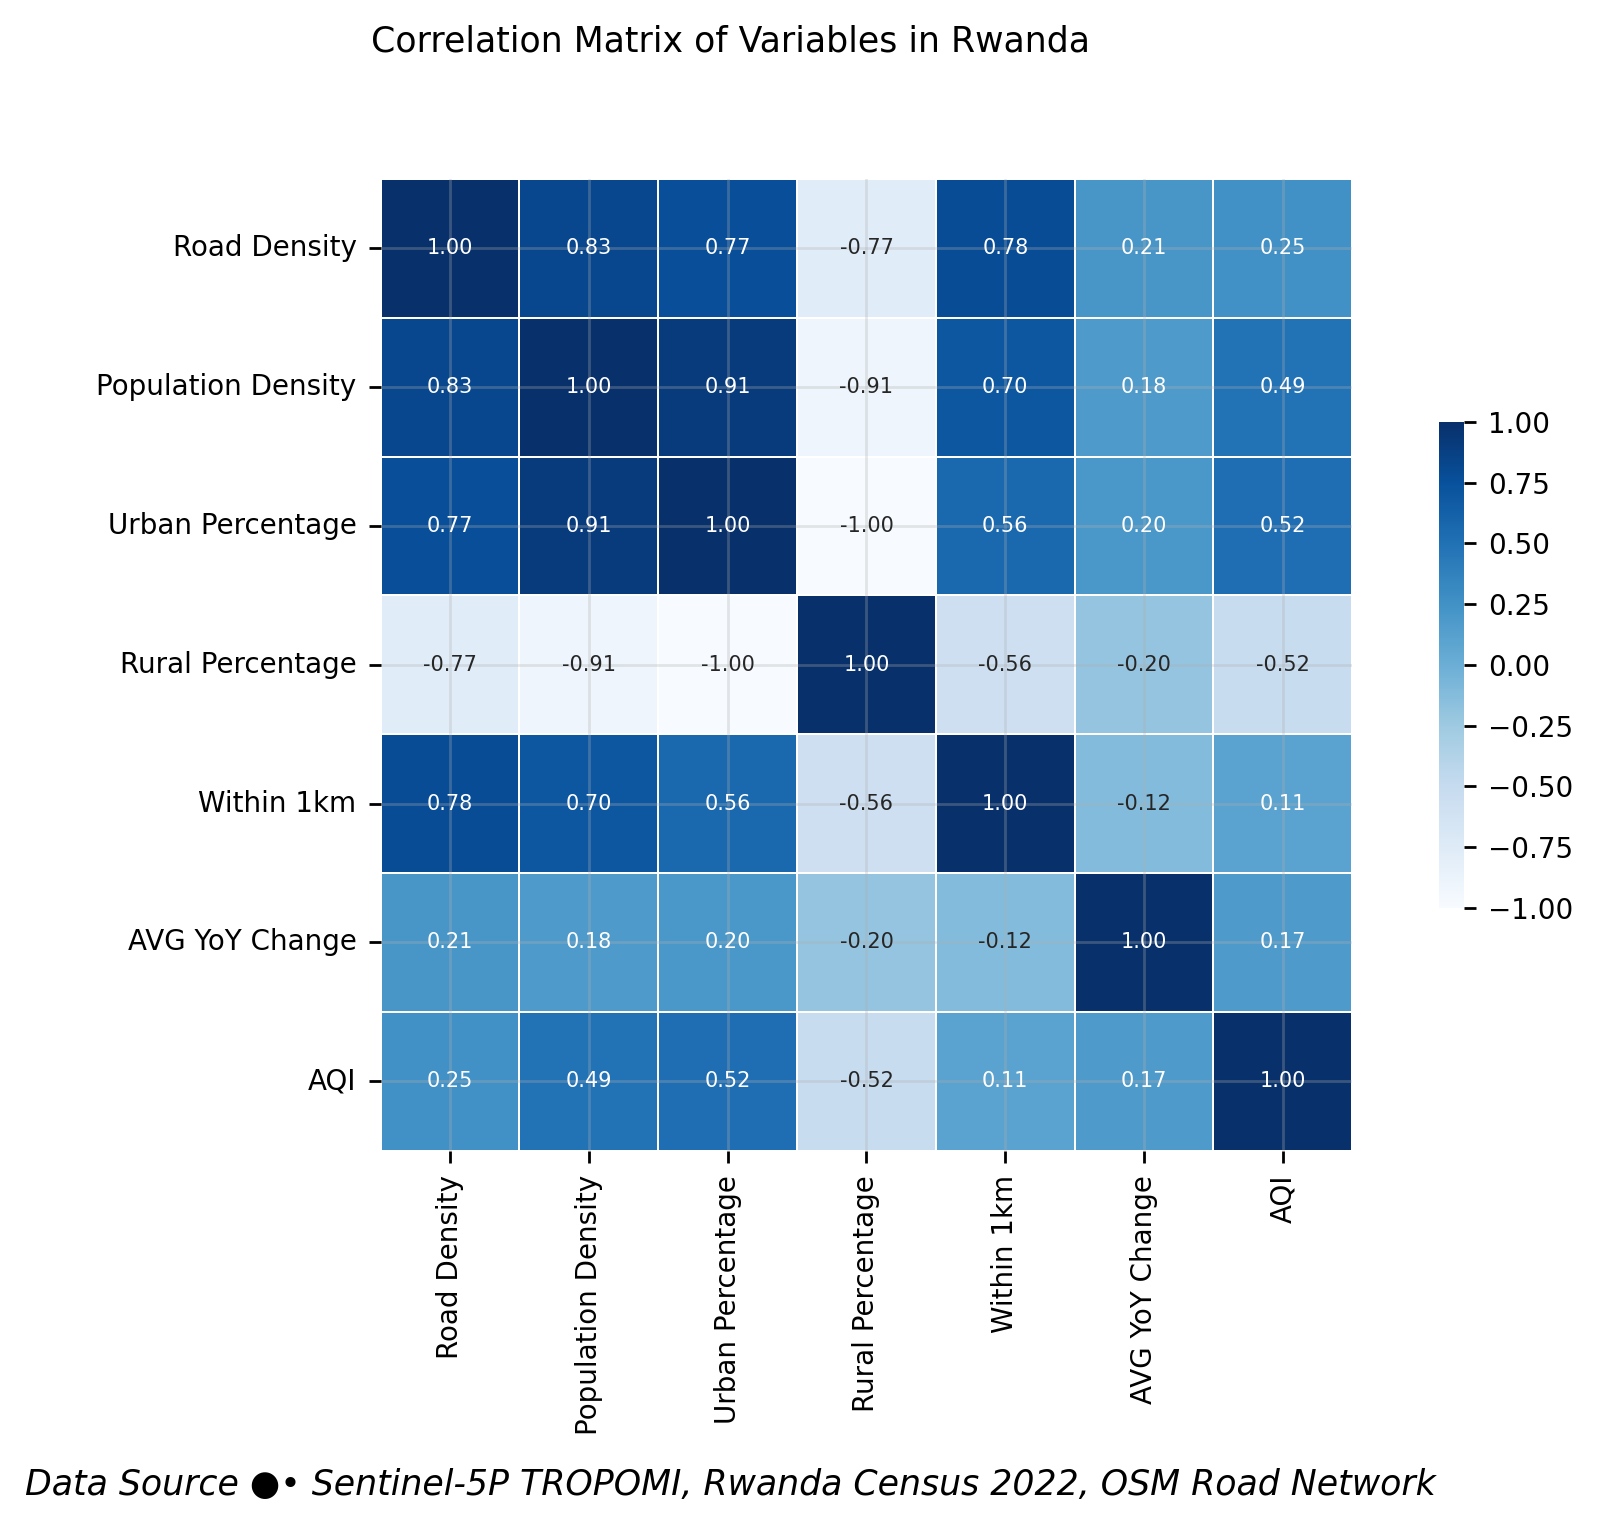

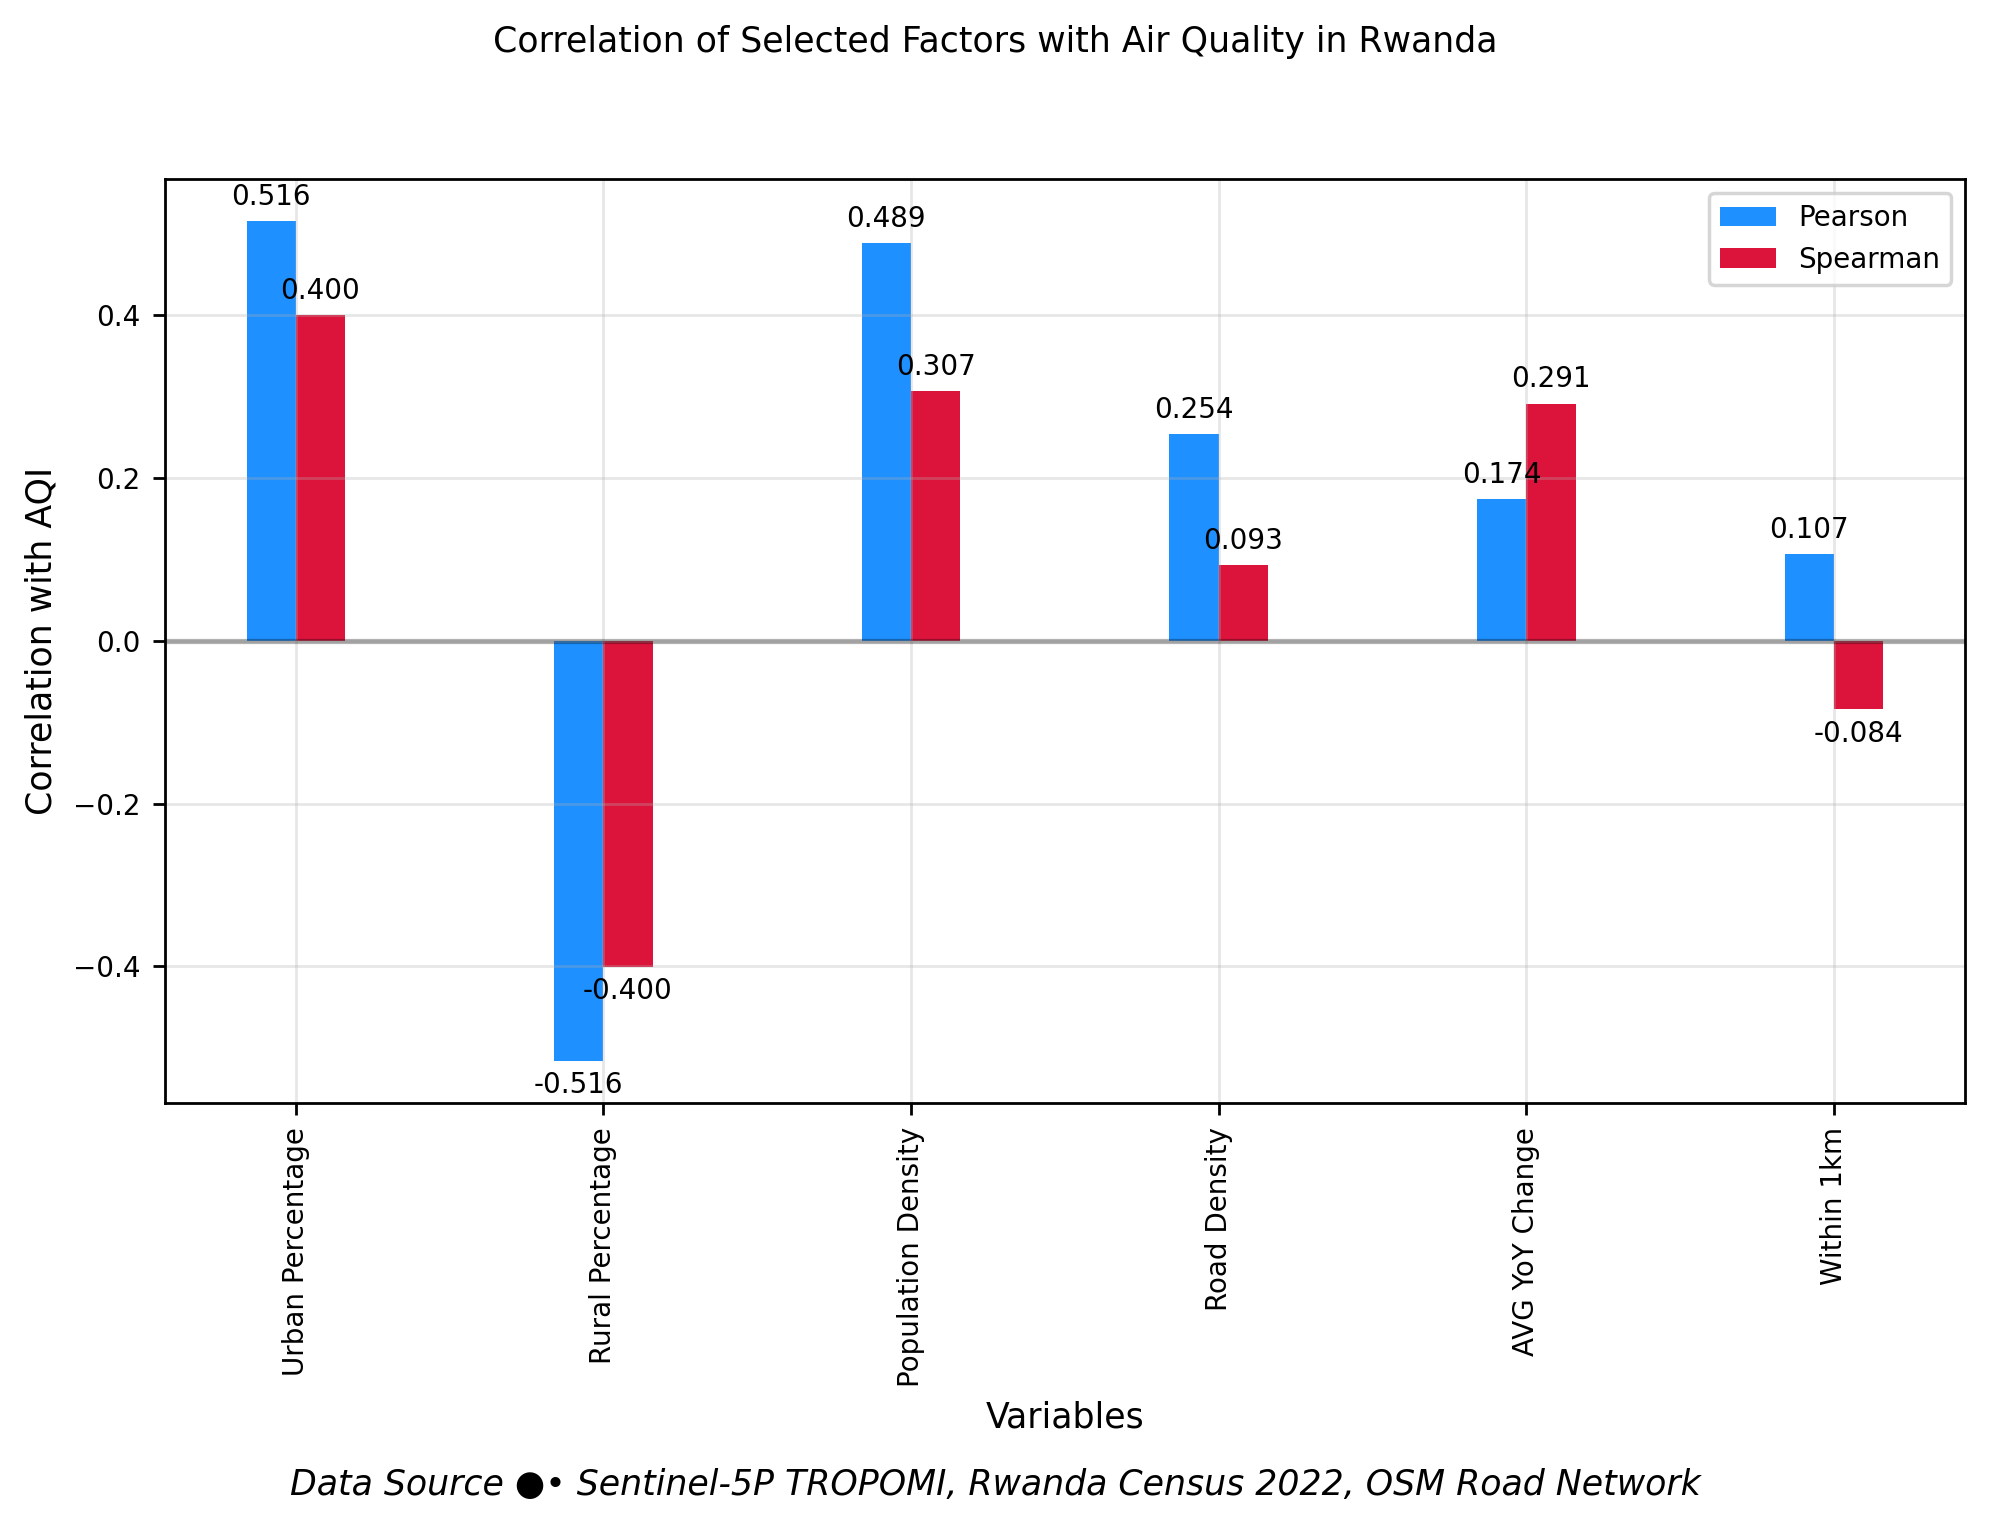

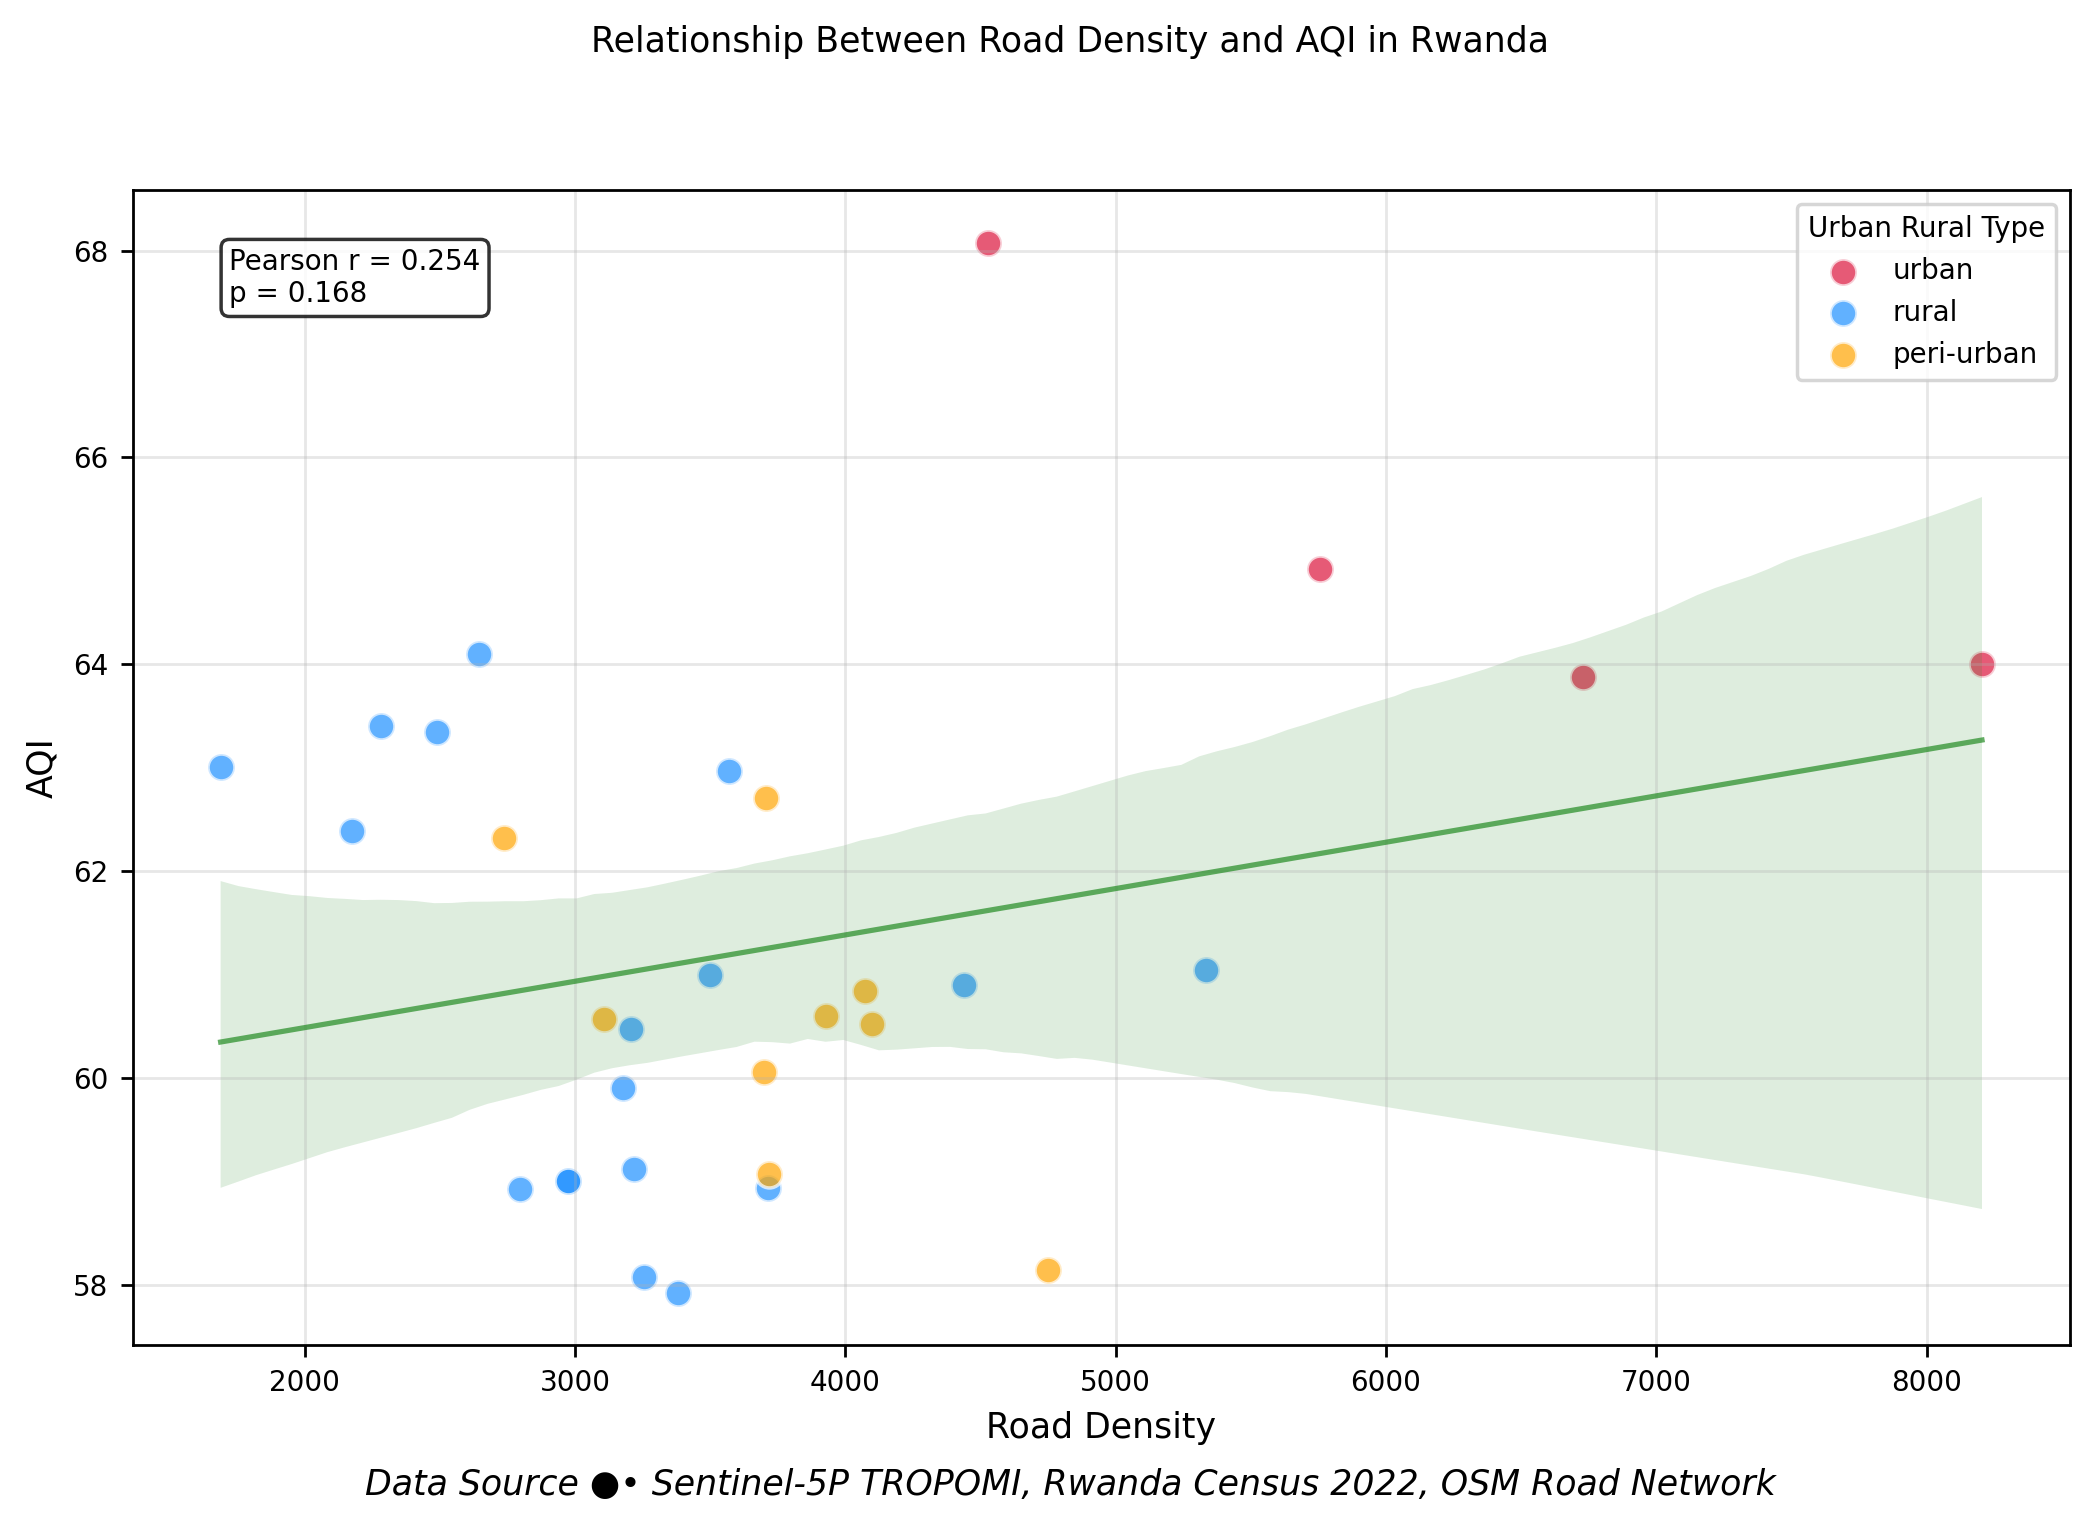

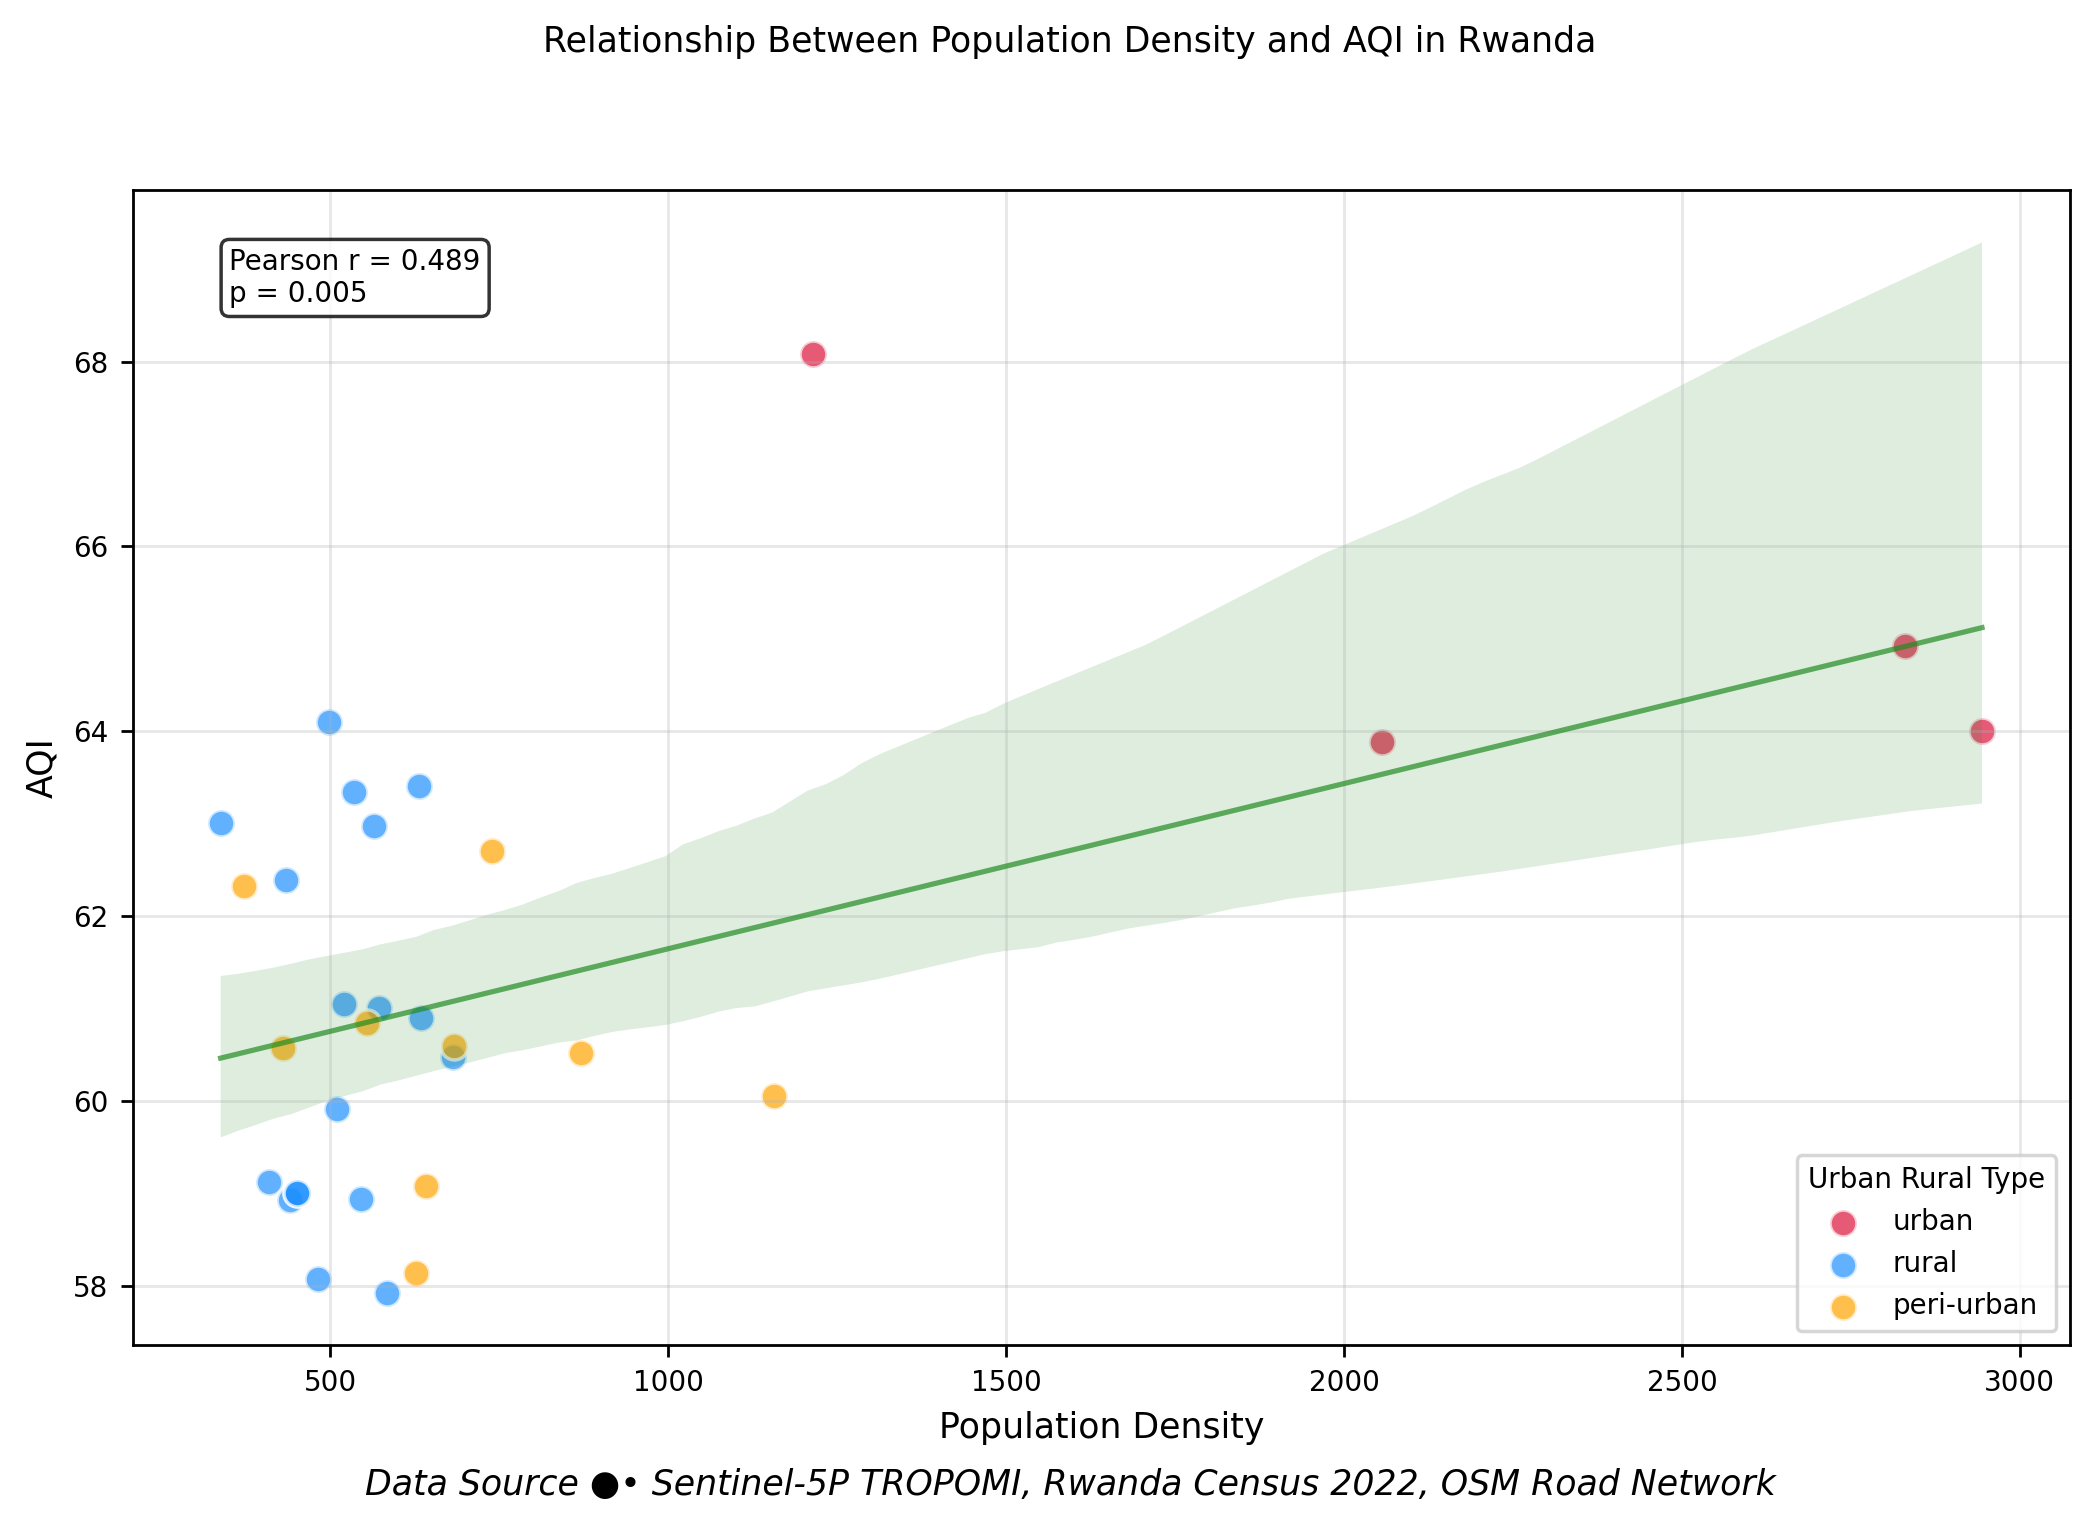

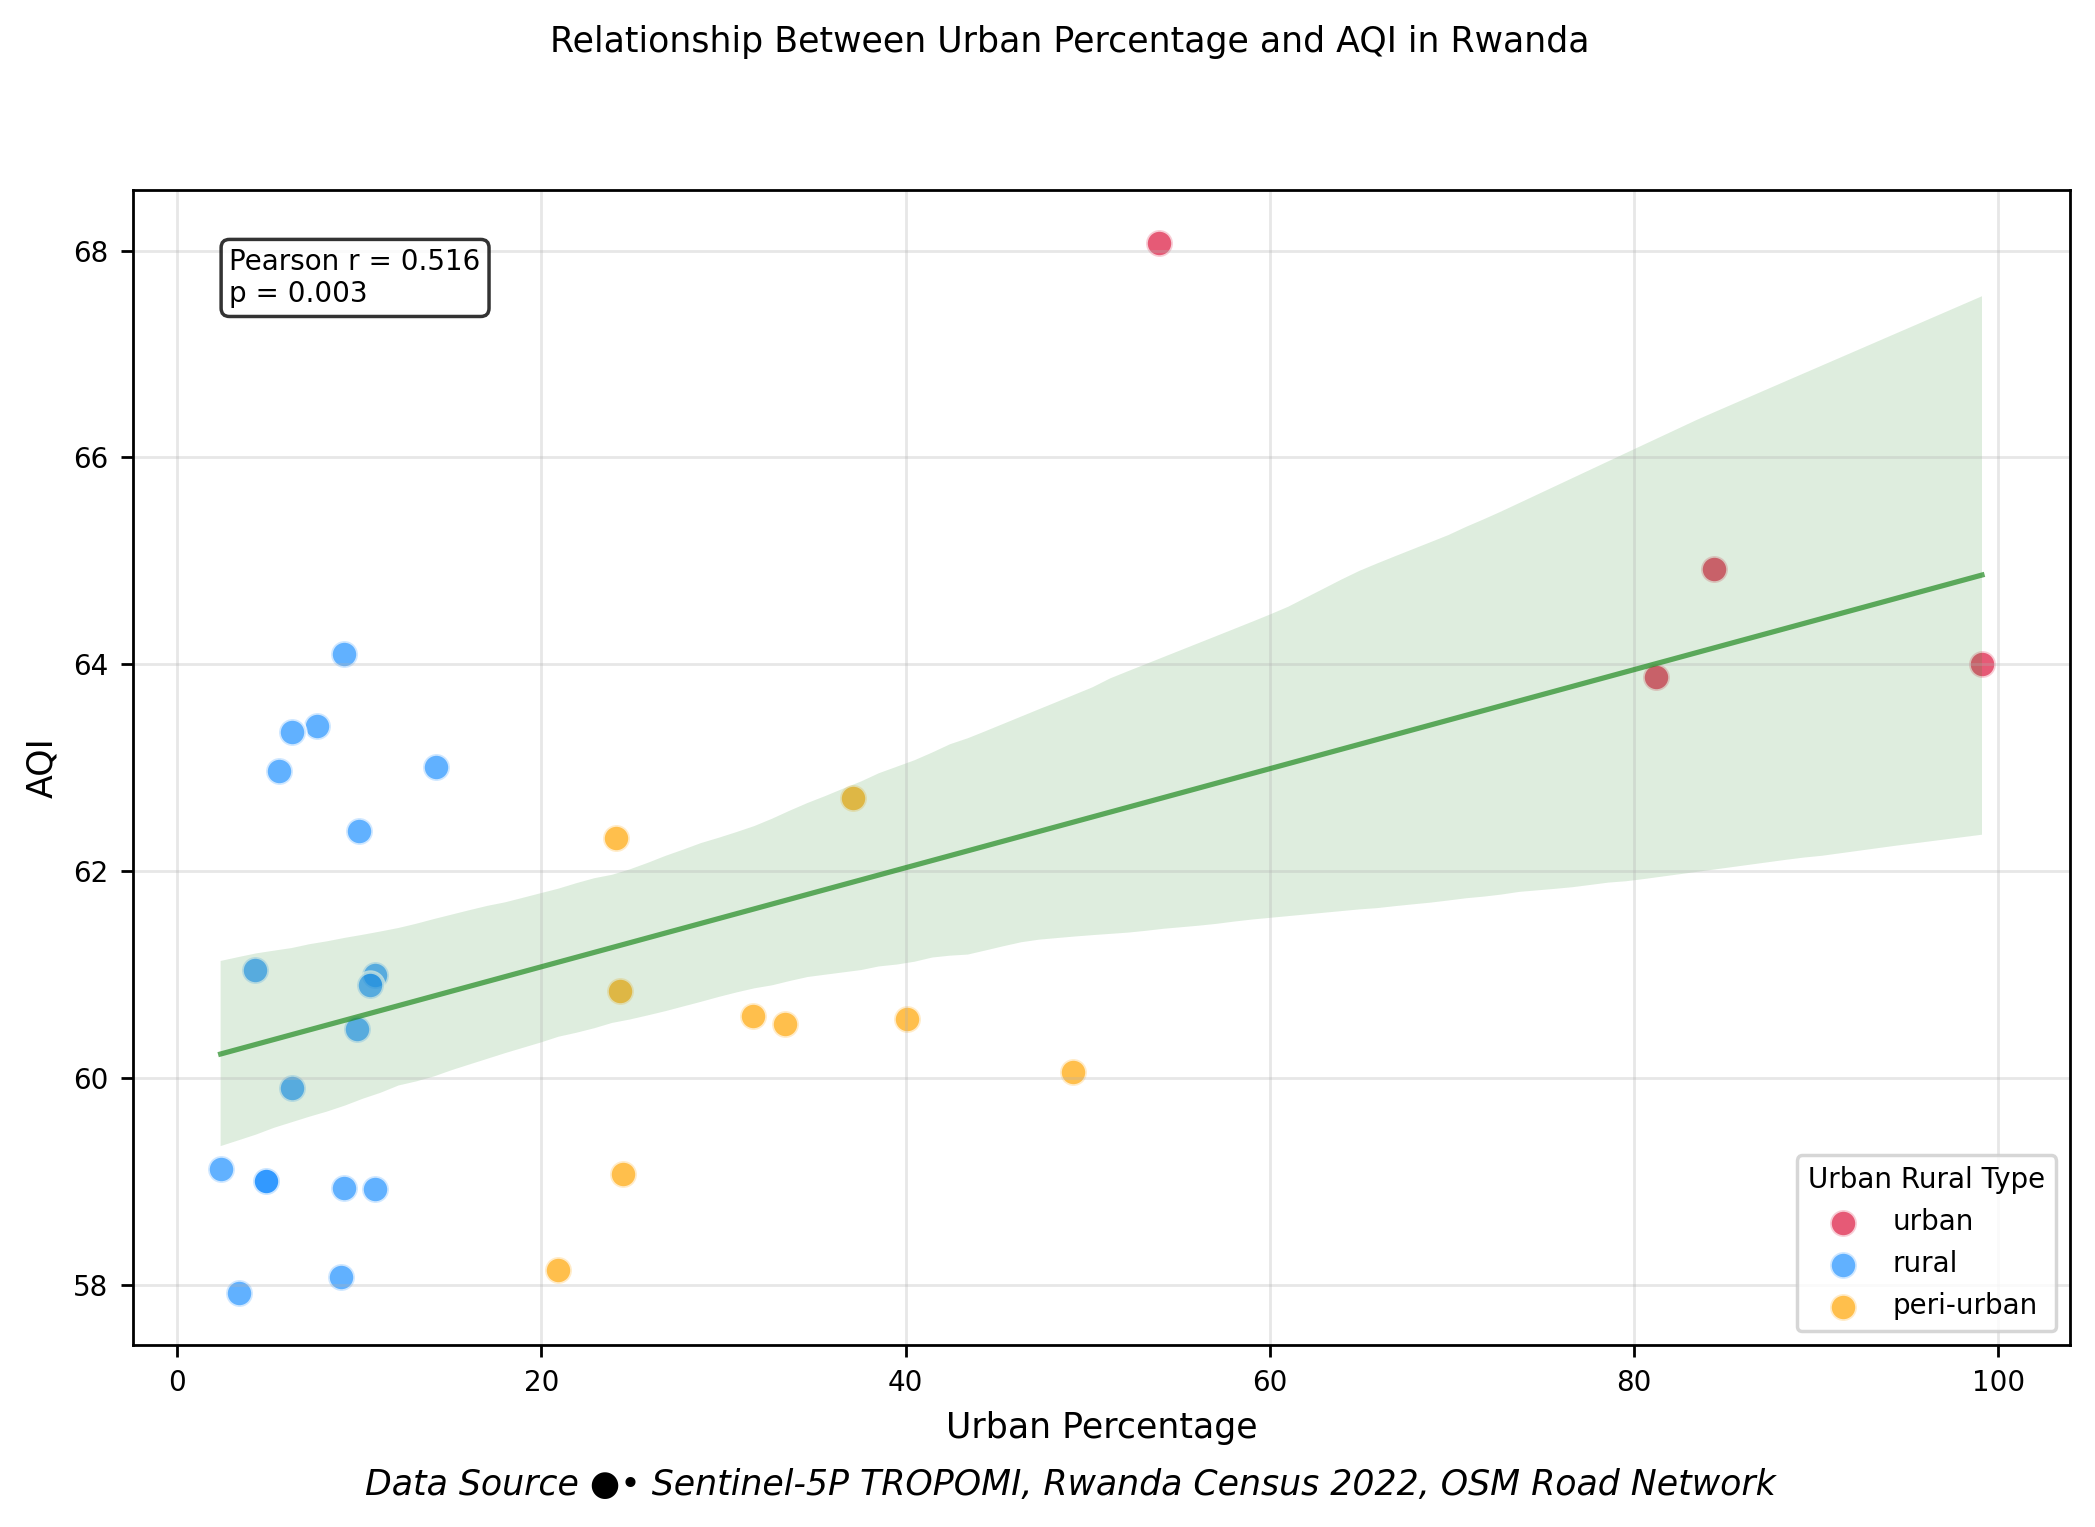

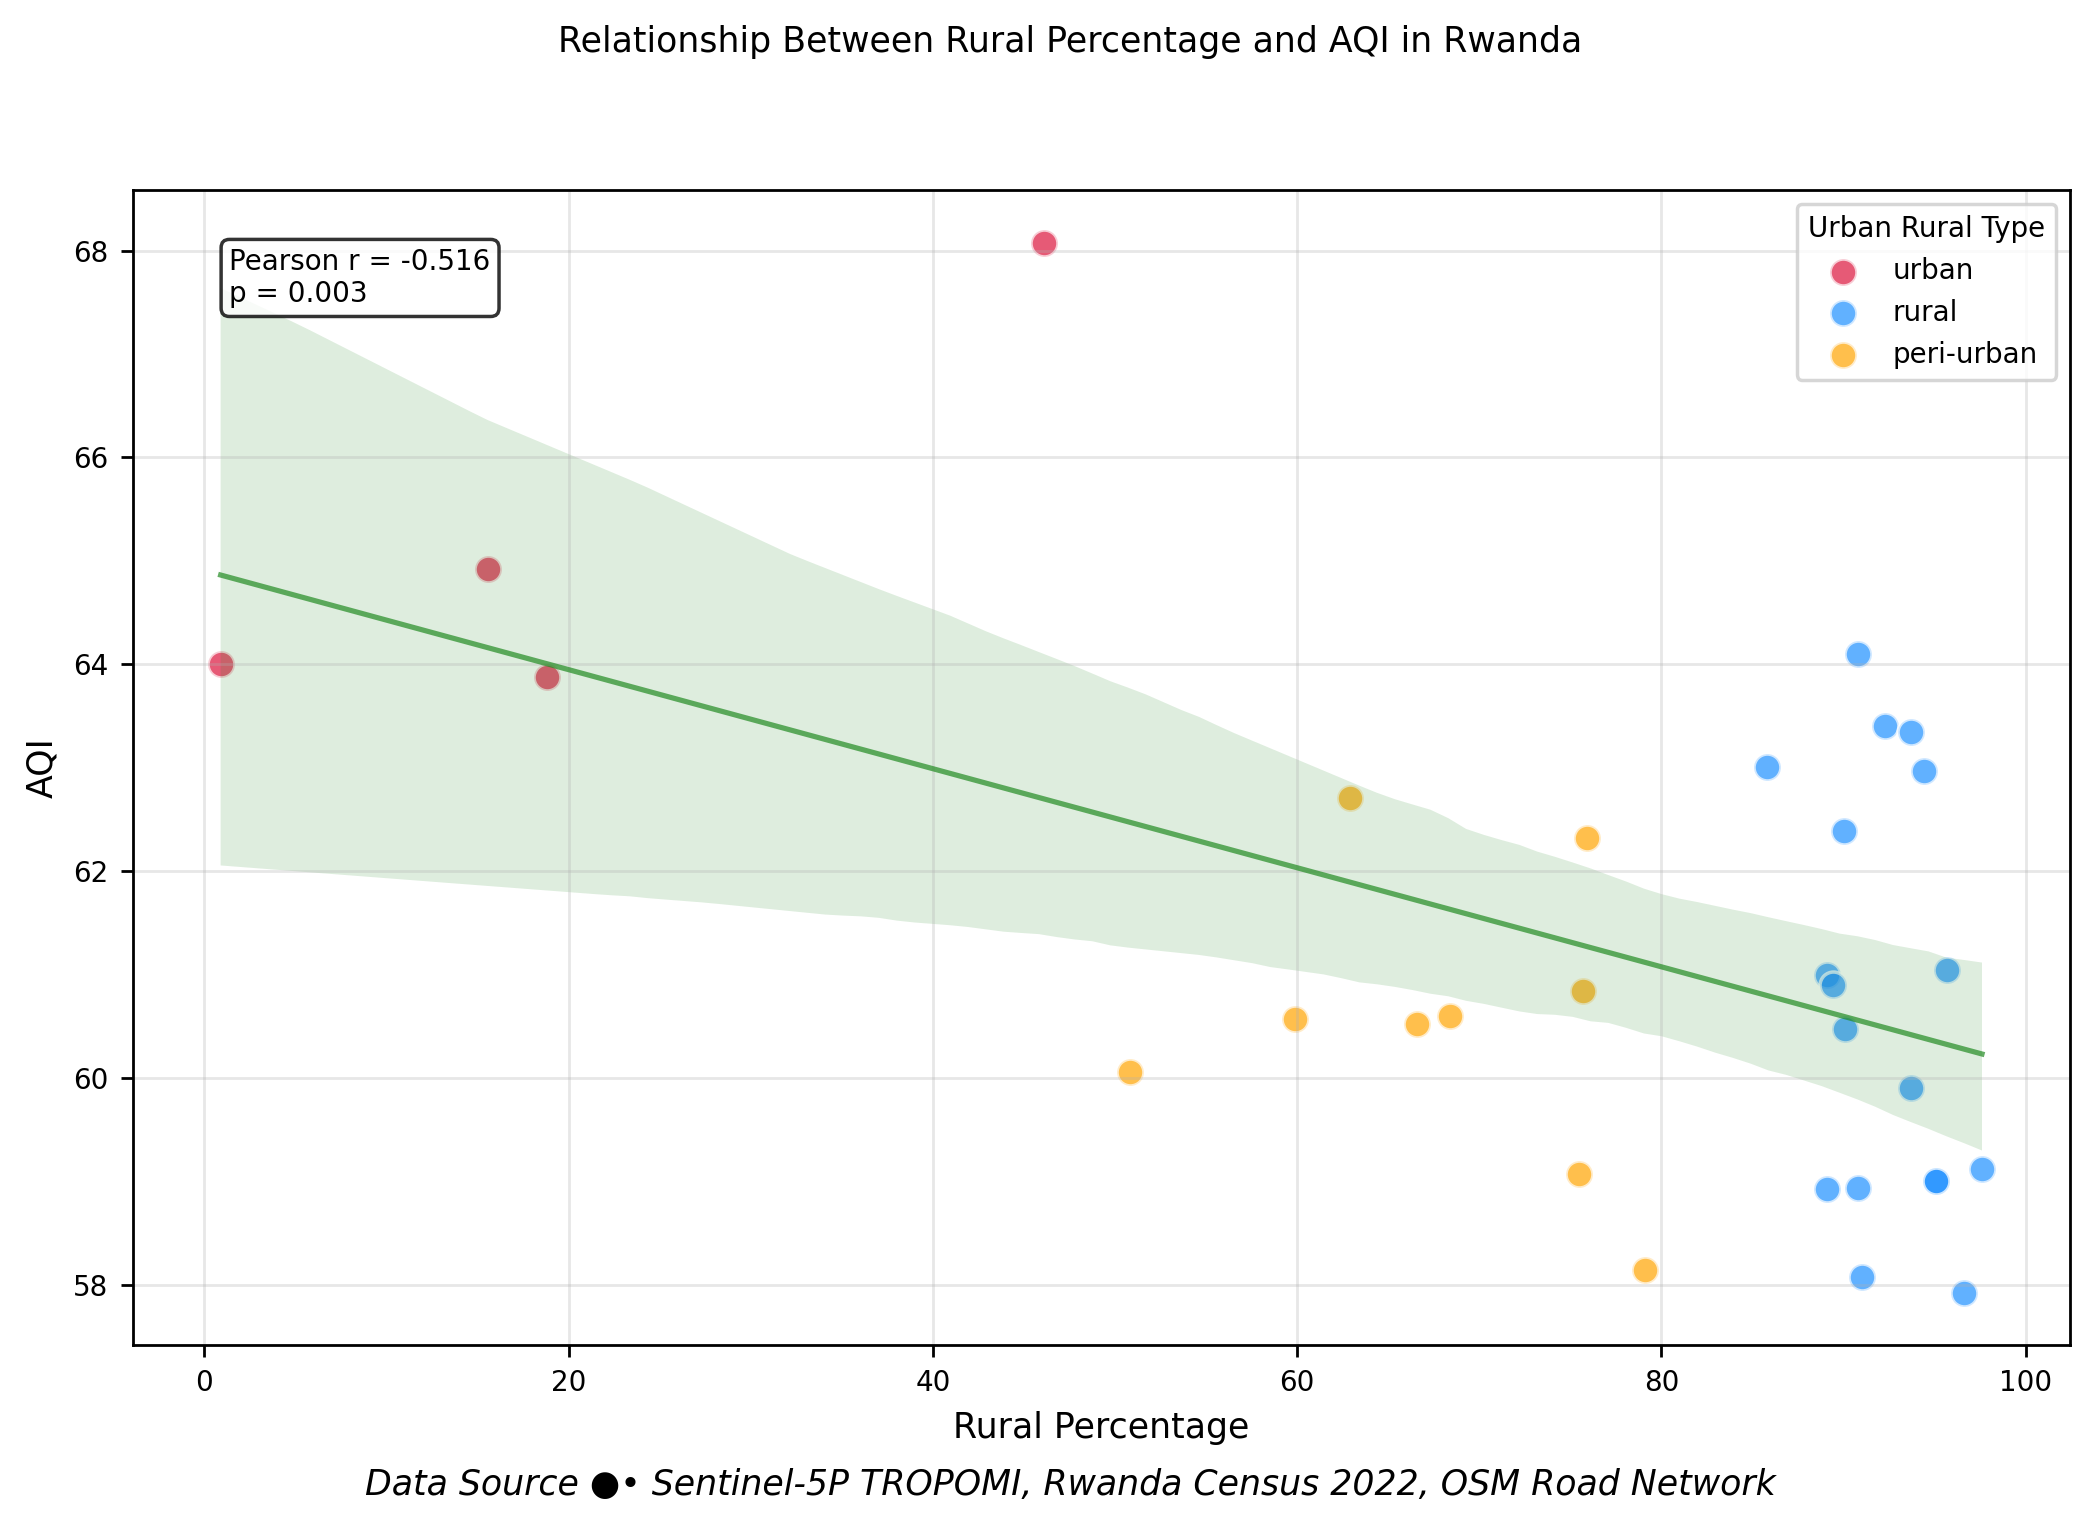

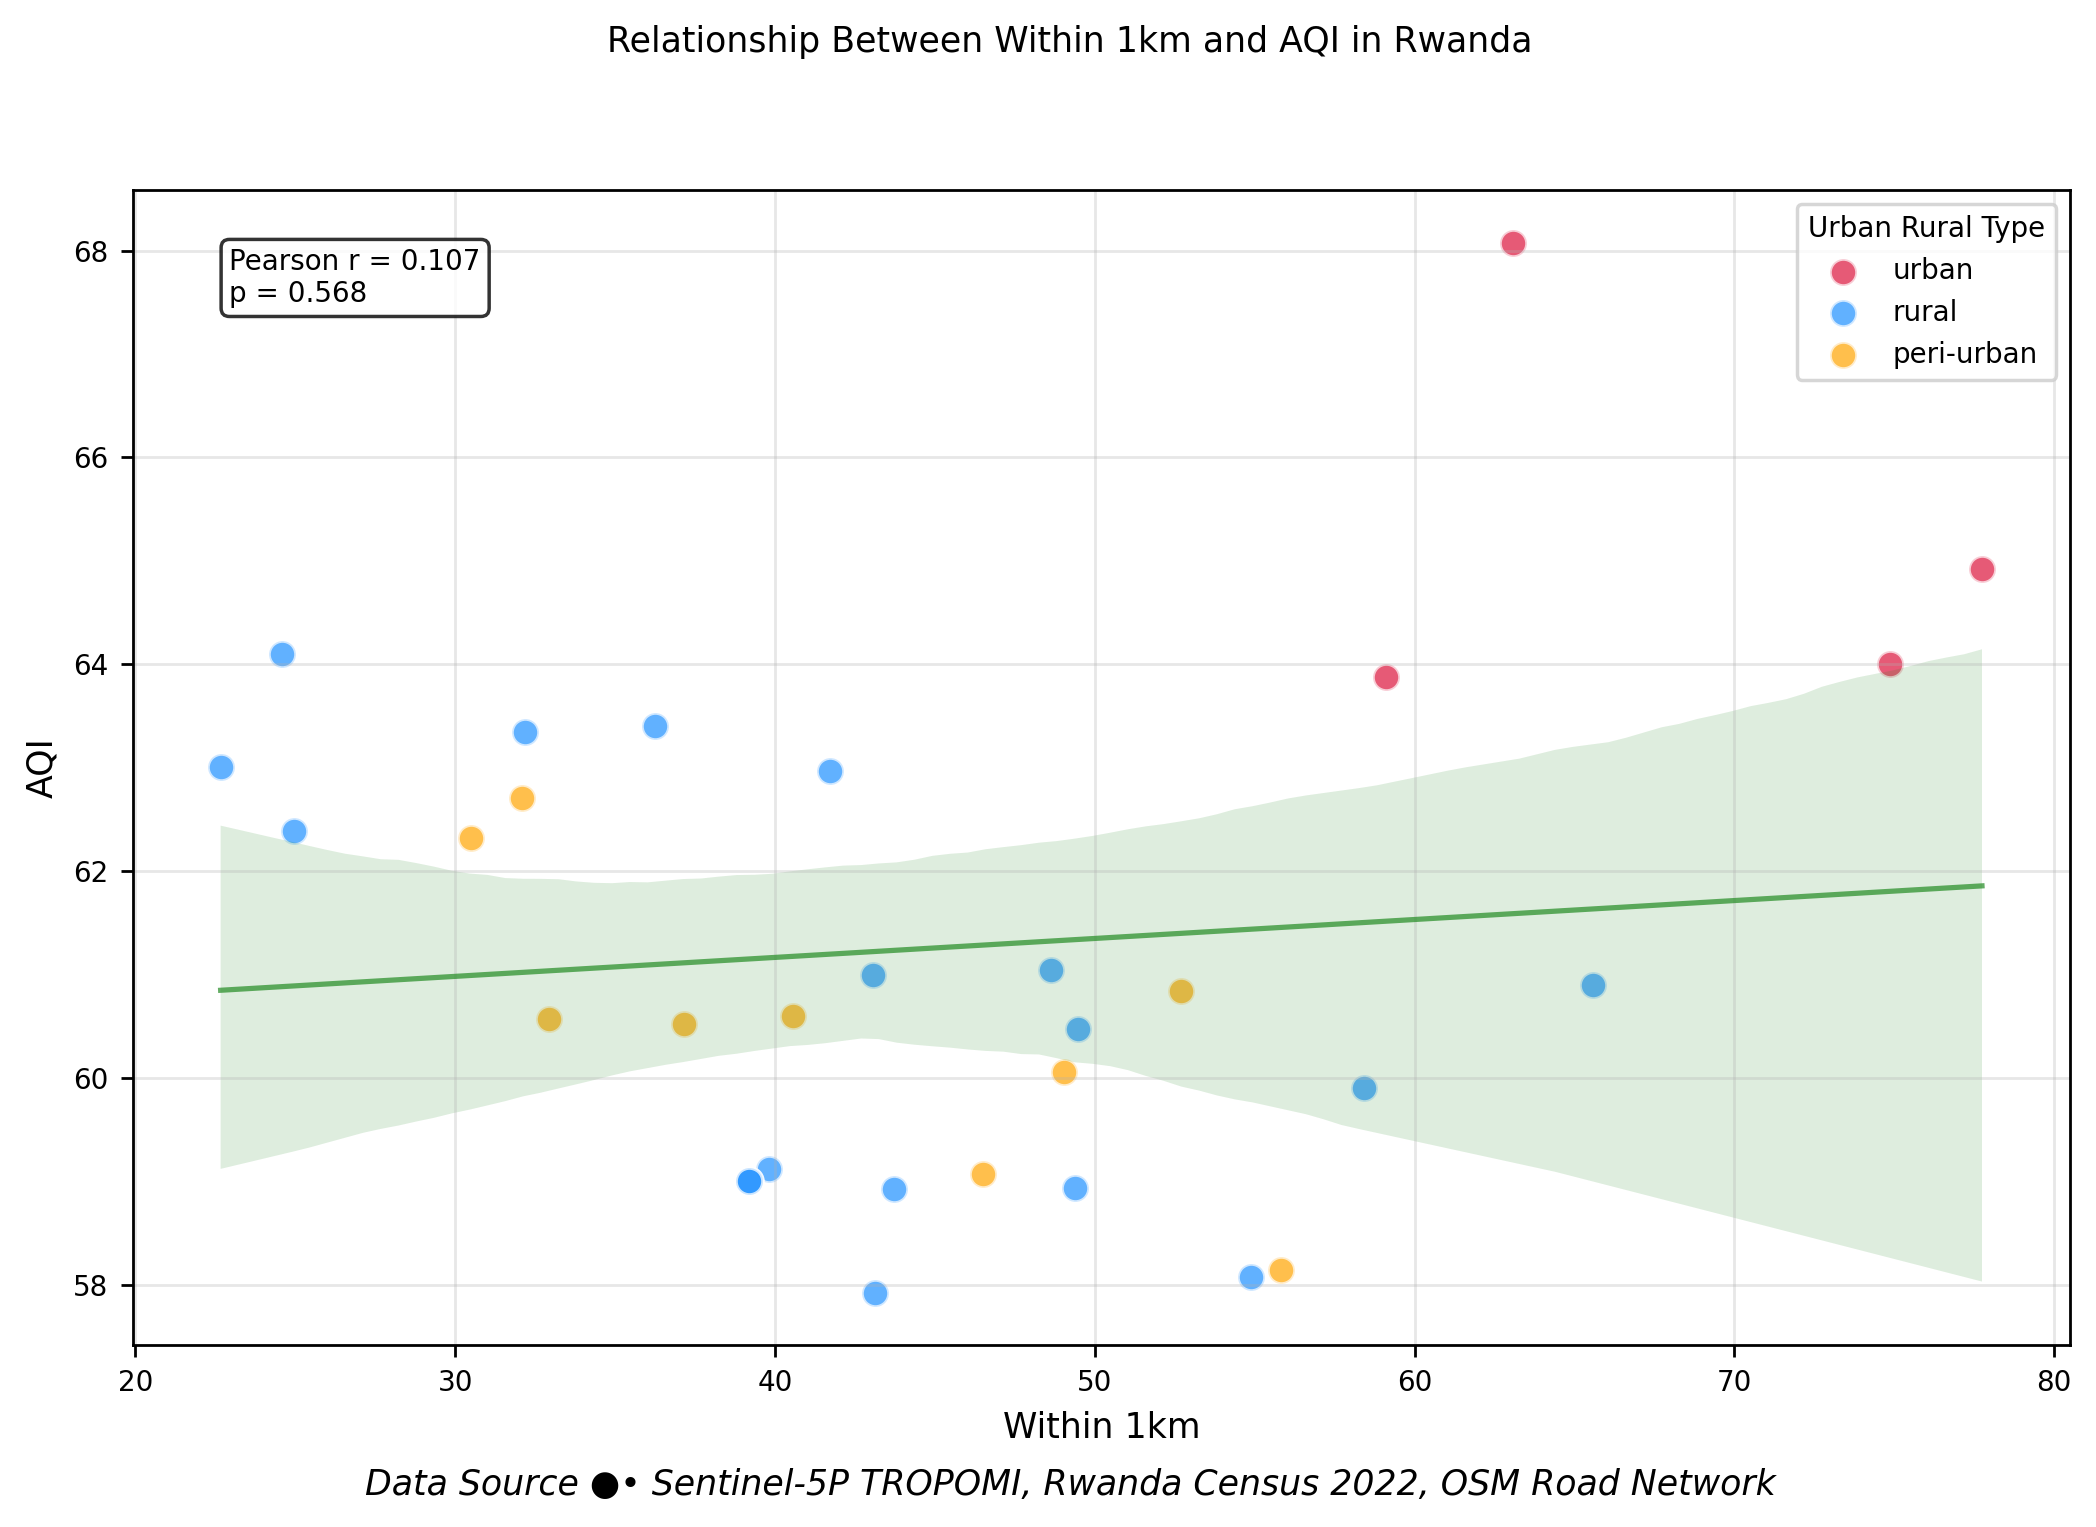

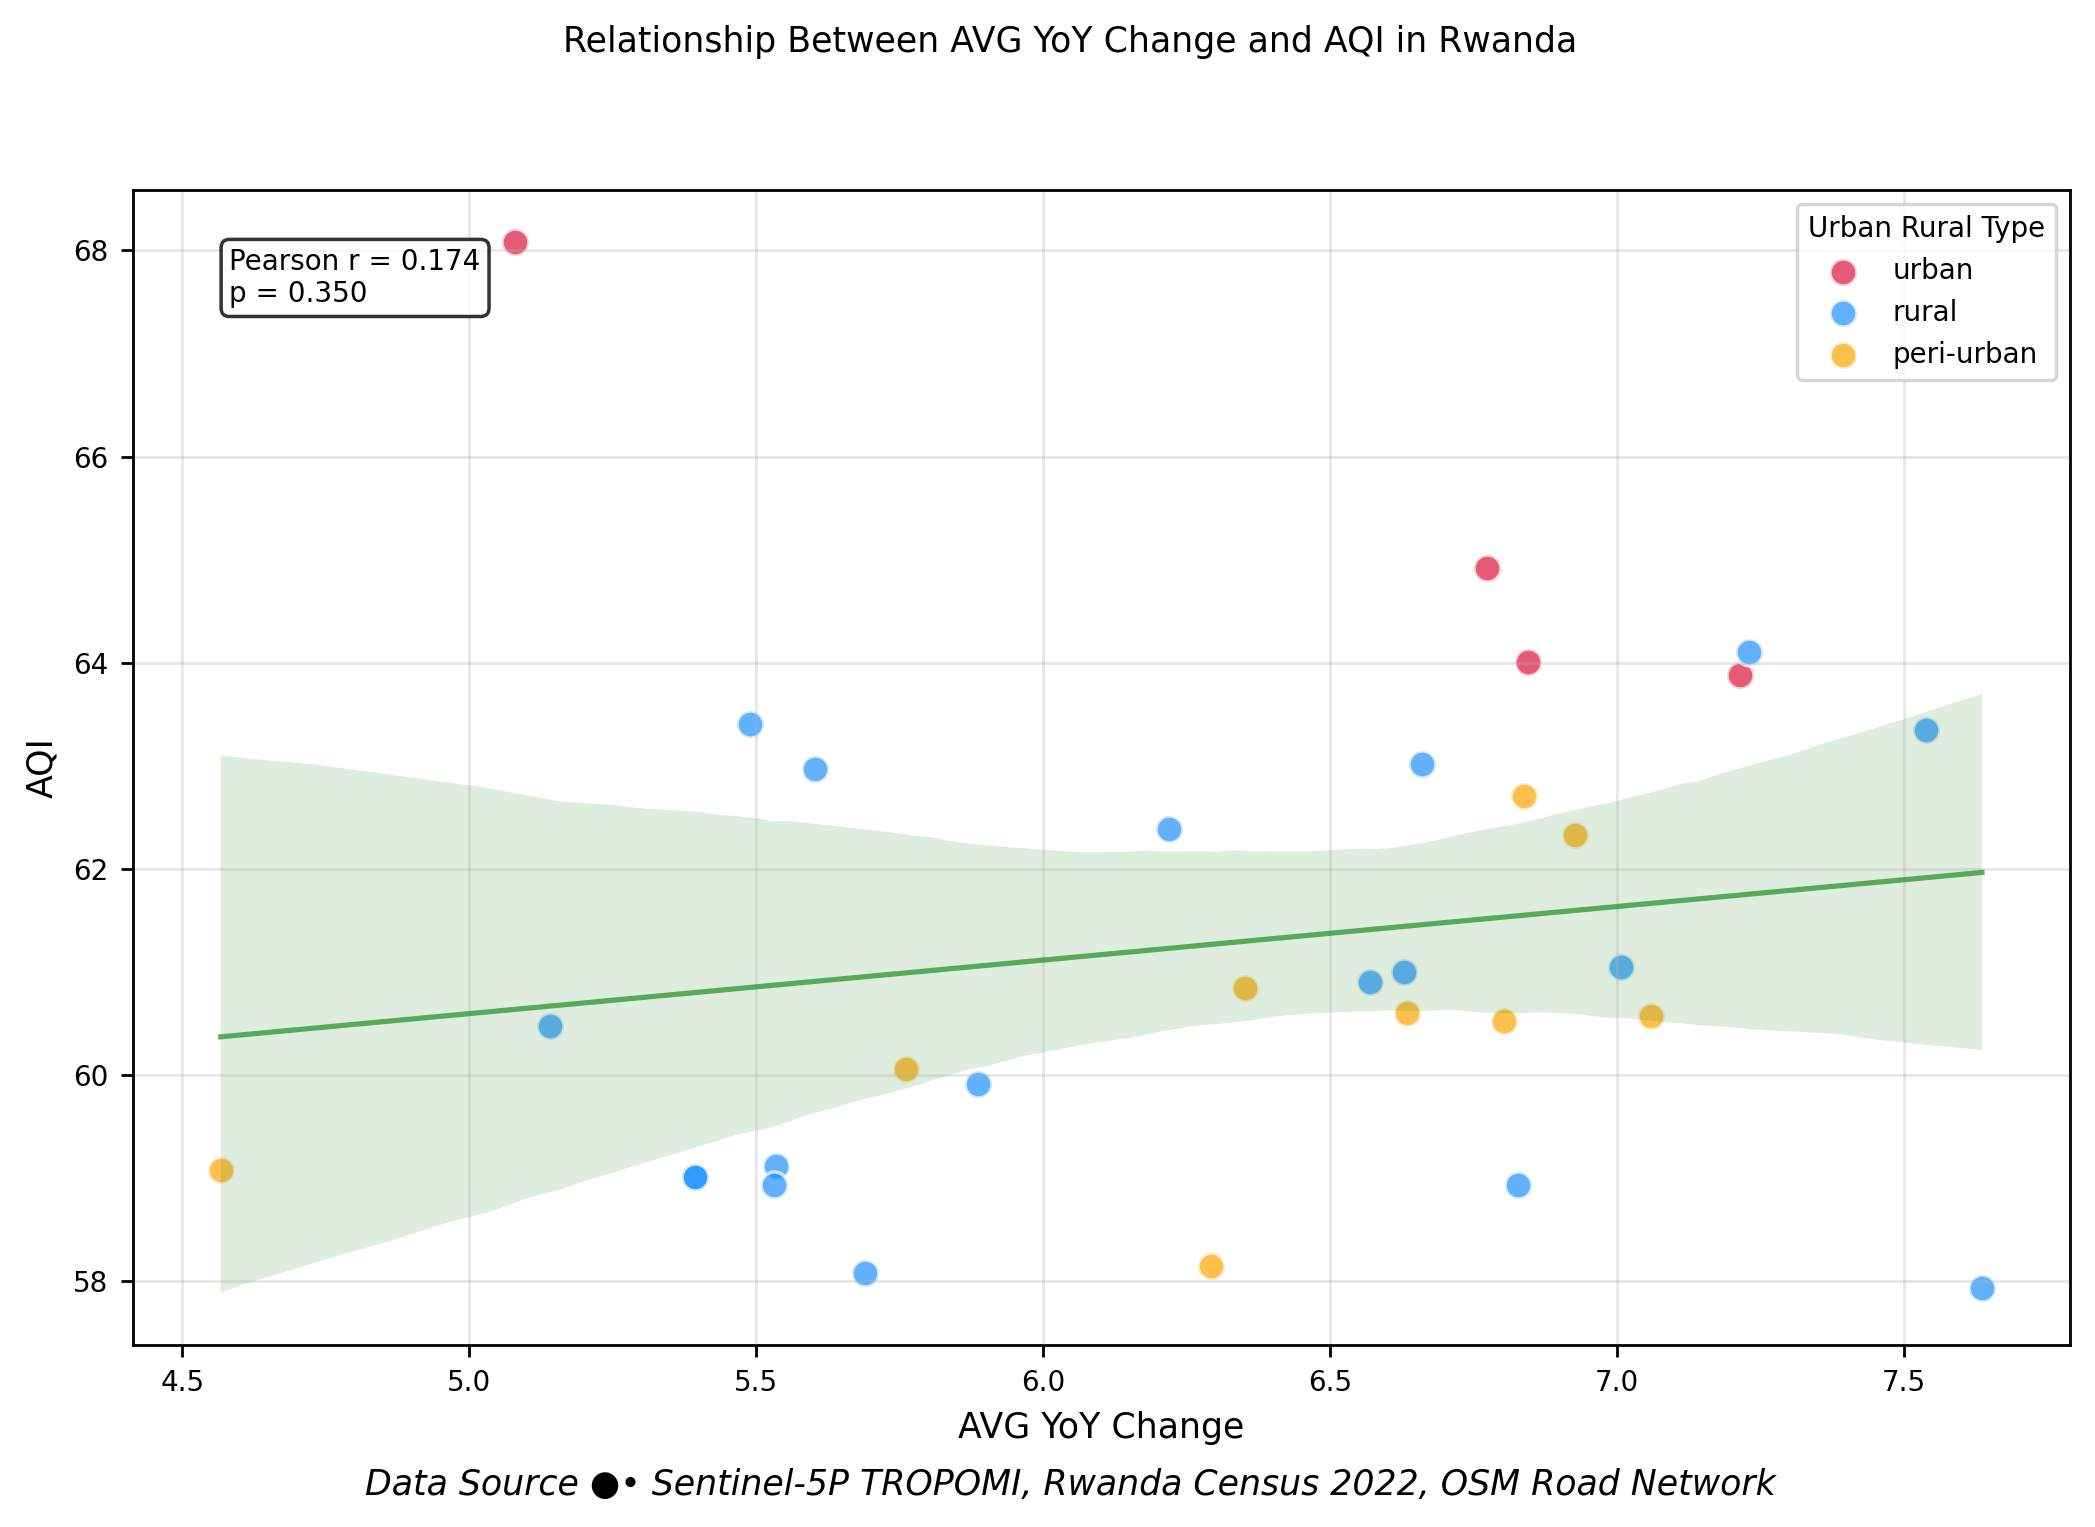

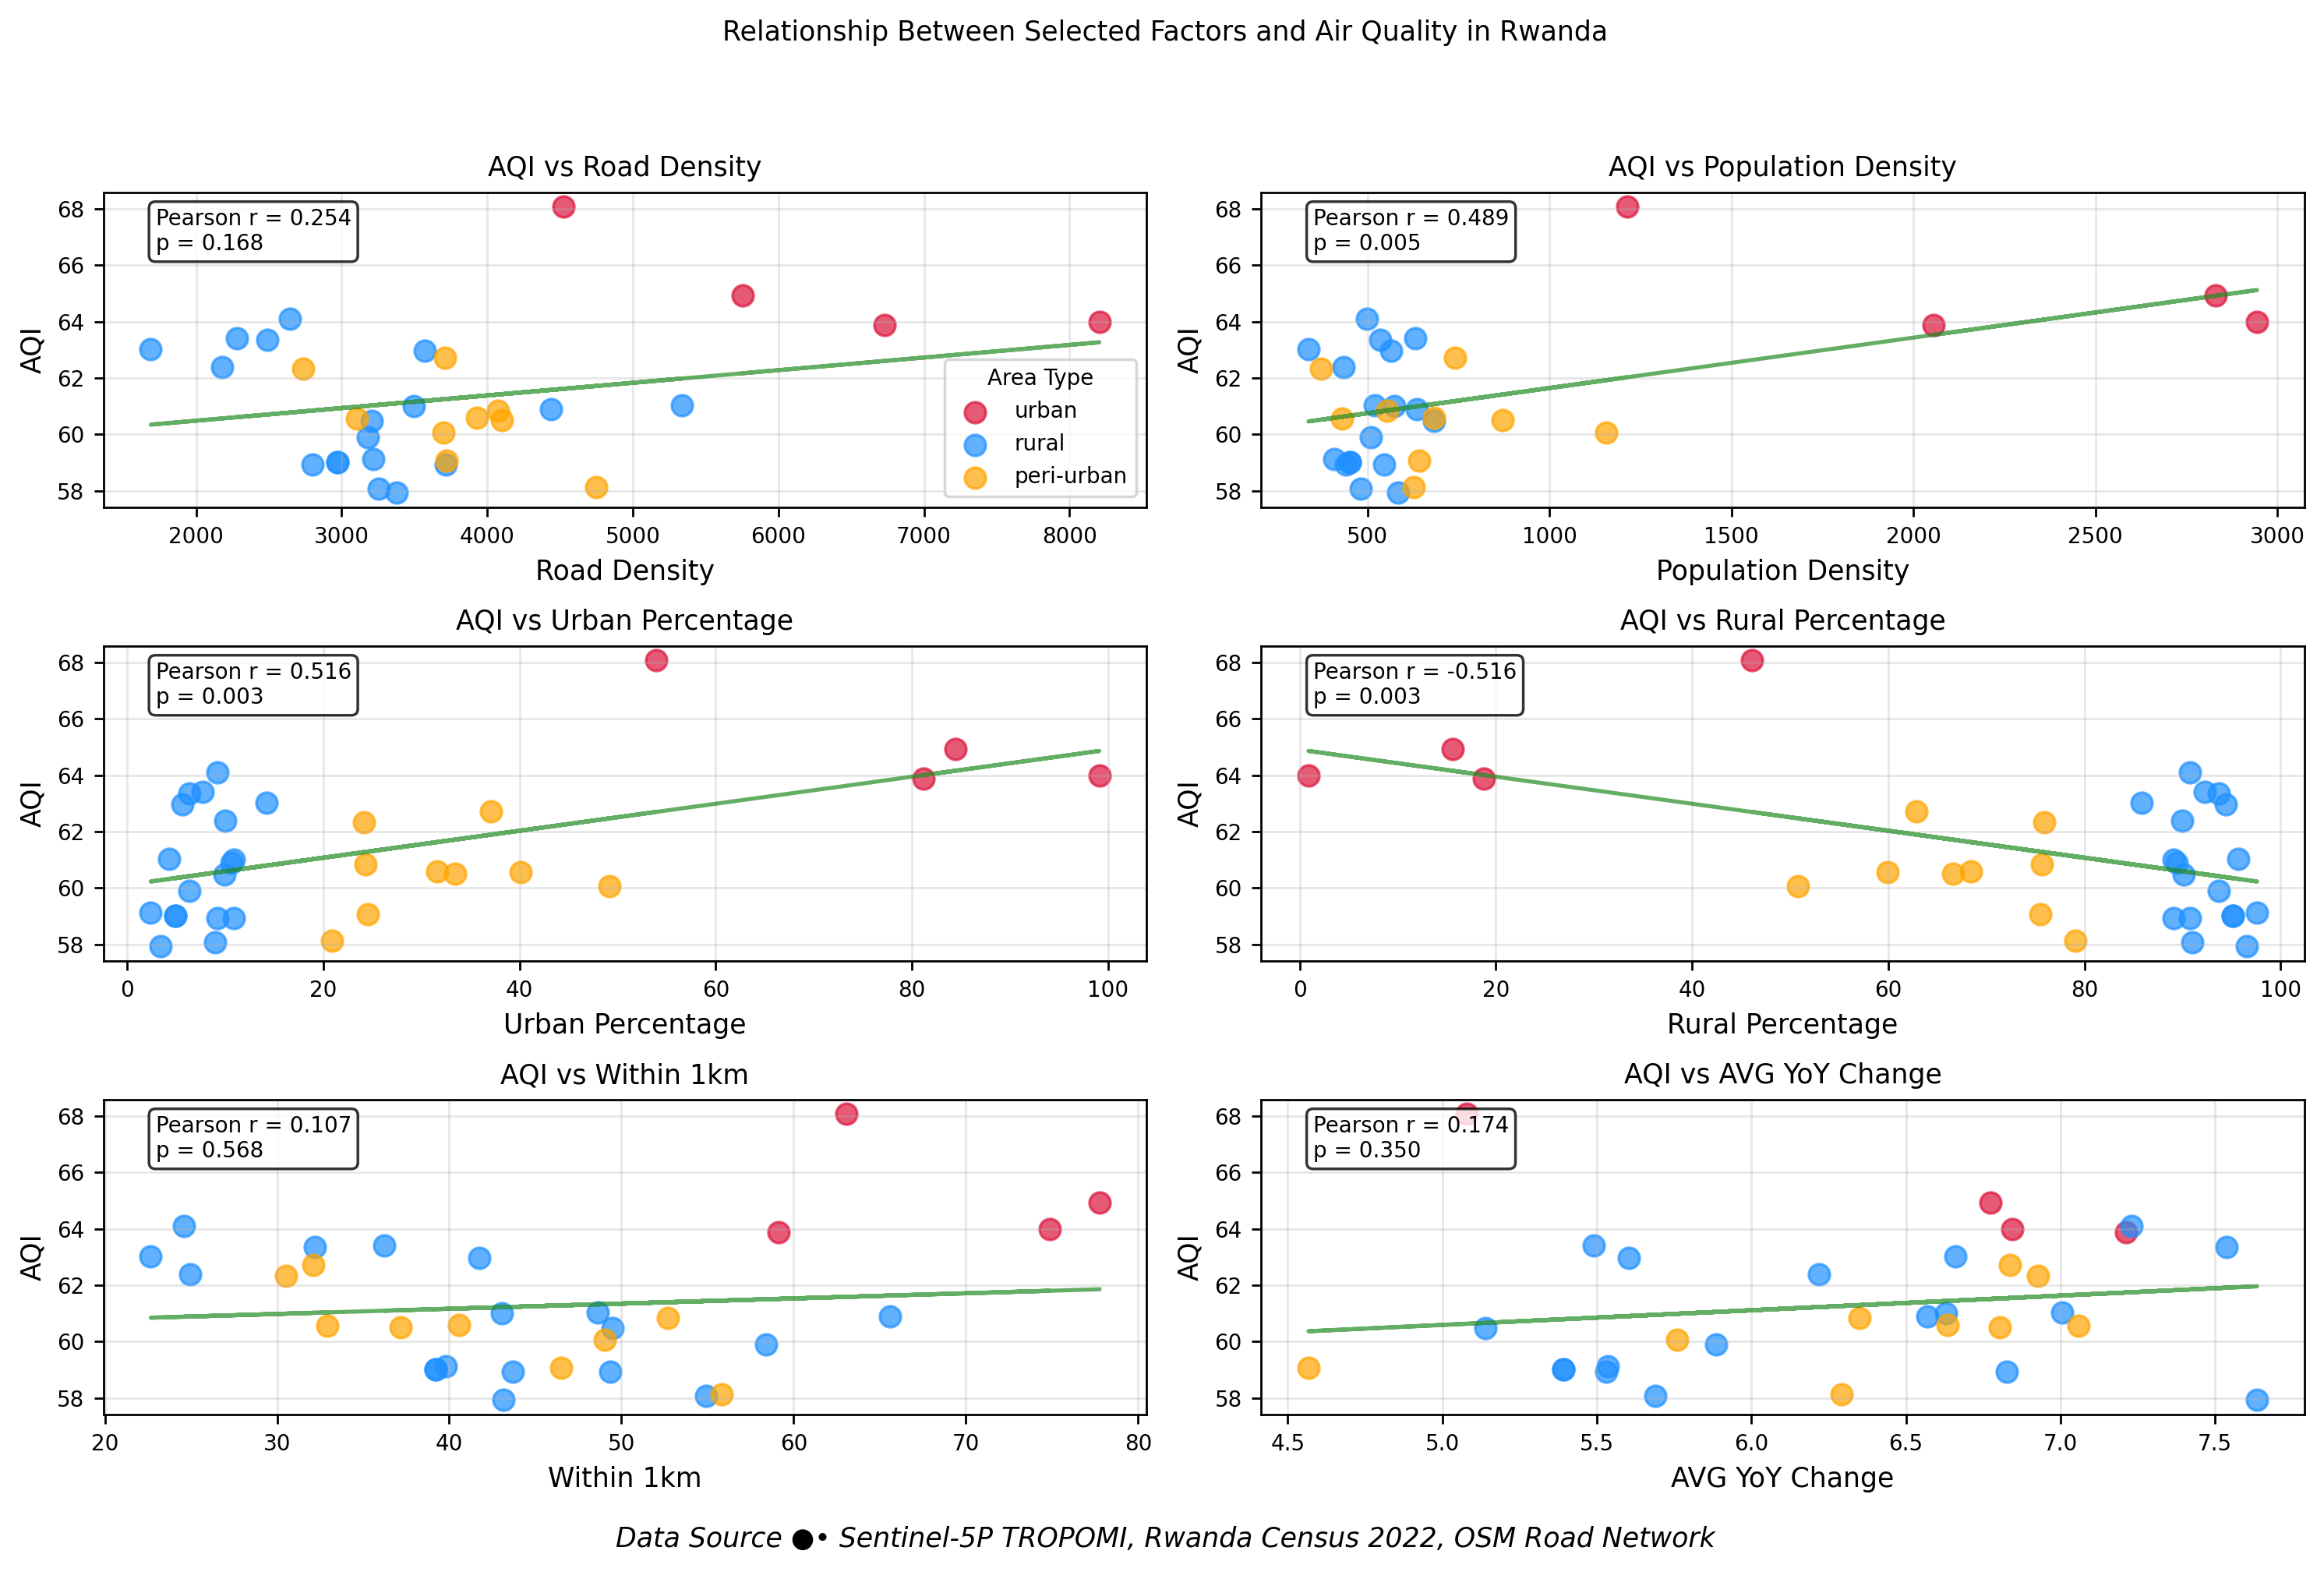

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import os
import logging
from datetime import datetime
import matplotlib as mpl


class CorrelationAnalysis:
    """
    Class for conducting correlation analysis between air quality
    and socioeconomic/geographic variables in Rwanda.
    """

    def __init__(self, data_path='datasets/integrated_district_data.csv', output_dir='figures',
                 log_dir='logs', analysis_name='correlation_analysis'):
        """Initialize with integrated dataset"""
        # Setup directories
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)

        # Setup logging
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = os.path.join(
            log_dir, f"{analysis_name}_{self.timestamp}.log")
        self.setup_logging(self.log_file)

        # Setup plotting style
        self.setup_plot_style()

        self.output_dir = output_dir
        self.data = pd.read_csv(data_path)
        self.corr_matrix_pearson = None
        self.corr_matrix_spearman = None

        logging.info(f"Loaded dataset with {len(self.data)} districts")

        # Identify key columns
        self.aqi_col = 'AQI_mean' if 'AQI_mean' in self.data.columns else None

        if not self.aqi_col:
            msg = "AQI column not found in dataset"
            logging.error(msg)
            raise ValueError(msg)

        logging.info(f"Using {self.aqi_col} as AQI variable")

    def setup_logging(self, log_file):
        """Set up logging to file and console"""
        # Clear any existing handlers
        for handler in logging.root.handlers[:]:
            logging.root.removeHandler(handler)

        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        logging.info(f"Logging setup")

    def setup_plot_style(self):
        """Setup consistent plot styling"""
        # Set color scheme with your original preferences
        self.colors = {
            'primary': 'dodgerblue',      # For positive correlations
            'secondary': 'crimson',       # For negative correlations
            'tertiary': 'orange',         # For intermediate values
            'urban': 'crimson',           # For urban areas
            'peri-urban': 'orange',       # For peri-urban areas
            'rural': 'dodgerblue',        # For rural areas
            'regression': 'forestgreen',  # For regression lines
            'pearson': 'dodgerblue',      # For Pearson correlation bars
            'spearman': 'forestgreen'     # For Spearman correlation bars
        }
        
        # Set up font and plot style with consistent font sizes
        plt.rcParams.update({
            'font.family': 'DejaVu Sans',
            'font.size': 8,               # Base font size for annotations
            'axes.titlesize': 10,         # Titles for axes (subplots)
            'axes.labelsize': 10,         # Axis labels
            'xtick.labelsize': 8,         # Tick labels
            'ytick.labelsize': 8,         # Tick labels
            'figure.figsize': (10, 6),
            'figure.dpi': 250,
            'savefig.dpi': 350,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def clean_variable_name(self, var_name):
        """Convert variable names to display format"""
        clean_name = var_name.replace('_', ' ')
        if clean_name.lower() == 'aqi mean':
            return 'AQI'
        elif 'population density' in clean_name.lower():
            return 'Population Density'
        elif 'road density' in clean_name.lower():
            return 'Road Density'
        elif 'pct within 1km' in clean_name.lower():
            return 'Within 1km'
        elif 'urban percentage' in clean_name.lower():
            return 'Urban Percentage'
        elif 'rural percentage' in clean_name.lower():
            return 'Rural Percentage'
        elif 'avg yoy change' in clean_name.lower():
            return 'AVG YoY Change'
        clean_name = ' '.join(word.capitalize() for word in clean_name.split())
        clean_name = clean_name.replace(' M Km2', '')
        clean_name = clean_name.replace(' Sqkm', '')
        return clean_name

    def calculate_correlations(self, method='pearson'):
        """Calculate correlations between selected variables"""
        # Select the top 6 variables plus AQI_mean
        selected_vars = [
            'road_density_m_km2', 'population_density', 'urban_percentage',
            'rural_percentage', 'pct_within_1km', 'avg_yoy_change', 'AQI_mean', 
        ]
        numeric_cols = [
            col for col in selected_vars if col in self.data.columns]

        logging.info(
            f"Calculating {method} correlations for {len(numeric_cols)} variables")
        corr_matrix = self.data[numeric_cols].corr(method=method)

        if method == 'pearson':
            self.corr_matrix_pearson = corr_matrix
        else:
            self.corr_matrix_spearman = corr_matrix

        if self.aqi_col in corr_matrix.columns:
            aqi_corr = corr_matrix[self.aqi_col].sort_values(
                key=abs, ascending=False)
            logging.info(f"Top {method} correlations with AQI:")
            for var, corr in aqi_corr.items():
                if var != self.aqi_col:
                    logging.info(
                        f"  {self.clean_variable_name(var)}: {corr:.4f}")

        return corr_matrix

    def plot_correlation_matrix(self, method='pearson', figsize=(8, 6)):
        """Plot a heatmap of the correlation matrix"""
        if method == 'pearson' and self.corr_matrix_pearson is None:
            self.calculate_correlations(method='pearson')
        elif method == 'spearman' and self.corr_matrix_spearman is None:
            self.calculate_correlations(method='spearman')

        corr_matrix = self.corr_matrix_pearson if method == 'pearson' else self.corr_matrix_spearman

        logging.info(f"Creating correlation matrix visualization")
        fig = plt.figure(figsize=figsize)
        fig.suptitle('Correlation Matrix of Variables in Rwanda',
                     fontsize=10, y=0.99)

        sns.heatmap(corr_matrix, cmap='Blues', vmax=1, vmin=-1, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,
                    annot_kws={"size": 6}, fmt=".2f")

        plt.xticks(ticks=np.arange(len(corr_matrix.columns))+0.5,
                   labels=[self.clean_variable_name(
                       col) for col in corr_matrix.columns],
                   rotation=90, ha='center', fontsize=8)
        plt.yticks(ticks=np.arange(len(corr_matrix.columns))+0.5,
                   labels=[self.clean_variable_name(
                       col) for col in corr_matrix.columns],
                   fontsize=8)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        file_path = os.path.join(
            self.output_dir, f"correlation_matrix_{method}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved correlation matrix visualization")

        return plt.gcf()

    def plot_aqi_vs_variable(self, variable, color_by='urban_rural_type', figsize=(10, 6)):
        """Create scatter plot of AQI vs another variable, colored by a category"""
        if variable not in self.data.columns:
            msg = f"Variable {variable} not found in dataset"
            logging.error(msg)
            raise ValueError(msg)

        if color_by not in self.data.columns:
            logging.warning(
                f"Color variable {color_by} not found, using default coloring")
            color_by = None

        fig = plt.figure(figsize=figsize)
        fig.suptitle(f'Relationship Between {self.clean_variable_name(variable)} and AQI in Rwanda',
                     fontsize=10, y=0.99)

        if color_by:
            categories = self.data[color_by].unique()
            colors = {cat: self.colors.get(cat, 'blue') for cat in categories}
            for category in categories:
                subset = self.data[self.data[color_by] == category]
                plt.scatter(subset[variable], subset[self.aqi_col],
                            label=category, color=colors[category],
                            alpha=0.7, edgecolor='w', s=60)

            plt.legend(title=self.clean_variable_name(color_by), fontsize=8)
        else:
            plt.scatter(self.data[variable], self.data[self.aqi_col],
                        alpha=0.7, edgecolor='w', s=60, color=self.colors['primary'])

        valid_data = self.data[[variable, self.aqi_col]].dropna()
        if len(valid_data) > 1:
            corr, p_value = pearsonr(
                valid_data[variable], valid_data[self.aqi_col])
            corr_text = f"Pearson r = {corr:.3f}\np = {p_value:.3f}"
            sns.regplot(x=variable, y=self.aqi_col, data=self.data,
                        scatter=False, line_kws={"color": self.colors['regression'], "lw": 1.5, "alpha": 0.7})
        else:
            corr_text = "Insufficient data\nfor correlation"

        plt.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3",
                               facecolor='white', alpha=0.8),
                     fontsize=8, ha='left', va='top')

        plt.xlabel(self.clean_variable_name(variable), fontsize=10)
        plt.ylabel('AQI', fontsize=10)
        plt.grid(True, alpha=0.3)

        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        file_path = os.path.join(
            self.output_dir, f"aqi_vs_{variable}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(
            f"Created scatter plot: AQI vs {self.clean_variable_name(variable)}")

        return plt.gcf()

    def plot_correlation_comparison(self, figsize=(8, 6)):
        """Create a bar plot comparing Pearson and Spearman correlations of selected variables with AQI"""
        if self.corr_matrix_pearson is None:
            self.calculate_correlations(method='pearson')
        if self.corr_matrix_spearman is None:
            self.calculate_correlations(method='spearman')

        if self.aqi_col in self.corr_matrix_pearson.columns and self.aqi_col in self.corr_matrix_spearman.columns:
            # Define the top 6 variables
            main_vars = [
                'road_density_m_km2', 'population_density', 'urban_percentage',
                'rural_percentage', 'pct_within_1km', 'avg_yoy_change'
            ]
            main_vars = [
                var for var in main_vars if var in self.corr_matrix_pearson.index]

            # Extract correlations
            pearson_corr = self.corr_matrix_pearson[self.aqi_col][main_vars].sort_values(
                key=abs, ascending=False)
            spearman_corr = self.corr_matrix_spearman[self.aqi_col][main_vars].sort_values(
                key=abs, ascending=False)

            # Reorder Spearman correlations to match Pearson order
            spearman_corr = spearman_corr[pearson_corr.index]

            fig = plt.figure(figsize=figsize)
            fig.suptitle('Correlation of Selected Factors with Air Quality in Rwanda',
                         fontsize=10, y=0.99)

            # Bar positions
            bar_width = 0.32 / 2  # Adjusted for two bars per variable
            x = np.arange(len(main_vars))

            # Plot bars for Pearson and Spearman correlations
            plt.bar(x - bar_width/2, pearson_corr.values, bar_width, label='Pearson',
                    color=self.colors['primary'])
            plt.bar(x + bar_width/2, spearman_corr.values, bar_width, label='Spearman',
                    color=self.colors['secondary'])

            # Add correlation values
            for i, (p_val, s_val) in enumerate(zip(pearson_corr.values, spearman_corr.values)):
                # Pearson
                if p_val >= 0:
                    plt.text(i - bar_width/2, p_val + 0.02,
                             f"{p_val:.3f}", ha='center', fontsize=8)
                else:
                    plt.text(i - bar_width/2, p_val - 0.04,
                             f"{p_val:.3f}", ha='center', fontsize=8)
                # Spearman
                if s_val >= 0:
                    plt.text(i + bar_width/2, s_val + 0.02,
                             f"{s_val:.3f}", ha='center', fontsize=8)
                else:
                    plt.text(i + bar_width/2, s_val - 0.04,
                             f"{s_val:.3f}", ha='center', fontsize=8)

            plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
            plt.xticks(x, [self.clean_variable_name(var) for var in pearson_corr.index],
                       rotation=90, ha='center', fontsize=8)
            plt.xlabel('Variables', fontsize=10)
            plt.ylabel('Correlation with AQI', fontsize=10)
            plt.legend(fontsize=8)
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            plt.figtext(0.5, 0.01,
                        "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
                        ha="center", fontsize=10, style='italic')

            file_path = os.path.join(
                self.output_dir, f"correlation_comparison_{self.timestamp}.png")
            plt.savefig(file_path, dpi=300, bbox_inches='tight')
            logging.info(f"Created correlation comparison visualization")

            return plt.gcf()
        else:
            logging.error(
                f"Error: {self.aqi_col} not found in correlation matrix")
            return None

    def analyze_urban_rural_differences(self):
        """Analyze differences in correlations between urban, peri-urban and rural areas"""
        if 'urban_rural_type' not in self.data.columns:
            logging.warning("urban_rural_type column not found in dataset")
            return None

        area_types = self.data['urban_rural_type'].unique()
        logging.info(
            f"Analyzing correlations for {len(area_types)} area types")

        results = []
        for area in area_types:
            subset = self.data[self.data['urban_rural_type'] == area]
            if len(subset) < 3:
                logging.warning(f"Not enough data for {area}")
                continue

            main_vars = [
                'road_density_m_km2', 'population_density', 'urban_percentage',
                'rural_percentage', 'pct_within_1km', 'avg_yoy_change'
            ]
            main_vars = [var for var in main_vars if var in subset.columns]

            for var in main_vars:
                valid_data = subset[[var, self.aqi_col]].dropna()
                if len(valid_data) > 1:
                    pearson_r, pearson_p = pearsonr(
                        valid_data[var], valid_data[self.aqi_col])
                    spearman_r, spearman_p = spearmanr(
                        valid_data[var], valid_data[self.aqi_col])
                    results.append({
                        'area_type': area,
                        'variable': var,
                        'pearson_r': pearson_r,
                        'pearson_p': pearson_p,
                        'spearman_r': spearman_r,
                        'spearman_p': spearman_p,
                        'n': len(valid_data)
                    })

        if results:
            results_df = pd.DataFrame(results)
            file_path = os.path.join(
                self.output_dir, f"urban_rural_correlations_{self.timestamp}.csv")
            results_df.to_csv(file_path, index=False)
            logging.info(f"Saved urban/rural correlation differences")
            return results_df
        else:
            logging.warning("No results generated for urban/rural differences")
            return None

    def plot_correlation_subplots(self, figsize=(12, 8)):
        """Create a grid of subplots showing AQI correlations with selected variables"""
        logging.info("Creating composite figure with multiple correlations")

        key_vars = [
            'road_density_m_km2', 'population_density', 'urban_percentage',
            'rural_percentage', 'pct_within_1km', 'avg_yoy_change'
        ]
        key_vars = [var for var in key_vars if var in self.data.columns]

        fig = plt.figure(figsize=figsize)
        fig.suptitle('Relationship Between Selected Factors and Air Quality in Rwanda',
                     fontsize=10, y=0.99)

        n_plots = len(key_vars)
        n_cols = 2  # 2 columns for 6 variables (3 rows)
        n_rows = (n_plots + n_cols - 1) // n_cols

        if 'urban_rural_type' in self.data.columns:
            categories = self.data['urban_rural_type'].unique()
            colors = {cat: self.colors.get(cat, 'blue') for cat in categories}

        for i, var in enumerate(key_vars):
            ax = fig.add_subplot(n_rows, n_cols, i+1)

            if 'urban_rural_type' in self.data.columns:
                for category in categories:
                    subset = self.data[self.data['urban_rural_type'] == category]
                    ax.scatter(subset[var], subset[self.aqi_col],
                               color=colors[category], alpha=0.7,
                               label=category if i == 0 else "", s=60)
                if i == 0:
                    ax.legend(title="Area Type", fontsize=8)
            else:
                ax.scatter(self.data[var], self.data[self.aqi_col],
                           color=self.colors['primary'], alpha=0.7, s=60)

            valid_data = self.data[[var, self.aqi_col]].dropna()
            if len(valid_data) > 1:
                corr, p_value = pearsonr(
                    valid_data[var], valid_data[self.aqi_col])
                corr_text = f"Pearson r = {corr:.3f}\np = {p_value:.3f}"
                x = valid_data[var]
                y = valid_data[self.aqi_col]
                m, b = np.polyfit(x, y, 1)
                ax.plot(
                    x, m*x + b, color=self.colors['regression'], lw=1.5, alpha=0.7)
            else:
                corr_text = "Insufficient data\nfor correlation"

            ax.annotate(corr_text, xy=(0.05, 0.95), xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.3",
                                  facecolor='white', alpha=0.8),
                        fontsize=8, ha='left', va='top')

            ax.set_xlabel(self.clean_variable_name(var), fontsize=10)
            ax.set_ylabel('AQI', fontsize=10)
            ax.set_title(
                f'AQI vs {self.clean_variable_name(var)}', fontsize=10)
            ax.grid(True, alpha=0.3)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        file_path = os.path.join(
            self.output_dir, f"aqi_correlation_subplots_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Created composite correlation visualization")

        return fig

    def run_full_analysis(self):
        """Run the complete correlation analysis workflow and generate all plots"""
        logging.info("Starting correlation analysis")

        results = {}

        # Calculate correlations
        results['correlations_pearson'] = self.calculate_correlations(
            method='pearson')
        results['correlations_spearman'] = self.calculate_correlations(
            method='spearman')

        # Plot correlation matrix
        results['correlation_matrix'] = self.plot_correlation_matrix()

        # Plot correlation comparison
        results['correlation_comparison'] = self.plot_correlation_comparison()

        # Individual scatter plots for the top 6 variables
        key_vars = [
            'road_density_m_km2', 'population_density', 'urban_percentage',
            'rural_percentage', 'pct_within_1km', 'avg_yoy_change'
        ]
        key_vars = [var for var in key_vars if var in self.data.columns]

        for var in key_vars:
            results[f'aqi_vs_{var}'] = self.plot_aqi_vs_variable(var)

        # Subplots for the top 6 variables
        results['correlation_subplots'] = self.plot_correlation_subplots()

        # Urban/rural differences
        results['urban_rural_analysis'] = self.analyze_urban_rural_differences()

        logging.info("Correlation analysis completed")
        return results


if __name__ == "__main__":
    correlation_analysis = CorrelationAnalysis()
    results = correlation_analysis.run_full_analysis()

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import os
import logging
from datetime import datetime


class RegressionAnalysis:
    def __init__(self, data_path='datasets/integrated_district_data.csv', output_dir='figures'):
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.output_dir = output_dir
        self.data = pd.read_csv(data_path)

        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(
                    f'logs/regression_analysis_{self.timestamp}.log'),
                logging.StreamHandler()
            ]
        )

        self.aqi_col = 'AQI_mean' if 'AQI_mean' in self.data.columns else None
        self.poverty_col = [col for col in self.data.columns if 'poverty' in col.lower(
        ) and 'index' in col.lower()]
        self.poverty_col = self.poverty_col[0] if self.poverty_col else None

        logging.info(f"Loaded dataset with {len(self.data)} districts")

    def build_model(self):
        if self.aqi_col is None:
            logging.error("AQI column not found in dataset")
            return None

        variables = [
            self.poverty_col,
            'population_density',
            'road_density_m_km2',
            'major_roads_ratio',
            'urban_percentage',
            'rural_percentage',
            'total_road_length_m',
            'major_roads_exposure_index'
        ]

        variables = [v for v in variables if v in self.data.columns]
        logging.info(f"Building regression model with variables: {variables}")

        X = self.data[variables].copy()
        y = self.data[self.aqi_col]

        X_with_const = sm.add_constant(X)
        model = sm.OLS(y, X_with_const)
        results = model.fit()

        logging.info(f"Model R-squared: {results.rsquared:.4f}")
        logging.info(f"Model Adjusted R-squared: {results.rsquared_adj:.4f}")

        logging.info("\nCoefficients:")
        for var, coef, pval in zip(results.params.index[1:], results.params[1:], results.pvalues[1:]):
            sig = '*' if pval < 0.05 else ''
            logging.info(f"  {var}: {coef:.4f} {sig} (p={pval:.4f})")

        return results

    def build_standardized_model(self):
        if self.aqi_col is None:
            logging.error("AQI column not found in dataset")
            return None

        variables = [
            self.poverty_col,
            'population_density',
            'road_density_m_km2',
            'major_roads_ratio',
            'urban_percentage',
            'rural_percentage',
            'total_road_length_m',
            'major_roads_exposure_index'
        ]

        variables = [v for v in variables if v in self.data.columns]
        logging.info(
            f"Building standardized regression model with variables: {variables}")

        X = self.data[variables].copy()
        y = self.data[self.aqi_col]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled_df = pd.DataFrame(X_scaled, columns=variables)

        X_with_const = sm.add_constant(X_scaled_df)
        model = sm.OLS(y, X_with_const)
        results = model.fit()

        logging.info(f"Standardized Model R-squared: {results.rsquared:.4f}")

        logging.info("\nStandardized Coefficients (sorted by magnitude):")
        coef_data = [(var, coef, pval) for var, coef, pval in
                     zip(variables, results.params[1:], results.pvalues[1:])]
        coef_data.sort(key=lambda x: abs(x[1]), reverse=True)

        for var, coef, pval in coef_data:
            sig = '*' if pval < 0.05 else ''
            logging.info(f"  {var}: {coef:.4f} {sig} (p={pval:.4f})")

        return results


if __name__ == "__main__":
    regression = RegressionAnalysis()
    model = regression.build_model()
    standardized_model = regression.build_standardized_model()

2025-04-19 17:02:58,468 - INFO - Loaded dataset with 31 districts
2025-04-19 17:02:58,469 - INFO - Building regression model with variables: ['population_density', 'road_density_m_km2', 'major_roads_ratio', 'urban_percentage', 'rural_percentage', 'total_road_length_m', 'major_roads_exposure_index']
2025-04-19 17:02:58,477 - INFO - Model R-squared: 0.4580
2025-04-19 17:02:58,477 - INFO - Model Adjusted R-squared: 0.3225
2025-04-19 17:02:58,481 - INFO - 
Coefficients:
2025-04-19 17:02:58,487 - INFO -   population_density: -0.0002  (p=0.9264)
2025-04-19 17:02:58,488 - INFO -   road_density_m_km2: 0.0009  (p=0.3650)
2025-04-19 17:02:58,489 - INFO -   major_roads_ratio: 53.4012  (p=0.0909)
2025-04-19 17:02:58,490 - INFO -   urban_percentage: 0.7838 * (p=0.0000)
2025-04-19 17:02:58,491 - INFO -   rural_percentage: 0.7303 * (p=0.0000)
2025-04-19 17:02:58,492 - INFO -   total_road_length_m: -0.0000  (p=0.4025)
2025-04-19 17:02:58,493 - INFO -   major_roads_exposure_index: -38.2692 * (p=0.0397)

2025-04-19 17:51:37,501 - INFO - Logging setup
2025-04-19 17:51:37,506 - INFO - Loaded dataset with 31 districts
2025-04-19 17:51:37,507 - INFO - Using AQI_mean as dependent variable
2025-04-19 17:51:37,508 - INFO - Starting regression analysis
2025-04-19 17:51:37,508 - INFO - Fitting roads regression model with predictors: road_density_m_km2, major_roads_ratio, total_road_length_m, major_roads_exposure_index
2025-04-19 17:51:37,513 - INFO - Variance Inflation Factors (VIF):
2025-04-19 17:51:37,513 - INFO -   road_density_m_km2: 3.96
2025-04-19 17:51:37,513 - INFO -   major_roads_ratio: 3.79
2025-04-19 17:51:37,513 - INFO -   total_road_length_m: 1.67
2025-04-19 17:51:37,513 - INFO -   major_roads_exposure_index: 7.65
2025-04-19 17:51:37,513 - WARNING - High multicollinearity detected:
2025-04-19 17:51:37,529 - WARNING -   major_roads_exposure_index: VIF = 7.65
2025-04-19 17:51:37,529 - INFO - Fitting density regression model with predictors: population_density, road_density_m_km2
2025


Model Performance Summary:
+---------------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------+
| Model         |   R-squared |   Adj. R-squared |   AIC |   BIC |   Significant Vars (p < 0.05) |   Total Vars |   Observations |
|---------------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------|
| roads         |       0.359 |            0.26  |  84.2 |  91.4 |                             3 |            4 |             31 |
| density       |       0.31  |            0.261 |  82.4 |  86.8 |                             1 |            2 |             31 |
| socioeconomic |       0.359 |            0.261 |  84.2 |  91.3 |                             0 |            4 |             31 |
+---------------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------+


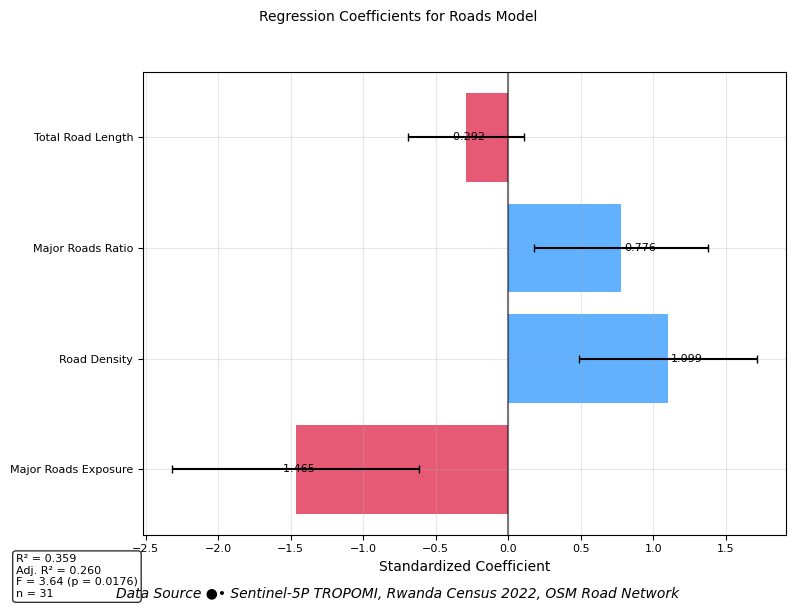

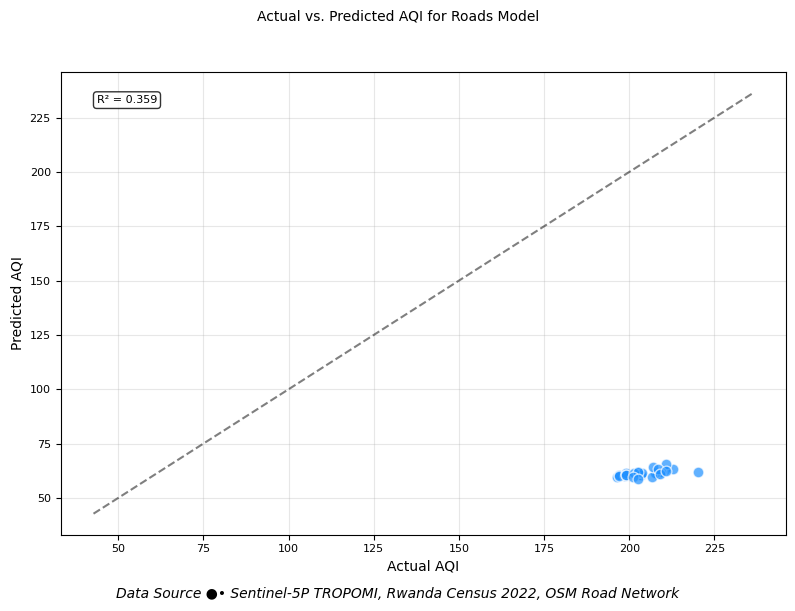

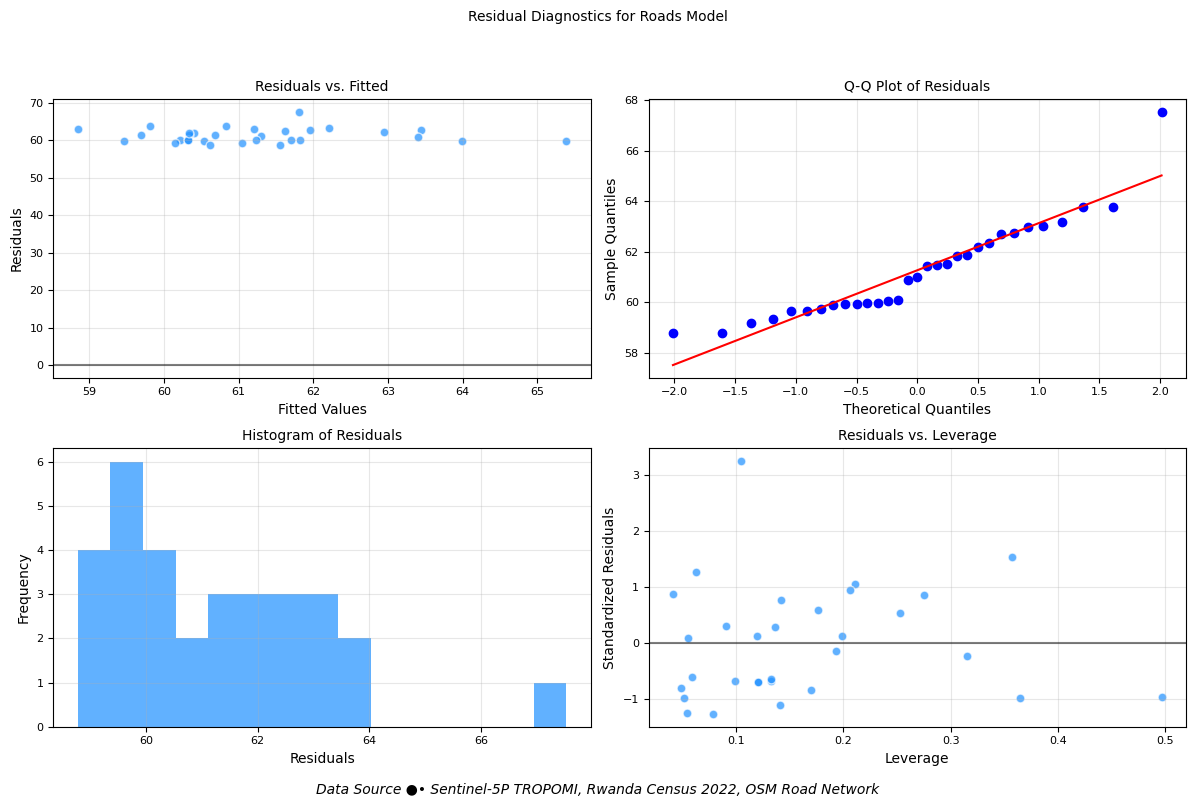

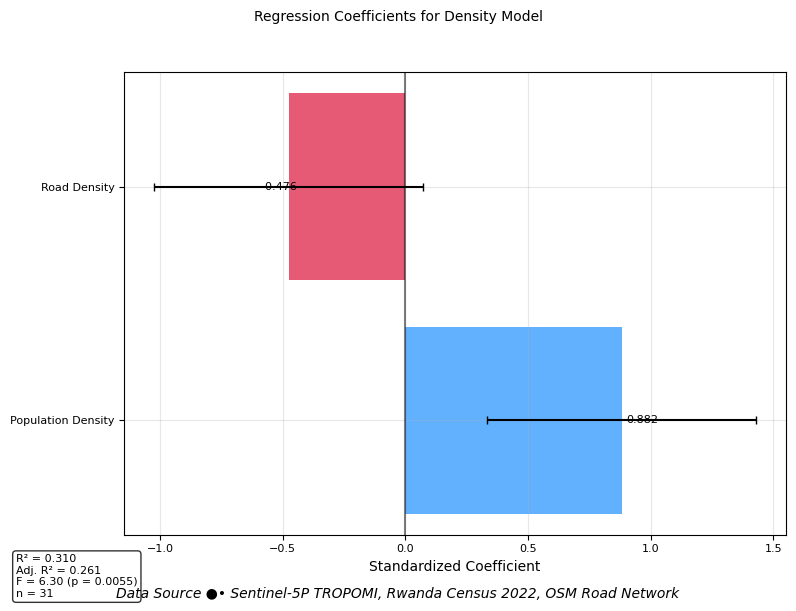

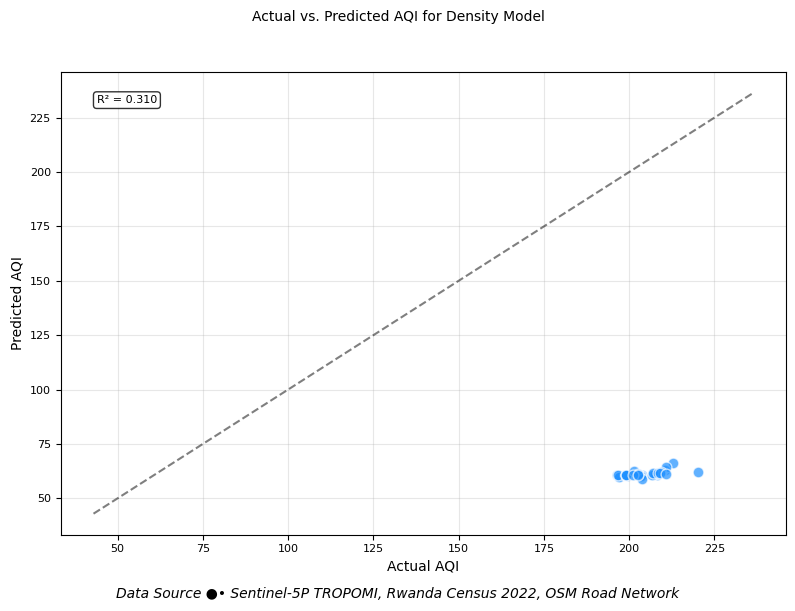

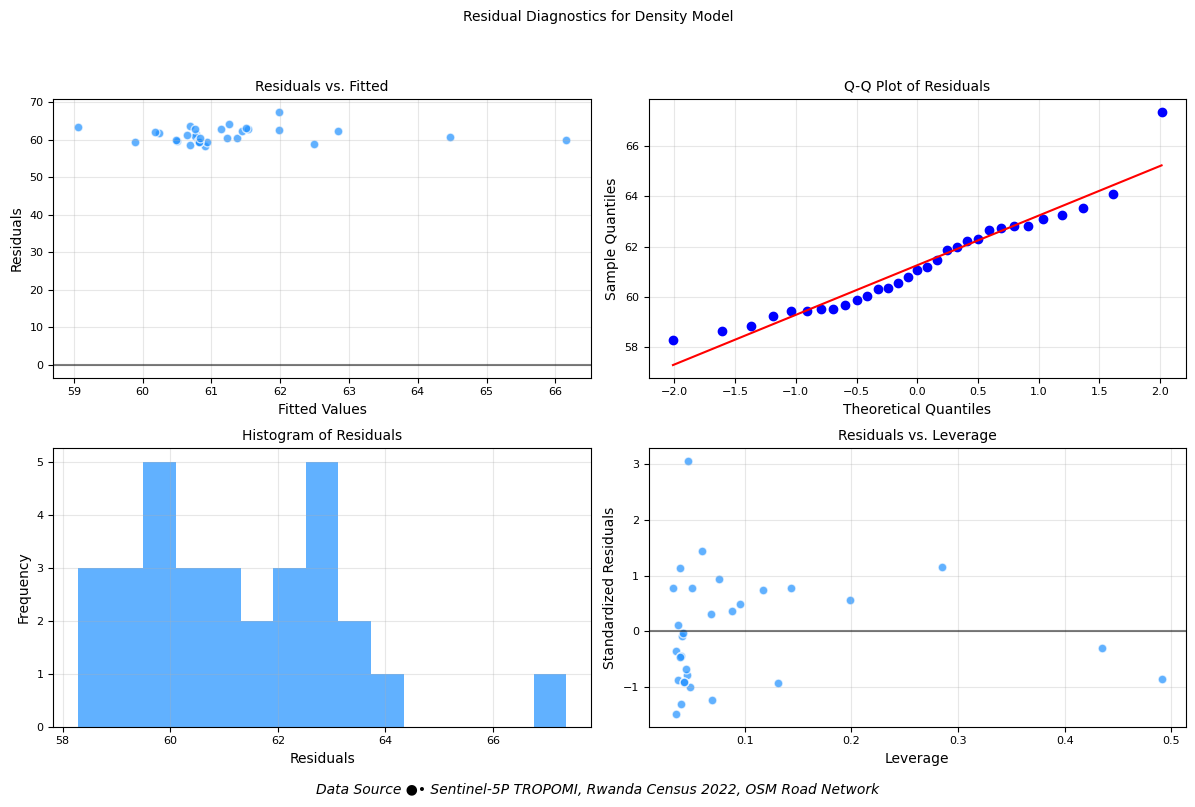

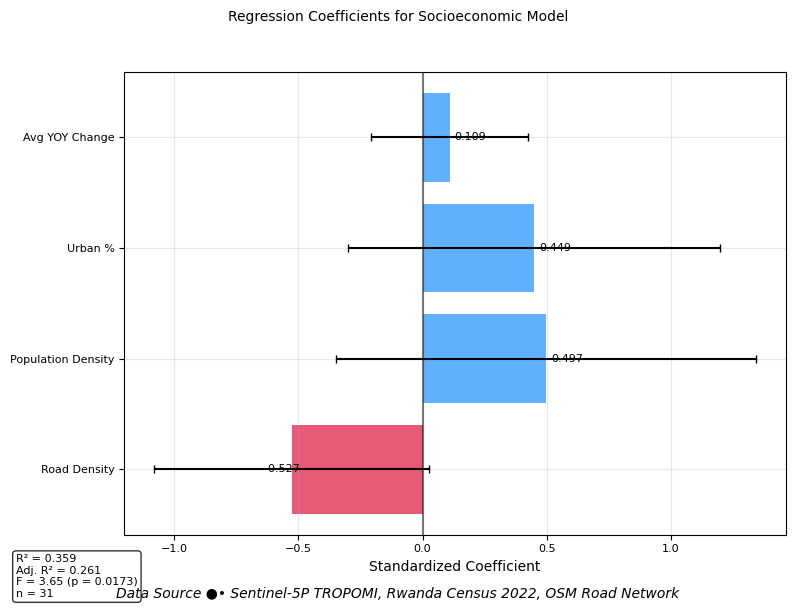

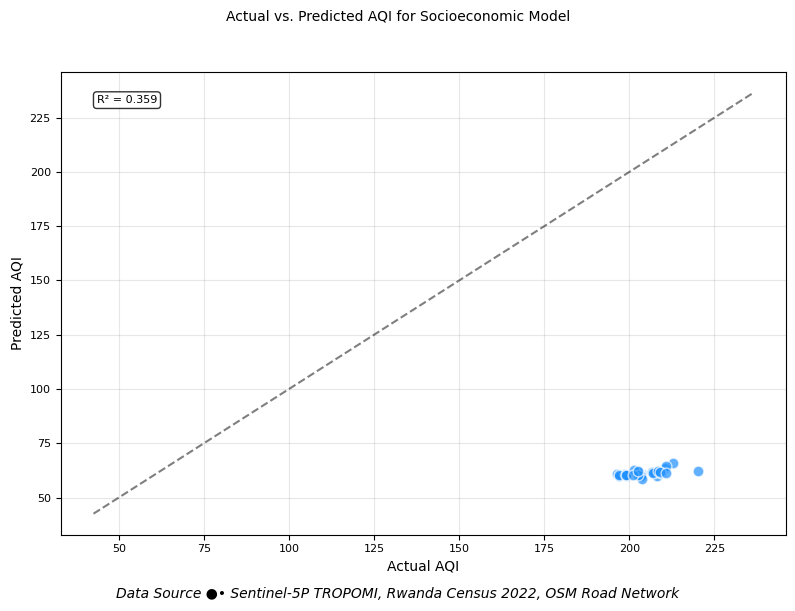

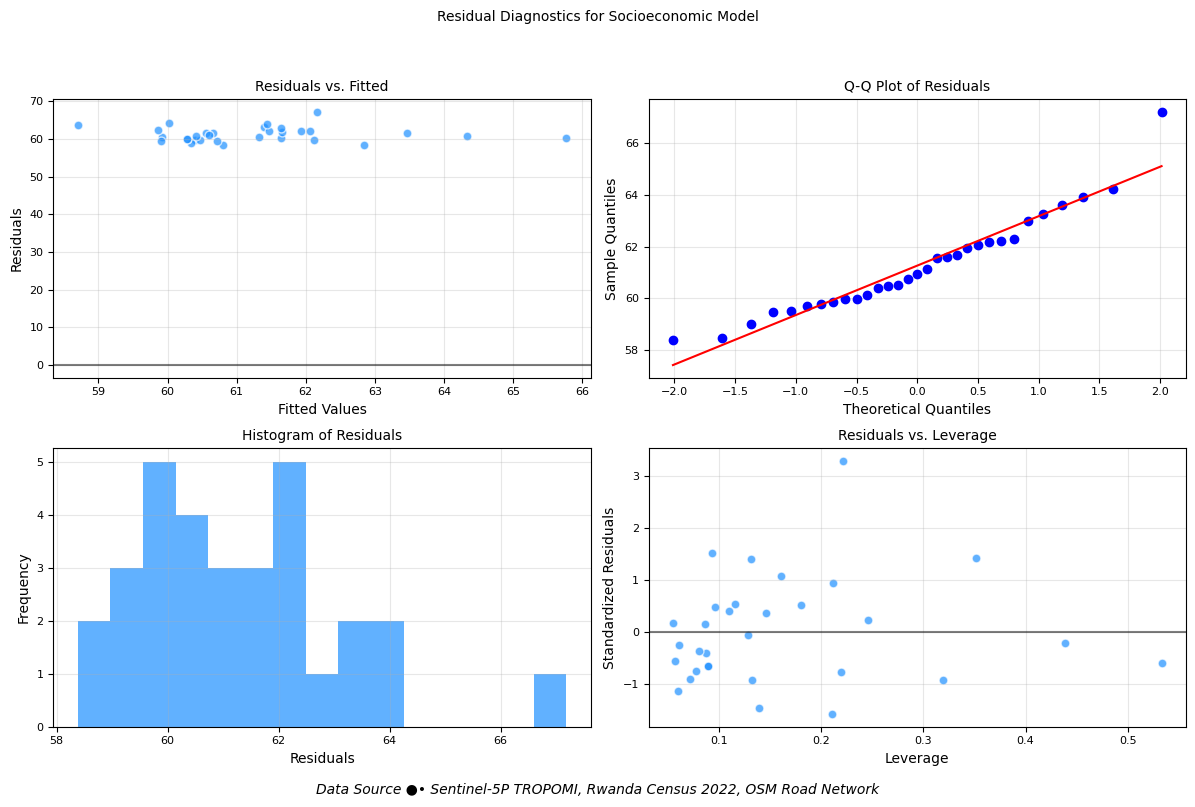

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import os
import logging
from datetime import datetime
from tabulate import tabulate

class RegressionAnalysis:
    def __init__(self, data_path='datasets/integrated_district_data.csv', output_dir='figures', 
                 log_dir='logs', analysis_name='regression_analysis'):
        # Setup directories
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
            
        # Setup logging
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = os.path.join(log_dir, f"{analysis_name}_{self.timestamp}.log")
        self.setup_logging(self.log_file)
        
        # Setup plotting style
        self.setup_plot_style()
        
        self.output_dir = output_dir
        self.data = pd.read_csv(data_path)
        self.models = {}
        
        logging.info(f"Loaded dataset with {len(self.data)} districts")
        
        # Identify key columns
        self.aqi_col = 'AQI_mean' if 'AQI_mean' in self.data.columns else None
        
        if not self.aqi_col:
            msg = "AQI column not found in dataset"
            logging.error(msg)
            raise ValueError(msg)
        
        logging.info(f"Using {self.aqi_col} as dependent variable")
    
    def setup_logging(self, log_file):
        # Clear any existing handlers
        for handler in logging.root.handlers[:]:
            logging.root.removeHandler(handler)
            
        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        logging.info(f"Logging setup")
    
    def setup_plot_style(self):
        # Set color scheme
        self.colors = {
            'primary': 'dodgerblue',
            'secondary': 'crimson',
            'tertiary': 'orange',
            'urban': 'crimson',
            'peri-urban': 'orange',
            'rural': 'dodgerblue',
            'regression': 'forestgreen',
            'pearson': 'dodgerblue',
            'spearman': 'forestgreen'
        }
        
        # Set up font and plot style
        plt.rcParams.update({
            'font.family': 'DejaVu Sans',
            'font.size': 8,
            'axes.titlesize': 10,
            'axes.labelsize': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'figure.figsize': (10, 6),
            'figure.dpi': 100,
            'savefig.dpi': 300,
            'axes.grid': True,
            'grid.alpha': 0.3
        })
    
    def clean_variable_name(self, var_name):
        clean_name = var_name.replace('_', ' ')
        if clean_name.lower() == 'aqi mean':
            return 'AQI'
        elif 'population density' in clean_name.lower():
            return 'Population Density'
        elif 'road density' in clean_name.lower():
            return 'Road Density'
        elif 'urban percentage' in clean_name.lower():
            return 'Urban %'
        elif 'major roads ratio' in clean_name.lower():
            return 'Major Roads Ratio'
        elif 'total road length m' in clean_name.lower():
            return 'Total Road Length'
        elif 'major roads exposure index' in clean_name.lower():
            return 'Major Roads Exposure'
        elif 'avg yoy change' in clean_name.lower():
            return 'Avg YOY Change'
        clean_name = ' '.join(word.capitalize() for word in clean_name.split())
        clean_name = clean_name.replace(' M Km2', '')
        clean_name = clean_name.replace(' Sqkm', '')
        return clean_name
    
    def calculate_vif(self, X):
        X_with_const = sm.add_constant(X)
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_with_const.columns
        vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
        return vif_data
    
    def fit_regression_model(self, model_name, predictors, standardize=True):
        predictors = [var for var in predictors if var in self.data.columns]
        logging.info(f"Fitting {model_name} regression model with predictors: {', '.join(predictors)}")
        
        # Drop rows with NaN values, retain urban_rural_type
        data_subset = self.data[[self.aqi_col] + predictors + ['urban_rural_type']].dropna()
        
        if len(data_subset) <= len(predictors) + 1:
            missing_vars = [var for var in predictors if self.data[var].isna().any()]
            logging.error(f"Not enough data points ({len(data_subset)}) for regression with {len(predictors)} predictors. Missing data in: {', '.join(missing_vars)}")
            return None
        
        # Create X and y
        X = data_subset[predictors]
        y = data_subset[self.aqi_col]
        
        # Check for multicollinearity
        vif_data = self.calculate_vif(X)
        logging.info("Variance Inflation Factors (VIF):")
        high_vif = []
        for i, row in vif_data.iterrows():
            if i > 0:  # Skip constant
                logging.info(f"  {row['Variable']}: {row['VIF']:.2f}")
                if row['VIF'] > 5:
                    high_vif.append((row['Variable'], row['VIF']))
        
        if high_vif:
            logging.warning("High multicollinearity detected:")
            for var, vif in high_vif:
                logging.warning(f"  {var}: VIF = {vif:.2f}")
        
        # Standardize variables
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
        X_for_model = pd.DataFrame(X_scaled, columns=predictors, index=X.index)
        y_for_model = pd.Series(y_scaled, index=X.index, name=self.aqi_col)
        
        # Add constant for statsmodels
        X_with_const = sm.add_constant(X_for_model)
        
        # Fit OLS model
        model = sm.OLS(y_for_model, X_with_const).fit()
        
        # Store model and related info
        self.models[model_name] = {
            'model': model,
            'predictors': predictors,
            'vif_data': vif_data,
            'standardized': True,
            'data_subset': data_subset,
            'X': X,
            'y': y,
            'X_with_const': X_with_const,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'y_scaled': y_for_model
        }
        
        return model
    
    def plot_coefficients(self, model_name, figsize=(8, 6)):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return None
        
        model_info = self.models[model_name]
        model = model_info['model']
        
        # Extract coefficients (excluding constant)
        coefs = model.params[1:]
        errors = model.bse[1:]
        var_names = [self.clean_variable_name(var) for var in coefs.index]
        
        # Sort by absolute coefficient value
        sorted_indices = np.argsort(np.abs(coefs.values))[::-1]
        coefs = coefs.values[sorted_indices]
        errors = errors.values[sorted_indices]
        var_names = [var_names[i] for i in sorted_indices]
        
        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle(f'Regression Coefficients for {model_name.capitalize()} Model', fontsize=10, y=0.99)
        
        # Create horizontal bar plot
        colors = [self.colors['primary'] if c > 0 else self.colors['secondary'] for c in coefs]
        bars = plt.barh(range(len(coefs)), coefs, color=colors, alpha=0.7)
        
        # Add error bars (95% CI)
        plt.errorbar(coefs, range(len(coefs)), xerr=errors*1.96, fmt='none', ecolor='black', capsize=3)
        
        # Add coefficient values
        for i, v in enumerate(coefs):
            plt.text(v + (0.02 if v >= 0 else -0.11), i, f"{v:.3f}", va='center', fontsize=8)
        
        # Format axes and labels
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        plt.yticks(range(len(coefs)), var_names)
        plt.xlabel('Standardized Coefficient', fontsize=10)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Add model stats annotation
        stats_text = (
            f"R² = {model.rsquared:.3f}\n"
            f"Adj. R² = {model.rsquared_adj:.3f}\n"
            f"F = {model.fvalue:.2f} (p = {model.f_pvalue:.4f})\n"
            f"n = {len(model_info['X'])}"
        )
        plt.annotate(stats_text, xy=(0.02, 0.02), xycoords='figure fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                    fontsize=8, ha='left', va='bottom')
        
        # Add data source note
        plt.figtext(0.5, 0.01, 
                   'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                   ha='center', fontsize=10, style='italic')
        
        # Save figure
        file_path = os.path.join(self.output_dir, f"regression_coefficients_{model_name}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved regression coefficients plot")
        
        return plt.gcf()
    
    def plot_actual_vs_predicted(self, model_name, figsize=(8, 6)):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return None
        
        model_info = self.models[model_name]
        model = model_info['model']
        X = model_info['X_with_const']
        y = model_info['y']
        scaler_y = model_info['scaler_y']
        
        # Calculate predicted values
        y_pred = model.predict(X)
        
        # Convert to numpy arrays if necessary
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy()
        
        # Inverse transform if standardized
        if model_info['standardized'] and scaler_y is not None:
            y = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
            y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        
        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle(f'Actual vs. Predicted AQI for {model_name.capitalize()} Model', fontsize=10, y=0.99)
        
        # Create scatter plot
        plt.scatter(y, y_pred, alpha=0.7, edgecolor='w', s=60, color=self.colors['primary'])
        
        # Add identity line
        max_val = max(y.max(), y_pred.max())
        min_val = min(y.min(), y_pred.min())
        padding = (max_val - min_val) * 0.1
        plt.plot([min_val - padding, max_val + padding], [min_val - padding, max_val + padding], 
                '--', color='black', alpha=0.5)
        
        # Add R-squared annotation
        r_squared = model.rsquared
        plt.annotate(f"R² = {r_squared:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                    fontsize=8, ha='left', va='top')
        
        # Format axes and labels
        plt.xlabel('Actual AQI', fontsize=10)
        plt.ylabel('Predicted AQI', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Add data source note
        plt.figtext(0.5, 0.01, 
                   'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                   ha='center', fontsize=10, style='italic')
        
        # Save figure
        file_path = os.path.join(self.output_dir, f"actual_vs_predicted_{model_name}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved actual vs. predicted plot")
        
        return plt.gcf()
    
    def plot_residuals(self, model_name, figsize=(12, 8)):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return None
        
        model_info = self.models[model_name]
        model = model_info['model']
        X = model_info['X_with_const']
        y = model_info['y_scaled']
        scaler_y = model_info['scaler_y']
        
        # Calculate predicted values and residuals
        y_pred = model.predict(X)
        residuals = y - y_pred
        
        # Convert to numpy arrays if necessary
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy()
        if isinstance(residuals, pd.Series):
            residuals = residuals.to_numpy()
        
        # Inverse transform residuals if standardized
        if model_info['standardized'] and scaler_y is not None:
            residuals = scaler_y.inverse_transform(residuals.reshape(-1, 1)).flatten()
            y = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
            y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        
        # Create plot with subplots
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'Residual Diagnostics for {model_name.capitalize()} Model', fontsize=10, y=0.99)
        
        # 1. Residuals vs. Fitted Values
        axes[0, 0].scatter(y_pred, residuals, alpha=0.7, edgecolor='w', s=40, color=self.colors['primary'])
        axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[0, 0].set_xlabel('Fitted Values', fontsize=10)
        axes[0, 0].set_ylabel('Residuals', fontsize=10)
        axes[0, 0].set_title('Residuals vs. Fitted', fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Q-Q Plot of Residuals
        from scipy import stats
        stats.probplot(residuals, dist="norm", plot=axes[0, 1])
        axes[0, 1].set_xlabel('Theoretical Quantiles', fontsize=10)
        axes[0, 1].set_ylabel('Sample Quantiles', fontsize=10)
        axes[0, 1].set_title('Q-Q Plot of Residuals', fontsize=10)
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Histogram of Residuals
        axes[1, 0].hist(residuals, bins=15, alpha=0.7, color=self.colors['primary'])
        axes[1, 0].set_xlabel('Residuals', fontsize=10)
        axes[1, 0].set_ylabel('Frequency', fontsize=10)
        axes[1, 0].set_title('Histogram of Residuals', fontsize=10)
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Residuals vs. Leverage
        influence = model.get_influence()
        leverage = influence.hat_matrix_diag
        standardized_residuals = influence.resid_studentized_internal
        axes[1, 1].scatter(leverage, standardized_residuals, alpha=0.7, edgecolor='w', s=40, color=self.colors['primary'])
        axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
        axes[1, 1].set_xlabel('Leverage', fontsize=10)
        axes[1, 1].set_ylabel('Standardized Residuals', fontsize=10)
        axes[1, 1].set_title('Residuals vs. Leverage', fontsize=10)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Add data source note
        plt.figtext(0.5, 0.01, 
                   'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                   ha='center', fontsize=10, style='italic')
        
        # Save figure
        file_path = os.path.join(self.output_dir, f"residual_diagnostics_{model_name}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved residual diagnostics plot")
        
        return fig
    
    def display_model_performance(self, model_names):
        if not all(name in self.models for name in model_names):
            missing = [name for name in model_names if name not in self.models]
            logging.error(f"Models not found: {', '.join(missing)}")
            return
        
        # Create comparison DataFrame
        comparison_data = []
        for name in model_names:
            model = self.models[name]['model']
            significant_vars = sum(p < 0.05 for p in model.pvalues[1:])
            metrics = {
                'Model': name,
                'R-squared': f"{model.rsquared:.3f}",
                'Adj. R-squared': f"{model.rsquared_adj:.3f}",
                'AIC': f"{model.aic:.1f}",
                'BIC': f"{model.bic:.1f}",
                'Significant Vars (p < 0.05)': significant_vars,
                'Total Vars': len(model.params) - 1,
                'Observations': int(model.nobs)
            }
            comparison_data.append(metrics)
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Display using tabulate
        print("\nModel Performance Summary:")
        print(tabulate(comparison_df, headers='keys', tablefmt='psql', showindex=False))
    
    def run_full_analysis(self):
        logging.info("Starting regression analysis")
        
        results = {}
        
        # 1. Roads model
        roads_vars = [
            'road_density_m_km2',
            'major_roads_ratio',
            'total_road_length_m',
            'major_roads_exposure_index'
        ]
        roads_model = self.fit_regression_model('roads', roads_vars, standardize=True)
        results['roads_model'] = roads_model
        
        # 2. Density model
        density_vars = [
            'population_density',
            'road_density_m_km2'
        ]
        density_model = self.fit_regression_model('density', density_vars, standardize=True)
        results['density_model'] = density_model
        
        # 3. Socioeconomic model (poverty_index not available)
        socio_vars = [
            'population_density',
            'road_density_m_km2',
            'urban_percentage',
            'avg_yoy_change'
        ]
        logging.info("Note: Poverty index not found in dataset; using other socioeconomic metrics")
        socio_model = self.fit_regression_model('socioeconomic', socio_vars, standardize=True)
        results['socioeconomic_model'] = socio_model
        
        # 4. Create visualizations for each model
        for model_name in self.models:
            # Plot regression coefficients
            results[f"{model_name}_coefficients"] = self.plot_coefficients(model_name)
            
            # Plot actual vs predicted
            results[f"{model_name}_predicted"] = self.plot_actual_vs_predicted(model_name)
            
            # Plot residual diagnostics
            results[f"{model_name}_residuals"] = self.plot_residuals(model_name)
        
        # 5. Display model performance
        self.display_model_performance(['roads', 'density', 'socioeconomic'])
        
        logging.info("Regression analysis completed")
        return results

if __name__ == "__main__":
    regression_analysis = RegressionAnalysis()
    results = regression_analysis.run_full_analysis()

2025-04-19 19:40:47,206 - INFO - Logging setup
2025-04-19 19:40:47,220 - INFO - Loaded dataset with 31 districts
2025-04-19 19:40:47,222 - INFO - Using AQI_mean as dependent variable
2025-04-19 19:40:47,222 - INFO - Starting regression analysis
2025-04-19 19:40:47,232 - INFO - Fitting roads regression model with predictors: road_density_m_km2, major_roads_ratio, total_road_length_m, major_roads_exposure_index
2025-04-19 19:40:47,277 - INFO - Variance Inflation Factors (VIF):
2025-04-19 19:40:47,285 - INFO -   road_density_m_km2: 3.96
2025-04-19 19:40:47,285 - INFO -   major_roads_ratio: 3.79
2025-04-19 19:40:47,285 - INFO -   total_road_length_m: 1.67
2025-04-19 19:40:47,292 - INFO -   major_roads_exposure_index: 7.65
2025-04-19 19:40:47,292 - WARNING - High multicollinearity detected:
2025-04-19 19:40:47,297 - WARNING -   major_roads_exposure_index: VIF = 7.65
2025-04-19 19:40:47,312 - INFO - Fitting density regression model with predictors: population_density, road_density_m_km2
2025


Model Performance Summary:
+---------------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------+
| Model         |   R-squared |   Adj. R-squared |   AIC |   BIC |   Significant Vars (p < 0.05) |   Total Vars |   Observations |
|---------------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------|
| roads         |       0.359 |            0.26  |  84.2 |  91.4 |                             3 |            4 |             31 |
| density       |       0.31  |            0.261 |  82.4 |  86.8 |                             1 |            2 |             31 |
| socioeconomic |       0.359 |            0.261 |  84.2 |  91.3 |                             0 |            4 |             31 |
+---------------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------+


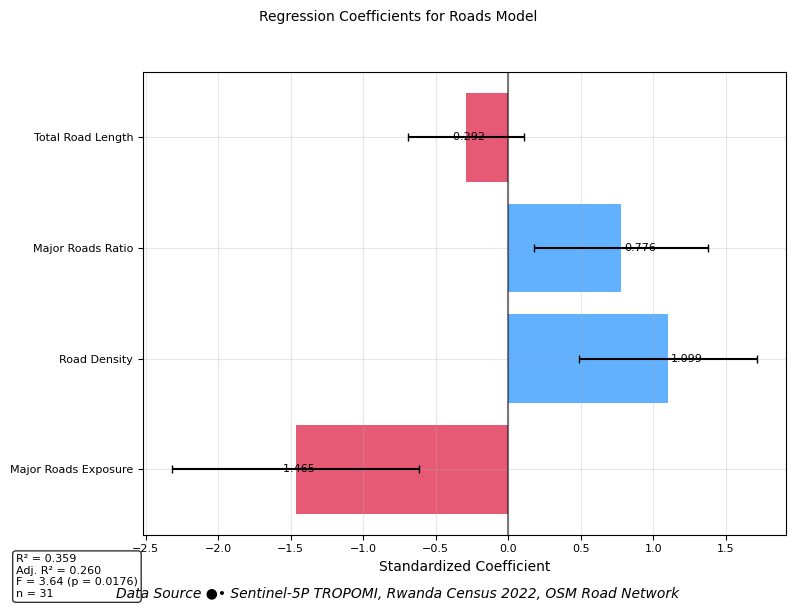

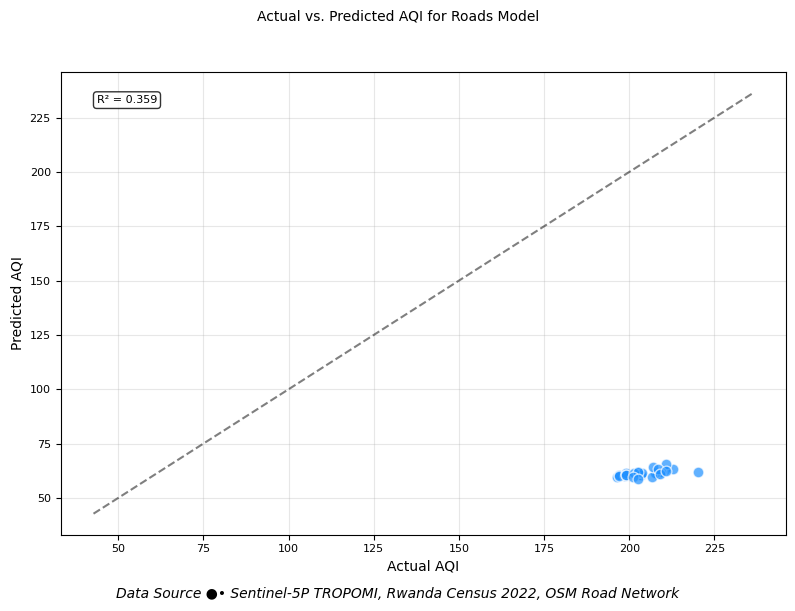

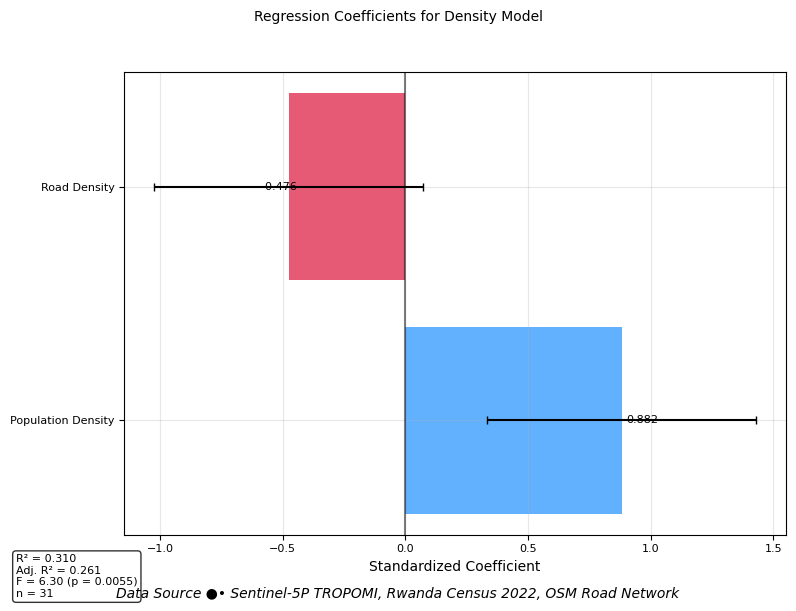

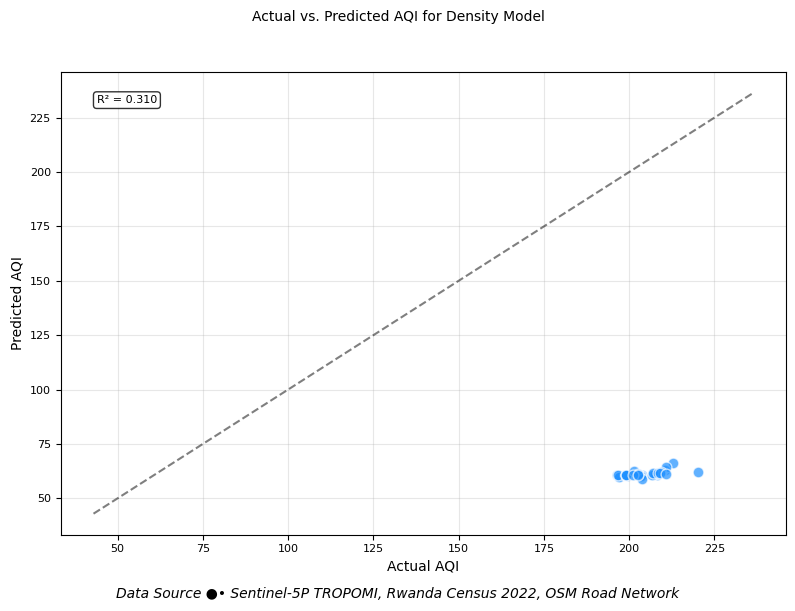

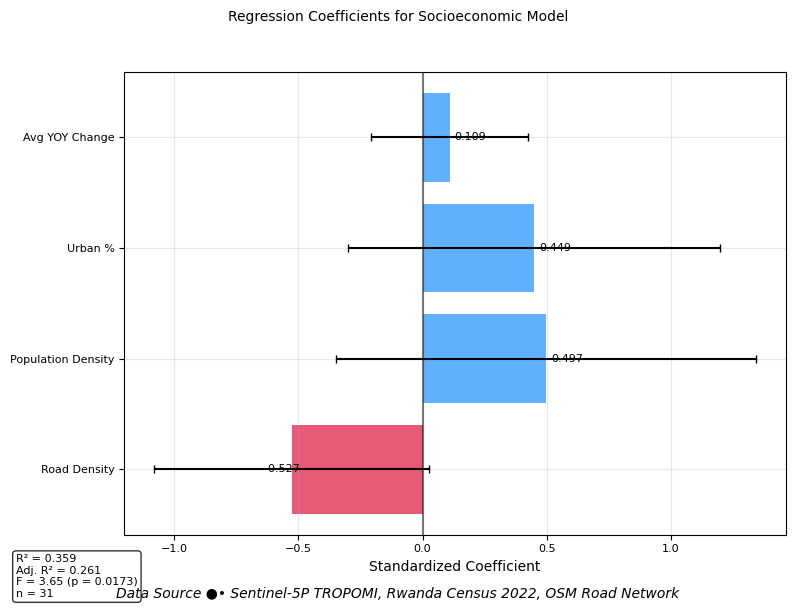

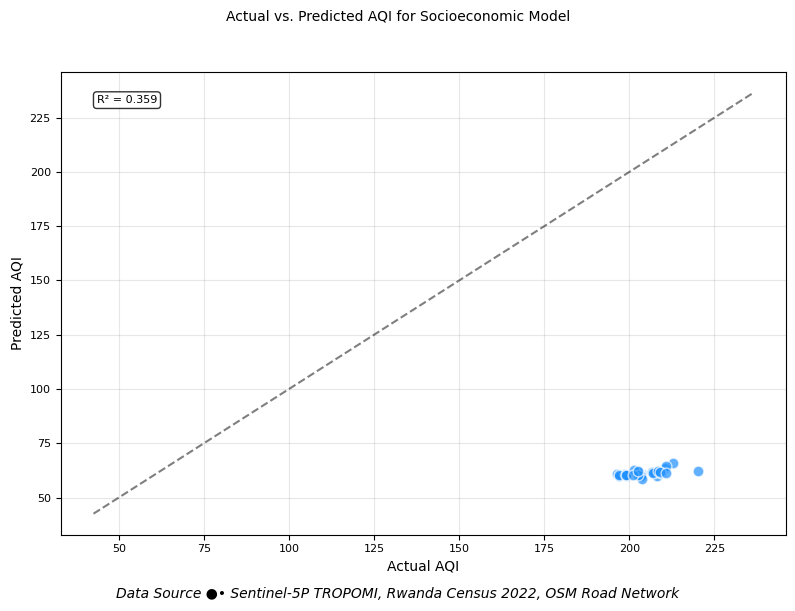

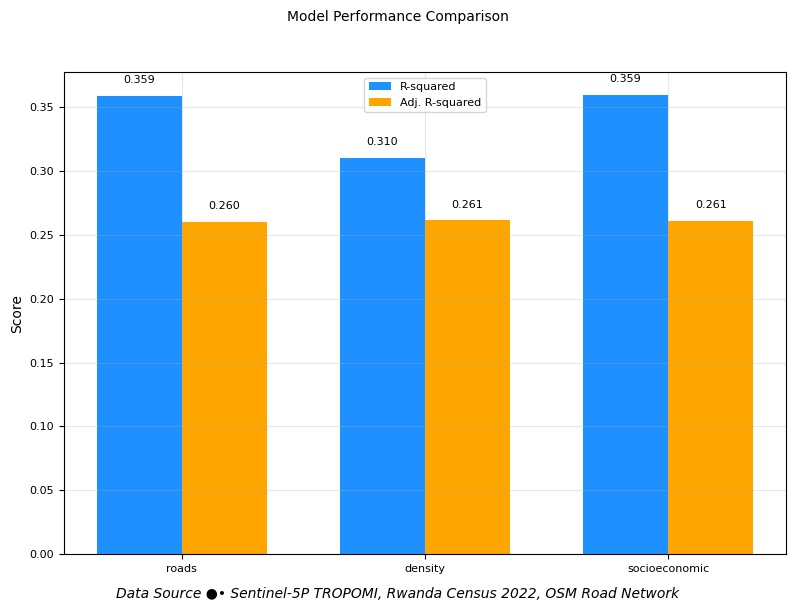

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import os
import logging
from datetime import datetime
from tabulate import tabulate


class RegressionAnalysis:
    def __init__(self, data_path='datasets/integrated_district_data.csv', output_dir='figures',
                 log_dir='logs', analysis_name='regression_analysis'):
        # Setup directories
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)

        # Setup logging
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = os.path.join(
            log_dir, f"{analysis_name}_{self.timestamp}.log")
        self.setup_logging(self.log_file)

        # Setup plotting style
        self.setup_plot_style()

        self.output_dir = output_dir
        self.data = pd.read_csv(data_path)
        self.models = {}

        logging.info(f"Loaded dataset with {len(self.data)} districts")

        # Identify key columns
        self.aqi_col = 'AQI_mean' if 'AQI_mean' in self.data.columns else None

        if not self.aqi_col:
            msg = "AQI column not found in dataset"
            logging.error(msg)
            raise ValueError(msg)

        logging.info(f"Using {self.aqi_col} as dependent variable")

    def setup_logging(self, log_file):
        # Clear any existing handlers
        for handler in logging.root.handlers[:]:
            logging.root.removeHandler(handler)

        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        logging.info(f"Logging setup")

    def setup_plot_style(self):
        # Set color scheme
        self.colors = {
            'primary': 'dodgerblue',
            'secondary': 'crimson',
            'tertiary': 'orange',
            'urban': 'crimson',
            'peri-urban': 'orange',
            'rural': 'dodgerblue',
            'regression': 'forestgreen',
            'pearson': 'dodgerblue',
            'spearman': 'forestgreen'
        }

        # Set up font and plot style
        plt.rcParams.update({
            'font.family': 'DejaVu Sans',
            'font.size': 8,
            'axes.titlesize': 10,
            'axes.labelsize': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'figure.figsize': (10, 6),
            'figure.dpi': 100,
            'savefig.dpi': 300,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def clean_variable_name(self, var_name):
        clean_name = var_name.replace('_', ' ')
        if clean_name.lower() == 'aqi mean':
            return 'AQI'
        elif 'population density' in clean_name.lower():
            return 'Population Density'
        elif 'road density' in clean_name.lower():
            return 'Road Density'
        elif 'urban percentage' in clean_name.lower():
            return 'Urban %'
        elif 'major roads ratio' in clean_name.lower():
            return 'Major Roads Ratio'
        elif 'total road length m' in clean_name.lower():
            return 'Total Road Length'
        elif 'major roads exposure index' in clean_name.lower():
            return 'Major Roads Exposure'
        elif 'avg yoy change' in clean_name.lower():
            return 'Avg YOY Change'
        clean_name = ' '.join(word.capitalize() for word in clean_name.split())
        clean_name = clean_name.replace(' M Km2', '')
        clean_name = clean_name.replace(' Sqkm', '')
        return clean_name

    def calculate_vif(self, X):
        X_with_const = sm.add_constant(X)
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_with_const.columns
        vif_data["VIF"] = [variance_inflation_factor(
            X_with_const.values, i) for i in range(X_with_const.shape[1])]
        return vif_data

    def fit_regression_model(self, model_name, predictors, standardize=True):
        predictors = [var for var in predictors if var in self.data.columns]
        logging.info(
            f"Fitting {model_name} regression model with predictors: {', '.join(predictors)}")

        # Drop rows with NaN values
        data_subset = self.data[[self.aqi_col] + predictors].dropna()

        if len(data_subset) <= len(predictors) + 1:
            missing_vars = [
                var for var in predictors if self.data[var].isna().any()]
            logging.error(
                f"Not enough data points ({len(data_subset)}) for regression with {len(predictors)} predictors. Missing data in: {', '.join(missing_vars)}")
            return None

        # Create X and y
        X = data_subset[predictors]
        y = data_subset[self.aqi_col]

        # Check for multicollinearity
        vif_data = self.calculate_vif(X)
        logging.info("Variance Inflation Factors (VIF):")
        high_vif = []
        for i, row in vif_data.iterrows():
            if i > 0:  # Skip constant
                logging.info(f"  {row['Variable']}: {row['VIF']:.2f}")
                if row['VIF'] > 5:
                    high_vif.append((row['Variable'], row['VIF']))

        if high_vif:
            logging.warning("High multicollinearity detected:")
            for var, vif in high_vif:
                logging.warning(f"  {var}: VIF = {vif:.2f}")

        # Standardize variables
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
        X_for_model = pd.DataFrame(X_scaled, columns=predictors, index=X.index)
        y_for_model = pd.Series(y_scaled, index=X.index, name=self.aqi_col)

        # Add constant for statsmodels
        X_with_const = sm.add_constant(X_for_model)

        # Fit OLS model
        model = sm.OLS(y_for_model, X_with_const).fit()

        # Store model and related info
        self.models[model_name] = {
            'model': model,
            'predictors': predictors,
            'vif_data': vif_data,
            'standardized': True,
            'data_subset': data_subset,
            'X': X,
            'y': y,
            'X_with_const': X_with_const,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'y_scaled': y_for_model
        }

        return model

    def plot_coefficients(self, model_name, figsize=(8, 6)):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return None

        model_info = self.models[model_name]
        model = model_info['model']

        # Extract coefficients (excluding constant)
        coefs = model.params[1:]
        errors = model.bse[1:]
        var_names = [self.clean_variable_name(var) for var in coefs.index]

        # Sort by absolute coefficient value
        sorted_indices = np.argsort(np.abs(coefs.values))[::-1]
        coefs = coefs.values[sorted_indices]
        errors = errors.values[sorted_indices]
        var_names = [var_names[i] for i in sorted_indices]

        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle(
            f'Regression Coefficients for {model_name.capitalize()} Model', fontsize=10, y=0.99)

        # Create horizontal bar plot
        colors = [self.colors['primary'] if c >
                  0 else self.colors['secondary'] for c in coefs]
        bars = plt.barh(range(len(coefs)), coefs, color=colors, alpha=0.7)

        # Add error bars (95% CI)
        plt.errorbar(coefs, range(len(coefs)), xerr=errors *
                     1.96, fmt='none', ecolor='black', capsize=3)

        # Add coefficient values
        for i, v in enumerate(coefs):
            plt.text(v + (0.02 if v >= 0 else -0.11), i,
                     f"{v:.3f}", va='center', fontsize=8)

        # Format axes and labels
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        plt.yticks(range(len(coefs)), var_names)
        plt.xlabel('Standardized Coefficient', fontsize=10)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add model stats annotation
        stats_text = (
            f"R² = {model.rsquared:.3f}\n"
            f"Adj. R² = {model.rsquared_adj:.3f}\n"
            f"F = {model.fvalue:.2f} (p = {model.f_pvalue:.4f})\n"
            f"n = {len(model_info['X'])}"
        )
        plt.annotate(stats_text, xy=(0.02, 0.02), xycoords='figure fraction',
                     bbox=dict(boxstyle="round,pad=0.3",
                               facecolor='white', alpha=0.8),
                     fontsize=8, ha='left', va='bottom')

        # Add data source note
        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        # Save figure
        file_path = os.path.join(
            self.output_dir, f"regression_coefficients_{model_name}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved regression coefficients plot")

        return plt.gcf()

    def plot_actual_vs_predicted(self, model_name, figsize=(8, 6)):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return None

        model_info = self.models[model_name]
        model = model_info['model']
        X = model_info['X_with_const']
        y = model_info['y']
        scaler_y = model_info['scaler_y']

        # Calculate predicted values
        y_pred = model.predict(X)

        # Convert to numpy arrays if necessary
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy()

        # Inverse transform if standardized
        if model_info['standardized'] and scaler_y is not None:
            y = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
            y_pred = scaler_y.inverse_transform(
                y_pred.reshape(-1, 1)).flatten()

        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle(
            f'Actual vs. Predicted AQI for {model_name.capitalize()} Model', fontsize=10, y=0.99)

        # Create scatter plot
        plt.scatter(y, y_pred, alpha=0.7, edgecolor='w',
                    s=60, color=self.colors['primary'])

        # Add identity line
        max_val = max(y.max(), y_pred.max())
        min_val = min(y.min(), y_pred.min())
        padding = (max_val - min_val) * 0.1
        plt.plot([min_val - padding, max_val + padding], [min_val - padding, max_val + padding],
                 '--', color='black', alpha=0.5)

        # Add R-squared annotation
        r_squared = model.rsquared
        plt.annotate(f"R² = {r_squared:.3f}", xy=(0.05, 0.95), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3",
                               facecolor='white', alpha=0.8),
                     fontsize=8, ha='left', va='top')

        # Format axes and labels
        plt.xlabel('Actual AQI', fontsize=10)
        plt.ylabel('Predicted AQI', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add data source note
        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        # Save figure
        file_path = os.path.join(
            self.output_dir, f"actual_vs_predicted_{model_name}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved actual vs. predicted plot")

        return plt.gcf()

    def plot_performance_comparison(self, model_names, figsize=(8, 6)):
        if not all(name in self.models for name in model_names):
            missing = [name for name in model_names if name not in self.models]
            logging.error(f"Models not found: {', '.join(missing)}")
            return None

        # Create comparison DataFrame
        comparison_data = []
        for name in model_names:
            model = self.models[name]['model']
            comparison_data.append({
                'Model': name,
                'R-squared': model.rsquared,
                'Adj. R-squared': model.rsquared_adj
            })

        comparison_df = pd.DataFrame(comparison_data)

        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle('Model Performance Comparison', fontsize=10, y=0.99)

        # Bar positions
        bar_width = 0.35
        x = np.arange(len(model_names))

        # Plot bars for R-squared and Adjusted R-squared
        plt.bar(x - bar_width/2, comparison_df['R-squared'], bar_width, label='R-squared',
                color=self.colors['primary'])
        plt.bar(x + bar_width/2, comparison_df['Adj. R-squared'], bar_width, label='Adj. R-squared',
                color=self.colors['tertiary'])

        # Add values on top of bars
        for i, v in enumerate(comparison_df['R-squared']):
            plt.text(i - bar_width/2, v + 0.01,
                     f"{v:.3f}", ha='center', fontsize=8)
        for i, v in enumerate(comparison_df['Adj. R-squared']):
            plt.text(i + bar_width/2, v + 0.01,
                     f"{v:.3f}", ha='center', fontsize=8)

        # Format axes and labels
        plt.xticks(x, model_names)
        plt.ylabel('Score', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add data source note
        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        # Save figure
        file_path = os.path.join(
            self.output_dir, f"performance_comparison_{'-'.join(model_names)}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved performance comparison plot")

        return plt.gcf()

    def display_model_performance(self, model_names):
        if not all(name in self.models for name in model_names):
            missing = [name for name in model_names if name not in self.models]
            logging.error(f"Models not found: {', '.join(missing)}")
            return

        # Create comparison DataFrame
        comparison_data = []
        for name in model_names:
            model = self.models[name]['model']
            significant_vars = sum(p < 0.05 for p in model.pvalues[1:])
            metrics = {
                'Model': name,
                'R-squared': f"{model.rsquared:.3f}",
                'Adj. R-squared': f"{model.rsquared_adj:.3f}",
                'AIC': f"{model.aic:.1f}",
                'BIC': f"{model.bic:.1f}",
                'Significant Vars (p < 0.05)': significant_vars,
                'Total Vars': len(model.params) - 1,
                'Observations': int(model.nobs)
            }
            comparison_data.append(metrics)

        comparison_df = pd.DataFrame(comparison_data)

        # Display using tabulate
        print("\nModel Performance Summary:")
        print(tabulate(comparison_df, headers='keys',
              tablefmt='psql', showindex=False))

    def run_full_analysis(self):
        logging.info("Starting regression analysis")

        results = {}

        # 1. Roads model
        roads_vars = [
            'road_density_m_km2',
            'major_roads_ratio',
            'total_road_length_m',
            'major_roads_exposure_index'
        ]
        roads_model = self.fit_regression_model(
            'roads', roads_vars, standardize=True)
        results['roads_model'] = roads_model

        # 2. Density model
        density_vars = [
            'population_density',
            'road_density_m_km2'
        ]
        density_model = self.fit_regression_model(
            'density', density_vars, standardize=True)
        results['density_model'] = density_model

        # 3. Socioeconomic model (poverty_index not available)
        socio_vars = [
            'population_density',
            'road_density_m_km2',
            'urban_percentage',
            'avg_yoy_change'
        ]
        logging.info(
            "Note: Poverty index not found in dataset; using other socioeconomic metrics")
        socio_model = self.fit_regression_model(
            'socioeconomic', socio_vars, standardize=True)
        results['socioeconomic_model'] = socio_model

        # 4. Create top 2 plots for each model
        for model_name in self.models:
            # Plot regression coefficients
            results[f"{model_name}_coefficients"] = self.plot_coefficients(
                model_name)

            # Plot actual vs predicted
            results[f"{model_name}_predicted"] = self.plot_actual_vs_predicted(
                model_name)

        # 5. Plot performance comparison
        results["performance_comparison"] = self.plot_performance_comparison(
            ['roads', 'density', 'socioeconomic'])

        # 6. Display model performance
        self.display_model_performance(['roads', 'density', 'socioeconomic'])

        logging.info("Regression analysis completed")
        return results


if __name__ == "__main__":
    regression_analysis = RegressionAnalysis()
    results = regression_analysis.run_full_analysis()

2025-04-19 20:37:56,109 - INFO - Logging setup
2025-04-19 20:37:56,166 - INFO - Loaded dataset with 31 districts
2025-04-19 20:37:56,168 - INFO - Using AQI_mean as dependent variable
2025-04-19 20:37:56,175 - INFO - Starting regression analysis
2025-04-19 20:37:56,177 - INFO - Fitting full regression model with predictors: road_density_m_km2, population_density, urban_percentage, major_roads_ratio, total_road_length_m, major_roads_exposure_index, avg_yoy_change
2025-04-19 20:37:56,207 - INFO - Variance Inflation Factors (VIF):
2025-04-19 20:37:56,208 - INFO -   road_density_m_km2: 14.29
2025-04-19 20:37:56,208 - INFO -   population_density: 22.59
2025-04-19 20:37:56,208 - INFO -   urban_percentage: 9.88
2025-04-19 20:37:56,208 - INFO -   major_roads_ratio: 7.75
2025-04-19 20:37:56,208 - INFO -   total_road_length_m: 3.33
2025-04-19 20:37:56,208 - INFO -   major_roads_exposure_index: 12.84
2025-04-19 20:37:56,224 - INFO -   avg_yoy_change: 2.06
2025-04-19 20:37:56,224 - WARNING - High m


Model Performance Summary:
+---------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------+
| Model   |   R-squared |   Adj. R-squared |   AIC |   BIC |   Significant Vars (p < 0.05) |   Total Vars |   Observations |
|---------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------|
| full    |       0.495 |            0.342 |  82.8 |  94.3 |                             2 |            7 |             31 |
| best    |       0     |           -0.034 |  92   |  94.8 |                             0 |            1 |             31 |
+---------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------+


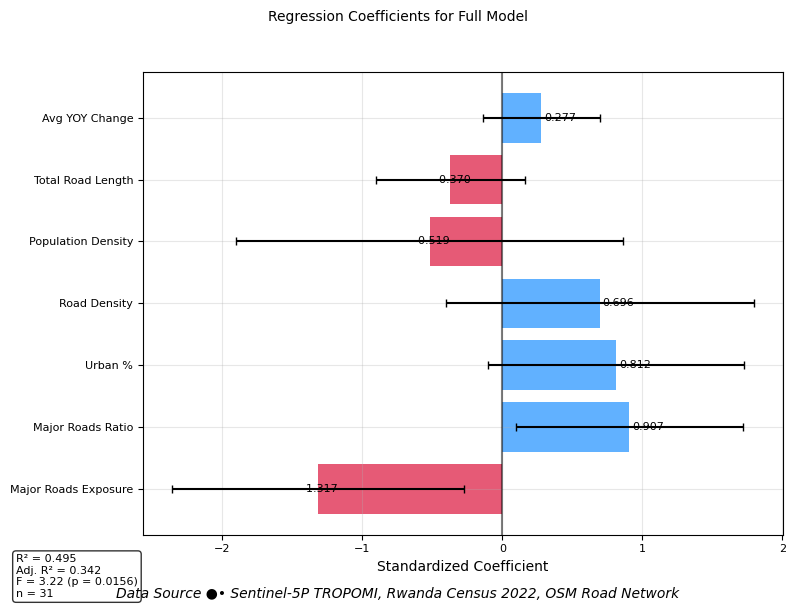

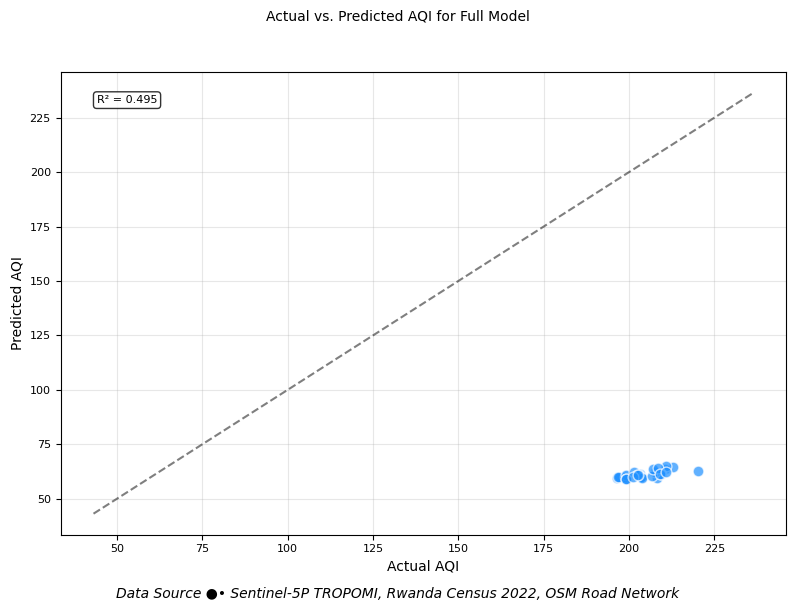

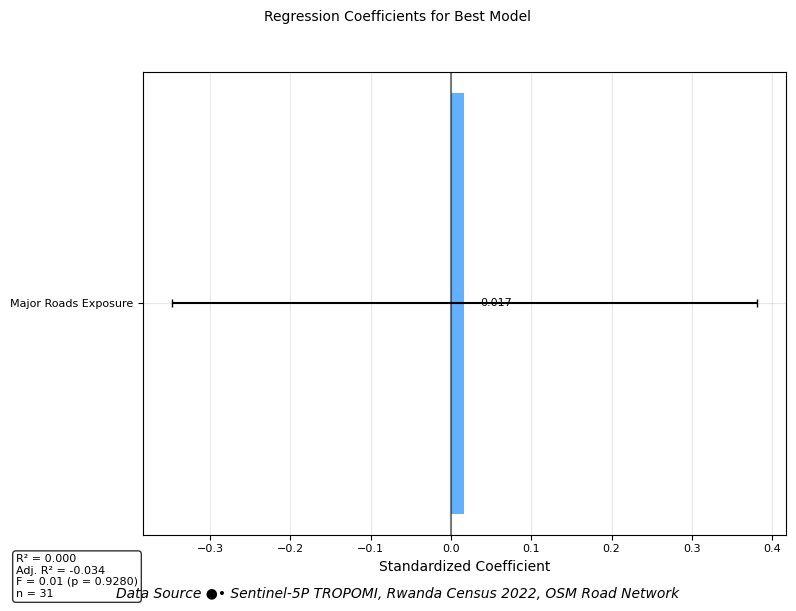

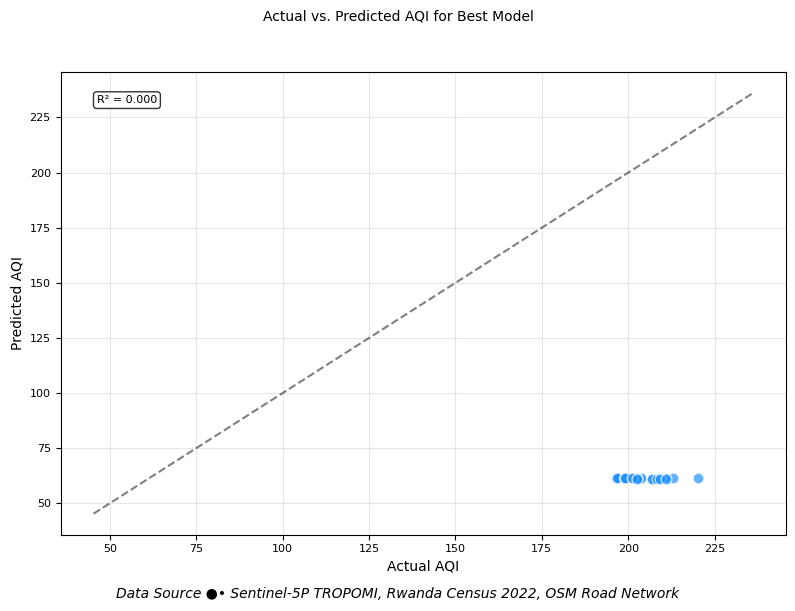

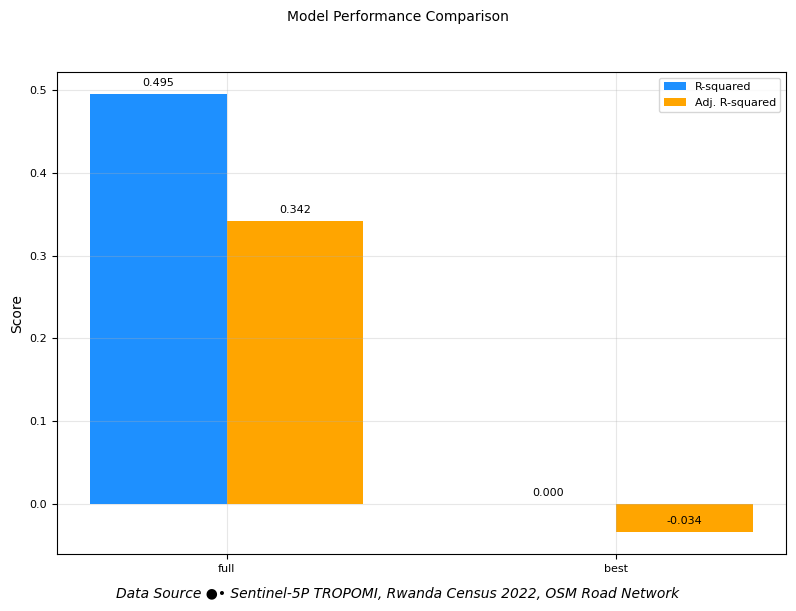

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import os
import logging
from datetime import datetime
from tabulate import tabulate


class RegressionAnalysis:
    def __init__(self, data_path='datasets/integrated_district_data.csv', output_dir='figures',
                 log_dir='logs', analysis_name='regression_analysis'):
        # Setup directories
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)

        # Setup logging
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = os.path.join(
            log_dir, f"{analysis_name}_{self.timestamp}.log")
        self.setup_logging(self.log_file)

        # Setup plotting style
        self.setup_plot_style()

        self.output_dir = output_dir
        self.data = pd.read_csv(data_path)
        self.models = {}

        logging.info(f"Loaded dataset with {len(self.data)} districts")

        # Identify key columns
        self.aqi_col = 'AQI_mean' if 'AQI_mean' in self.data.columns else None

        if not self.aqi_col:
            msg = "AQI column not found in dataset"
            logging.error(msg)
            raise ValueError(msg)

        logging.info(f"Using {self.aqi_col} as dependent variable")

    def setup_logging(self, log_file):
        # Clear any existing handlers
        for handler in logging.root.handlers[:]:
            logging.root.removeHandler(handler)

        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        logging.info(f"Logging setup")

    def setup_plot_style(self):
        # Set color scheme
        self.colors = {
            'primary': 'dodgerblue',
            'secondary': 'crimson',
            'tertiary': 'orange',
            'urban': 'crimson',
            'peri-urban': 'orange',
            'rural': 'dodgerblue',
            'regression': 'forestgreen',
            'pearson': 'dodgerblue',
            'spearman': 'forestgreen'
        }

        # Set up font and plot style
        plt.rcParams.update({
            'font.family': 'DejaVu Sans',
            'font.size': 8,
            'axes.titlesize': 10,
            'axes.labelsize': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'figure.figsize': (10, 6),
            'figure.dpi': 100,
            'savefig.dpi': 300,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def clean_variable_name(self, var_name):
        clean_name = var_name.replace('_', ' ')
        if clean_name.lower() == 'aqi mean':
            return 'AQI'
        elif 'population density' in clean_name.lower():
            return 'Population Density'
        elif 'road density' in clean_name.lower():
            return 'Road Density'
        elif 'urban percentage' in clean_name.lower():
            return 'Urban %'
        elif 'major roads ratio' in clean_name.lower():
            return 'Major Roads Ratio'
        elif 'total road length m' in clean_name.lower():
            return 'Total Road Length'
        elif 'major roads exposure index' in clean_name.lower():
            return 'Major Roads Exposure'
        elif 'avg yoy change' in clean_name.lower():
            return 'Avg YOY Change'
        clean_name = ' '.join(word.capitalize() for word in clean_name.split())
        clean_name = clean_name.replace(' M Km2', '')
        clean_name = clean_name.replace(' Sqkm', '')
        return clean_name

    def calculate_vif(self, X):
        X_with_const = sm.add_constant(X)
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_with_const.columns
        vif_data["VIF"] = [variance_inflation_factor(
            X_with_const.values, i) for i in range(X_with_const.shape[1])]
        return vif_data

    def fit_regression_model(self, model_name, predictors, standardize=True):
        predictors = [var for var in predictors if var in self.data.columns]
        logging.info(
            f"Fitting {model_name} regression model with predictors: {', '.join(predictors)}")

        # Drop rows with NaN values
        data_subset = self.data[[self.aqi_col] + predictors].dropna()

        if len(data_subset) <= len(predictors) + 1:
            missing_vars = [
                var for var in predictors if self.data[var].isna().any()]
            logging.error(
                f"Not enough data points ({len(data_subset)}) for regression with {len(predictors)} predictors. Missing data in: {', '.join(missing_vars)}")
            return None

        # Create X and y
        X = data_subset[predictors]
        y = data_subset[self.aqi_col]

        # Check for multicollinearity
        vif_data = self.calculate_vif(X)
        logging.info("Variance Inflation Factors (VIF):")
        high_vif = []
        for i, row in vif_data.iterrows():
            if i > 0:  # Skip constant
                logging.info(f"  {row['Variable']}: {row['VIF']:.2f}")
                if row['VIF'] > 5:
                    high_vif.append((row['Variable'], row['VIF']))

        if high_vif:
            logging.warning("High multicollinearity detected:")
            for var, vif in high_vif:
                logging.warning(f"  {var}: VIF = {vif:.2f}")

        # Standardize variables
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
        X_for_model = pd.DataFrame(X_scaled, columns=predictors, index=X.index)
        y_for_model = pd.Series(y_scaled, index=X.index, name=self.aqi_col)

        # Add constant for statsmodels
        X_with_const = sm.add_constant(X_for_model)

        # Fit OLS model
        model = sm.OLS(y_for_model, X_with_const).fit()

        # Store model and related info
        self.models[model_name] = {
            'model': model,
            'predictors': predictors,
            'vif_data': vif_data,
            'standardized': True,
            'data_subset': data_subset,
            'X': X,
            'y': y,
            'X_with_const': X_with_const,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'y_scaled': y_for_model
        }

        return model

    def select_best_predictors(self, model_name):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return []

        model_info = self.models[model_name]
        model = model_info['model']
        vif_data = model_info['vif_data']

        # Identify significant predictors (p < 0.05)
        significant_predictors = [
            var for var, pval in model.pvalues.items() if pval < 0.05 and var != 'const']

        # Check VIF for significant predictors
        vif_dict = {row['Variable']: row['VIF']
                    for _, row in vif_data.iterrows() if row['Variable'] != 'const'}
        high_vif_vars = [var for var, vif in vif_dict.items() if vif > 5]

        # If there are high VIF variables, prioritize keeping the most significant predictor
        best_predictors = []
        if high_vif_vars:
            # Sort by p-value (ascending) to prioritize most significant
            pvals = [(var, model.pvalues[var])
                     for var in significant_predictors]
            pvals.sort(key=lambda x: x[1])
            kept_vars = []
            for var, _ in pvals:
                if var not in high_vif_vars:
                    kept_vars.append(var)
                elif not any(v in high_vif_vars for v in kept_vars):
                    # Keep the most significant among collinear vars
                    kept_vars.append(var)
            best_predictors = kept_vars
        else:
            best_predictors = significant_predictors

        # If no significant predictors, select top 2 by coefficient magnitude
        if not best_predictors:
            coefs = [(var, abs(model.params[var]))
                     for var in model.params.index if var != 'const']
            coefs.sort(key=lambda x: x[1], reverse=True)
            best_predictors = [var for var, _ in coefs[:2]]

        logging.info(
            f"Best predictors for {model_name}: {', '.join(best_predictors)}")
        return best_predictors

    def plot_coefficients(self, model_name, figsize=(8, 6)):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return None

        model_info = self.models[model_name]
        model = model_info['model']

        # Extract coefficients (excluding constant)
        coefs = model.params[1:]
        errors = model.bse[1:]
        var_names = [self.clean_variable_name(var) for var in coefs.index]

        # Sort by absolute coefficient value
        sorted_indices = np.argsort(np.abs(coefs.values))[::-1]
        coefs = coefs.values[sorted_indices]
        errors = errors.values[sorted_indices]
        var_names = [var_names[i] for i in sorted_indices]

        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle(
            f'Regression Coefficients for {model_name.capitalize()} Model', fontsize=10, y=0.99)

        # Create horizontal bar plot
        colors = [self.colors['primary'] if c >
                  0 else self.colors['secondary'] for c in coefs]
        bars = plt.barh(range(len(coefs)), coefs, color=colors, alpha=0.7)

        # Add error bars (95% CI)
        plt.errorbar(coefs, range(len(coefs)), xerr=errors *
                     1.96, fmt='none', ecolor='black', capsize=3)

        # Add coefficient values
        for i, v in enumerate(coefs):
            plt.text(v + (0.02 if v >= 0 else -0.11), i,
                     f"{v:.3f}", va='center', fontsize=8)

        # Format axes and labels
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        plt.yticks(range(len(coefs)), var_names)
        plt.xlabel('Standardized Coefficient', fontsize=10)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add model stats annotation
        stats_text = (
            f"R² = {model.rsquared:.3f}\n"
            f"Adj. R² = {model.rsquared_adj:.3f}\n"
            f"F = {model.fvalue:.2f} (p = {model.f_pvalue:.4f})\n"
            f"n = {len(model_info['X'])}"
        )
        plt.annotate(stats_text, xy=(0.02, 0.02), xycoords='figure fraction',
                     bbox=dict(boxstyle="round,pad=0.3",
                               facecolor='white', alpha=0.8),
                     fontsize=8, ha='left', va='bottom')

        # Add data source note
        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        # Save figure
        file_path = os.path.join(
            self.output_dir, f"regression_coefficients_{model_name}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved regression coefficients plot")

        return plt.gcf()

    def plot_actual_vs_predicted(self, model_name, figsize=(8, 6)):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return None

        model_info = self.models[model_name]
        model = model_info['model']
        X = model_info['X_with_const']
        y = model_info['y']
        scaler_y = model_info['scaler_y']

        # Calculate predicted values
        y_pred = model.predict(X)

        # Convert to numpy arrays if necessary
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy()

        # Inverse transform if standardized
        if model_info['standardized'] and scaler_y is not None:
            y = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
            y_pred = scaler_y.inverse_transform(
                y_pred.reshape(-1, 1)).flatten()

        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle(
            f'Actual vs. Predicted AQI for {model_name.capitalize()} Model', fontsize=10, y=0.99)

        # Create scatter plot
        plt.scatter(y, y_pred, alpha=0.7, edgecolor='w',
                    s=60, color=self.colors['primary'])

        # Add identity line
        max_val = max(y.max(), y_pred.max())
        min_val = min(y.min(), y_pred.min())
        padding = (max_val - min_val) * 0.1
        plt.plot([min_val - padding, max_val + padding], [min_val - padding, max_val + padding],
                 '--', color='black', alpha=0.5)

        # Add R-squared annotation
        r_squared = model.rsquared
        plt.annotate(f"R² = {r_squared:.3f}", xy=(0.05, 0.95), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3",
                               facecolor='white', alpha=0.8),
                     fontsize=8, ha='left', va='top')

        # Format axes and labels
        plt.xlabel('Actual AQI', fontsize=10)
        plt.ylabel('Predicted AQI', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add data source note
        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        # Save figure
        file_path = os.path.join(
            self.output_dir, f"actual_vs_predicted_{model_name}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved actual vs. predicted plot")

        return plt.gcf()

    def plot_performance_comparison(self, model_names, figsize=(8, 6)):
        if not all(name in self.models for name in model_names):
            missing = [name for name in model_names if name not in self.models]
            logging.error(f"Models not found: {', '.join(missing)}")
            return None

        # Create comparison DataFrame
        comparison_data = []
        for name in model_names:
            model = self.models[name]['model']
            comparison_data.append({
                'Model': name,
                'R-squared': model.rsquared,
                'Adj. R-squared': model.rsquared_adj
            })

        comparison_df = pd.DataFrame(comparison_data)

        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle('Model Performance Comparison', fontsize=10, y=0.99)

        # Bar positions
        bar_width = 0.35
        x = np.arange(len(model_names))

        # Plot bars for R-squared and Adjusted R-squared
        plt.bar(x - bar_width/2, comparison_df['R-squared'], bar_width, label='R-squared',
                color=self.colors['primary'])
        plt.bar(x + bar_width/2, comparison_df['Adj. R-squared'], bar_width, label='Adj. R-squared',
                color=self.colors['tertiary'])

        # Add values on top of bars
        for i, v in enumerate(comparison_df['R-squared']):
            plt.text(i - bar_width/2, v + 0.01,
                     f"{v:.3f}", ha='center', fontsize=8)
        for i, v in enumerate(comparison_df['Adj. R-squared']):
            plt.text(i + bar_width/2, v + 0.01,
                     f"{v:.3f}", ha='center', fontsize=8)

        # Format axes and labels
        plt.xticks(x, model_names)
        plt.ylabel('Score', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add data source note
        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        # Save figure
        file_path = os.path.join(
            self.output_dir, f"performance_comparison_{'-'.join(model_names)}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved performance comparison plot")

        return plt.gcf()

    def display_model_performance(self, model_names):
        if not all(name in self.models for name in model_names):
            missing = [name for name in model_names if name not in self.models]
            logging.error(f"Models not found: {', '.join(missing)}")
            return

        # Create comparison DataFrame
        comparison_data = []
        for name in model_names:
            model = self.models[name]['model']
            significant_vars = sum(p < 0.05 for p in model.pvalues[1:])
            metrics = {
                'Model': name,
                'R-squared': f"{model.rsquared:.3f}",
                'Adj. R-squared': f"{model.rsquared_adj:.3f}",
                'AIC': f"{model.aic:.1f}",
                'BIC': f"{model.bic:.1f}",
                'Significant Vars (p < 0.05)': significant_vars,
                'Total Vars': len(model.params) - 1,
                'Observations': int(model.nobs)
            }
            comparison_data.append(metrics)

        comparison_df = pd.DataFrame(comparison_data)

        # Display using tabulate
        print("\nModel Performance Summary:")
        print(tabulate(comparison_df, headers='keys',
              tablefmt='psql', showindex=False))

    def run_full_analysis(self):
        logging.info("Starting regression analysis")

        results = {}

        # 1. Full model with all predictors
        all_predictors = [
            'road_density_m_km2',
            'population_density',
            'urban_percentage',
            'major_roads_ratio',
            'total_road_length_m',
            'major_roads_exposure_index',
            'avg_yoy_change'
        ]
        full_model = self.fit_regression_model(
            'full', all_predictors, standardize=True)
        results['full_model'] = full_model

        # 2. Select best predictors based on Full model
        best_predictors = self.select_best_predictors('full')

        # 3. Best model with selected predictors
        if best_predictors:
            best_model = self.fit_regression_model(
                'best', best_predictors, standardize=True)
            results['best_model'] = best_model
        else:
            logging.warning(
                "No best predictors identified; skipping Best model")
            best_model = None

        # 4. Create plots for each model
        for model_name in self.models:
            # Plot regression coefficients
            results[f"{model_name}_coefficients"] = self.plot_coefficients(
                model_name)

            # Plot actual vs predicted
            results[f"{model_name}_predicted"] = self.plot_actual_vs_predicted(
                model_name)

        # 5. Plot performance comparison
        model_names = ['full', 'best'] if best_model else ['full']
        results["performance_comparison"] = self.plot_performance_comparison(
            model_names)

        # 6. Display model performance
        self.display_model_performance(model_names)

        logging.info("Regression analysis completed")
        return results


if __name__ == "__main__":
    regression_analysis = RegressionAnalysis()
    results = regression_analysis.run_full_analysis()

2025-04-19 20:39:09,308 - INFO - Logging setup
2025-04-19 20:39:09,316 - INFO - Loaded dataset with 31 districts
2025-04-19 20:39:09,316 - INFO - Using AQI_mean as dependent variable
2025-04-19 20:39:09,316 - INFO - Starting regression analysis
2025-04-19 20:39:09,316 - INFO - Fitting full regression model with predictors: road_density_m_km2, population_density, urban_percentage, major_roads_ratio, total_road_length_m, major_roads_exposure_index, avg_yoy_change
2025-04-19 20:39:09,336 - INFO - Variance Inflation Factors (VIF):
2025-04-19 20:39:09,337 - INFO -   road_density_m_km2: 14.29
2025-04-19 20:39:09,339 - INFO -   population_density: 22.59
2025-04-19 20:39:09,341 - INFO -   urban_percentage: 9.88
2025-04-19 20:39:09,342 - INFO -   major_roads_ratio: 7.75
2025-04-19 20:39:09,343 - INFO -   total_road_length_m: 3.33
2025-04-19 20:39:09,345 - INFO -   major_roads_exposure_index: 12.84
2025-04-19 20:39:09,348 - INFO -   avg_yoy_change: 2.06
2025-04-19 20:39:09,350 - WARNING - High m


Model Performance Summary:
+---------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------+
| Model   |   R-squared |   Adj. R-squared |   AIC |   BIC |   Significant Vars (p < 0.05) |   Total Vars |   Observations |
|---------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------|
| full    |       0.495 |            0.342 |  82.8 |  94.3 |                             2 |            7 |             31 |
| best    |       0     |           -0.034 |  92   |  94.8 |                             0 |            1 |             31 |
+---------+-------------+------------------+-------+-------+-------------------------------+--------------+----------------+


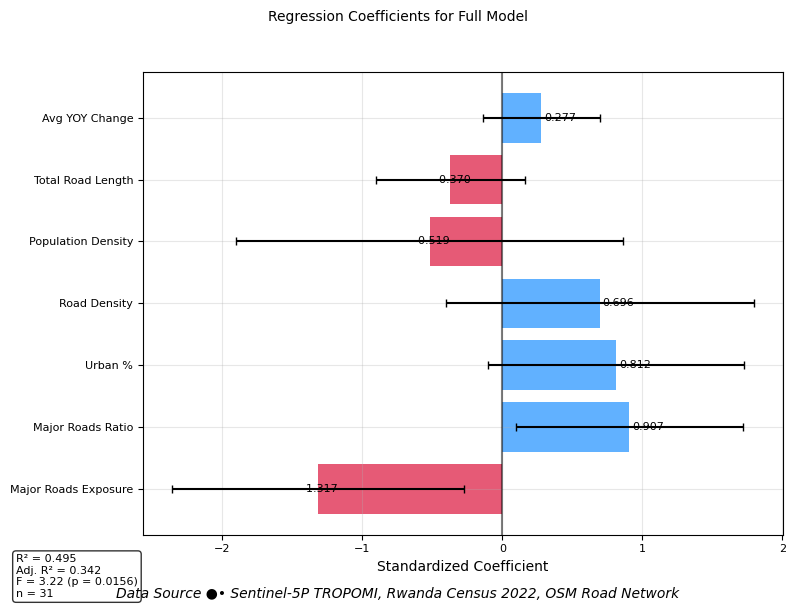

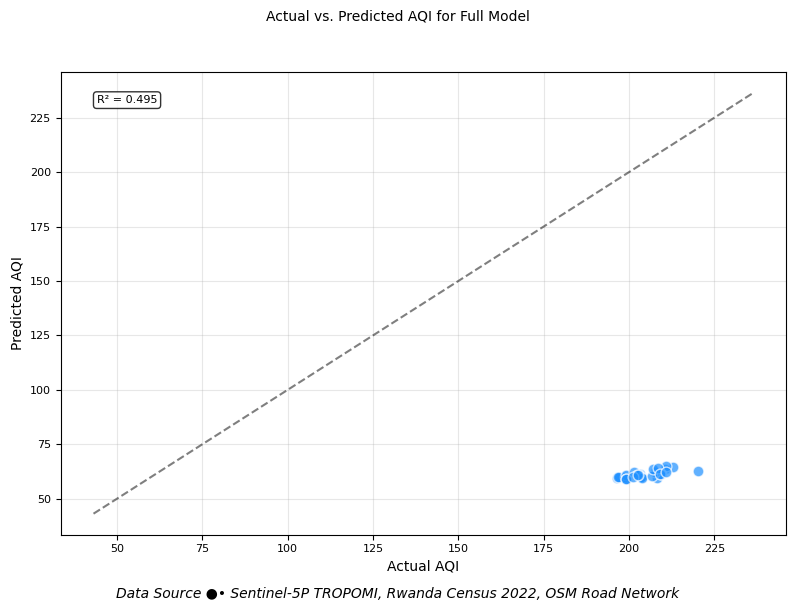

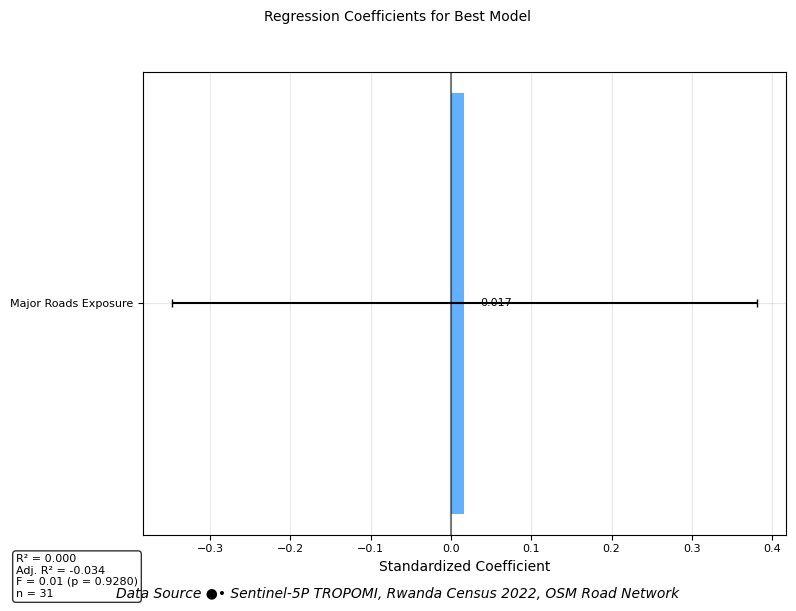

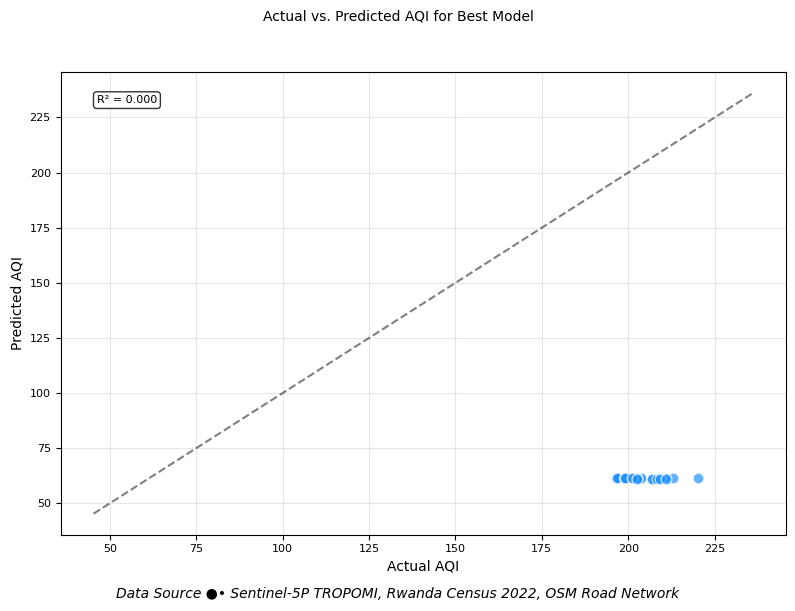

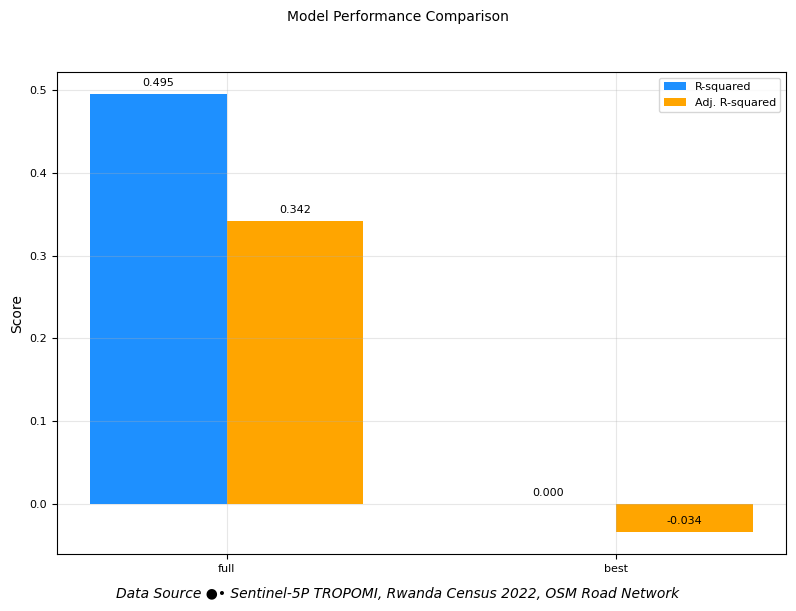

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import os
import logging
from datetime import datetime
from tabulate import tabulate

class RegressionAnalysis:
    def __init__(self, data_path='datasets/integrated_district_data.csv', output_dir='figures', 
                 log_dir='logs', analysis_name='regression_analysis'):
        # Setup directories
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
            
        # Setup logging
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = os.path.join(log_dir, f"{analysis_name}_{self.timestamp}.log")
        self.setup_logging(self.log_file)
        
        # Setup plotting style
        self.setup_plot_style()
        
        self.output_dir = output_dir
        self.data = pd.read_csv(data_path)
        self.models = {}
        
        logging.info(f"Loaded dataset with {len(self.data)} districts")
        
        # Identify key columns
        self.aqi_col = 'AQI_mean' if 'AQI_mean' in self.data.columns else None
        
        if not self.aqi_col:
            msg = "AQI column not found in dataset"
            logging.error(msg)
            raise ValueError(msg)
        
        logging.info(f"Using {self.aqi_col} as dependent variable")
    
    def setup_logging(self, log_file):
        # Clear any existing handlers
        for handler in logging.root.handlers[:]:
            logging.root.removeHandler(handler)
            
        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        logging.info(f"Logging setup")
    
    def setup_plot_style(self):
        # Set color scheme
        self.colors = {
            'primary': 'dodgerblue',
            'secondary': 'crimson',
            'tertiary': 'orange',
            'urban': 'crimson',
            'peri-urban': 'orange',
            'rural': 'dodgerblue',
            'regression': 'forestgreen',
            'pearson': 'dodgerblue',
            'spearman': 'forestgreen'
        }
        
        # Set up font and plot style
        plt.rcParams.update({
            'font.family': 'DejaVu Sans',
            'font.size': 8,
            'axes.titlesize': 10,
            'axes.labelsize': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'figure.figsize': (10, 6),
            'figure.dpi': 100,
            'savefig.dpi': 300,
            'axes.grid': True,
            'grid.alpha': 0.3
        })
    
    def clean_variable_name(self, var_name):
        clean_name = var_name.replace('_', ' ')
        if clean_name.lower() == 'aqi mean':
            return 'AQI'
        elif 'population density' in clean_name.lower():
            return 'Population Density'
        elif 'road density' in clean_name.lower():
            return 'Road Density'
        elif 'urban percentage' in clean_name.lower():
            return 'Urban %'
        elif 'major roads ratio' in clean_name.lower():
            return 'Major Roads Ratio'
        elif 'total road length m' in clean_name.lower():
            return 'Total Road Length'
        elif 'major roads exposure index' in clean_name.lower():
            return 'Major Roads Exposure'
        elif 'avg yoy change' in clean_name.lower():
            return 'Avg YOY Change'
        clean_name = ' '.join(word.capitalize() for word in clean_name.split())
        clean_name = clean_name.replace(' M Km2', '')
        clean_name = clean_name.replace(' Sqkm', '')
        return clean_name
    
    def calculate_vif(self, X):
        X_with_const = sm.add_constant(X)
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_with_const.columns
        vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
        return vif_data
    
    def fit_regression_model(self, model_name, predictors, standardize=True):
        predictors = [var for var in predictors if var in self.data.columns]
        logging.info(f"Fitting {model_name} regression model with predictors: {', '.join(predictors)}")
        
        # Drop rows with NaN values
        data_subset = self.data[[self.aqi_col] + predictors].dropna()
        
        if len(data_subset) <= len(predictors) + 1:
            missing_vars = [var for var in predictors if self.data[var].isna().any()]
            logging.error(f"Not enough data points ({len(data_subset)}) for regression with {len(predictors)} predictors. Missing data in: {', '.join(missing_vars)}")
            return None
        
        # Create X and y
        X = data_subset[predictors]
        y = data_subset[self.aqi_col]
        
        # Check for multicollinearity
        vif_data = self.calculate_vif(X)
        logging.info("Variance Inflation Factors (VIF):")
        high_vif = []
        for i, row in vif_data.iterrows():
            if i > 0:  # Skip constant
                logging.info(f"  {row['Variable']}: {row['VIF']:.2f}")
                if row['VIF'] > 5:
                    high_vif.append((row['Variable'], row['VIF']))
        
        if high_vif:
            logging.warning("High multicollinearity detected:")
            for var, vif in high_vif:
                logging.warning(f"  {var}: VIF = {vif:.2f}")
        
        # Standardize variables
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
        X_for_model = pd.DataFrame(X_scaled, columns=predictors, index=X.index)
        y_for_model = pd.Series(y_scaled, index=X.index, name=self.aqi_col)
        
        # Add constant for statsmodels
        X_with_const = sm.add_constant(X_for_model)
        
        # Fit OLS model
        model = sm.OLS(y_for_model, X_with_const).fit()
        
        # Store model and related info
        self.models[model_name] = {
            'model': model,
            'predictors': predictors,
            'vif_data': vif_data,
            'standardized': True,
            'data_subset': data_subset,
            'X': X,
            'y': y,
            'X_with_const': X_with_const,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'y_scaled': y_for_model
        }
        
        return model
    
    def select_best_predictors(self, model_name):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return []
        
        model_info = self.models[model_name]
        model = model_info['model']
        vif_data = model_info['vif_data']
        
        # Identify significant predictors (p < 0.05)
        significant_predictors = [var for var, pval in model.pvalues.items() if pval < 0.05 and var != 'const']
        
        # Check VIF for significant predictors
        vif_dict = {row['Variable']: row['VIF'] for _, row in vif_data.iterrows() if row['Variable'] != 'const'}
        high_vif_vars = [var for var, vif in vif_dict.items() if vif > 5]
        
        # If there are high VIF variables, prioritize keeping the most significant predictor
        best_predictors = []
        if high_vif_vars:
            # Sort by p-value (ascending) to prioritize most significant
            pvals = [(var, model.pvalues[var]) for var in significant_predictors]
            pvals.sort(key=lambda x: x[1])
            kept_vars = []
            for var, _ in pvals:
                if var not in high_vif_vars:
                    kept_vars.append(var)
                elif not any(v in high_vif_vars for v in kept_vars):
                    kept_vars.append(var)  # Keep the most significant among collinear vars
            best_predictors = kept_vars
        else:
            best_predictors = significant_predictors
        
        # If no significant predictors, select top 2 by coefficient magnitude
        if not best_predictors:
            coefs = [(var, abs(model.params[var])) for var in model.params.index if var != 'const']
            coefs.sort(key=lambda x: x[1], reverse=True)
            best_predictors = [var for var, _ in coefs[:2]]
        
        logging.info(f"Best predictors for {model_name}: {', '.join(best_predictors)}")
        return best_predictors
    
    def plot_coefficients(self, model_name, figsize=(8, 6)):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return None
        
        model_info = self.models[model_name]
        model = model_info['model']
        
        # Extract coefficients (excluding constant)
        coefs = model.params[1:]
        errors = model.bse[1:]
        var_names = [self.clean_variable_name(var) for var in coefs.index]
        
        # Sort by absolute coefficient value
        sorted_indices = np.argsort(np.abs(coefs.values))[::-1]
        coefs = coefs.values[sorted_indices]
        errors = errors.values[sorted_indices]
        var_names = [var_names[i] for i in sorted_indices]
        
        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle(f'Regression Coefficients for {model_name.capitalize()} Model', fontsize=10, y=0.99)
        
        # Create horizontal bar plot
        colors = [self.colors['primary'] if c > 0 else self.colors['secondary'] for c in coefs]
        bars = plt.barh(range(len(coefs)), coefs, color=colors, alpha=0.7)
        
        # Add error bars (95% CI)
        plt.errorbar(coefs, range(len(coefs)), xerr=errors*1.96, fmt='none', ecolor='black', capsize=3)
        
        # Add coefficient values
        for i, v in enumerate(coefs):
            plt.text(v + (0.02 if v >= 0 else -0.11), i, f"{v:.3f}", va='center', fontsize=8)
        
        # Format axes and labels
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
        plt.yticks(range(len(coefs)), var_names)
        plt.xlabel('Standardized Coefficient', fontsize=10)
        plt.grid(axis='x', alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Add model stats annotation
        stats_text = (
            f"R² = {model.rsquared:.3f}\n"
            f"Adj. R² = {model.rsquared_adj:.3f}\n"
            f"F = {model.fvalue:.2f} (p = {model.f_pvalue:.4f})\n"
            f"n = {len(model_info['X'])}"
        )
        plt.annotate(stats_text, xy=(0.02, 0.02), xycoords='figure fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                    fontsize=8, ha='left', va='bottom')
        
        # Add data source note
        plt.figtext(0.5, 0.01, 
                   'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                   ha='center', fontsize=10, style='italic')
        
        # Save figure
        file_path = os.path.join(self.output_dir, f"regression_coefficients_{model_name}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved regression coefficients plot")
        
        return plt.gcf()
    
    def plot_actual_vs_predicted(self, model_name, figsize=(8, 6)):
        if model_name not in self.models:
            logging.error(f"Model {model_name} not found")
            return None
        
        model_info = self.models[model_name]
        model = model_info['model']
        X = model_info['X_with_const']
        y = model_info['y']
        scaler_y = model_info['scaler_y']
        
        # Calculate predicted values
        y_pred = model.predict(X)
        
        # Convert to numpy arrays if necessary
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        if isinstance(y_pred, pd.Series):
            y_pred = y_pred.to_numpy()
        
        # Inverse transform if standardized
        if model_info['standardized'] and scaler_y is not None:
            y = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
            y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        
        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle(f'Actual vs. Predicted AQI for {model_name.capitalize()} Model', fontsize=10, y=0.99)
        
        # Create scatter plot
        plt.scatter(y, y_pred, alpha=0.7, edgecolor='w', s=60, color=self.colors['primary'])
        
        # Add identity line
        max_val = max(y.max(), y_pred.max())
        min_val = min(y.min(), y_pred.min())
        padding = (max_val - min_val) * 0.1
        plt.plot([min_val - padding, max_val + padding], [min_val - padding, max_val + padding], 
                '--', color='black', alpha=0.5)
        
        # Add R-squared annotation
        r_squared = model.rsquared
        plt.annotate(f"R² = {r_squared:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                    fontsize=8, ha='left', va='top')
        
        # Format axes and labels
        plt.xlabel('Actual AQI', fontsize=10)
        plt.ylabel('Predicted AQI', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Add data source note
        plt.figtext(0.5, 0.01, 
                   'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                   ha='center', fontsize=10, style='italic')
        
        # Save figure
        file_path = os.path.join(self.output_dir, f"actual_vs_predicted_{model_name}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved actual vs. predicted plot")
        
        return plt.gcf()
    
    def plot_performance_comparison(self, model_names, figsize=(8, 6)):
        if not all(name in self.models for name in model_names):
            missing = [name for name in model_names if name not in self.models]
            logging.error(f"Models not found: {', '.join(missing)}")
            return None
        
        # Create comparison DataFrame
        comparison_data = []
        for name in model_names:
            model = self.models[name]['model']
            comparison_data.append({
                'Model': name,
                'R-squared': model.rsquared,
                'Adj. R-squared': model.rsquared_adj
            })
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle('Model Performance Comparison', fontsize=10, y=0.99)
        
        # Bar positions
        bar_width = 0.35
        x = np.arange(len(model_names))
        
        # Plot bars for R-squared and Adjusted R-squared
        plt.bar(x - bar_width/2, comparison_df['R-squared'], bar_width, label='R-squared', 
                color=self.colors['primary'])
        plt.bar(x + bar_width/2, comparison_df['Adj. R-squared'], bar_width, label='Adj. R-squared', 
                color=self.colors['tertiary'])
        
        # Add values on top of bars
        for i, v in enumerate(comparison_df['R-squared']):
            plt.text(i - bar_width/2, v + 0.01, f"{v:.3f}", ha='center', fontsize=8)
        for i, v in enumerate(comparison_df['Adj. R-squared']):
            plt.text(i + bar_width/2, v + 0.01, f"{v:.3f}", ha='center', fontsize=8)
        
        # Format axes and labels
        plt.xticks(x, model_names)
        plt.ylabel('Score', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Add data source note
        plt.figtext(0.5, 0.01, 
                   'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                   ha='center', fontsize=10, style='italic')
        
        # Save figure
        file_path = os.path.join(self.output_dir, f"performance_comparison_{'-'.join(model_names)}_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved performance comparison plot")
        
        return plt.gcf()
    
    def display_model_performance(self, model_names):
        if not all(name in self.models for name in model_names):
            missing = [name for name in model_names if name not in self.models]
            logging.error(f"Models not found: {', '.join(missing)}")
            return
        
        # Create comparison DataFrame
        comparison_data = []
        for name in model_names:
            model = self.models[name]['model']
            significant_vars = sum(p < 0.05 for p in model.pvalues[1:])
            metrics = {
                'Model': name,
                'R-squared': f"{model.rsquared:.3f}",
                'Adj. R-squared': f"{model.rsquared_adj:.3f}",
                'AIC': f"{model.aic:.1f}",
                'BIC': f"{model.bic:.1f}",
                'Significant Vars (p < 0.05)': significant_vars,
                'Total Vars': len(model.params) - 1,
                'Observations': int(model.nobs)
            }
            comparison_data.append(metrics)
        
        comparison_df = pd.DataFrame(comparison_data)
        
        # Display using tabulate
        print("\nModel Performance Summary:")
        print(tabulate(comparison_df, headers='keys', tablefmt='psql', showindex=False))
    
    def run_full_analysis(self):
        logging.info("Starting regression analysis")
        
        results = {}
        
        # 1. Full model with all predictors
        all_predictors = [
            'road_density_m_km2',
            'population_density',
            'urban_percentage',
            'major_roads_ratio',
            'total_road_length_m',
            'major_roads_exposure_index',
            'avg_yoy_change'
        ]
        full_model = self.fit_regression_model('full', all_predictors, standardize=True)
        results['full_model'] = full_model
        
        # 2. Select best predictors based on Full model
        best_predictors = self.select_best_predictors('full')
        
        # 3. Best model with selected predictors
        if best_predictors:
            best_model = self.fit_regression_model('best', best_predictors, standardize=True)
            results['best_model'] = best_model
        else:
            logging.warning("No best predictors identified; skipping Best model")
            best_model = None
        
        # 4. Create plots for each model
        for model_name in self.models:
            # Plot regression coefficients
            results[f"{model_name}_coefficients"] = self.plot_coefficients(model_name)
            
            # Plot actual vs predicted
            results[f"{model_name}_predicted"] = self.plot_actual_vs_predicted(model_name)
        
        # 5. Plot performance comparison
        model_names = ['full', 'best'] if best_model else ['full']
        results["performance_comparison"] = self.plot_performance_comparison(model_names)
        
        # 6. Display model performance
        self.display_model_performance(model_names)
        
        logging.info("Regression analysis completed")
        return results

if __name__ == "__main__":
    regression_analysis = RegressionAnalysis()
    results = regression_analysis.run_full_analysis()

2025-04-19 22:35:18,973 - INFO - Logging setup


2025-04-19 22:35:19,104 - INFO - Loaded AQI dataset with 25376 records
2025-04-19 22:35:19,104 - INFO - Loaded poverty dataset with 416 sectors
2025-04-19 22:35:19,104 - INFO - Starting time series trend analysis
2025-04-19 22:35:19,143 - INFO - Merged dataset contains 30805 records after joining on sector_key
2025-04-19 22:35:19,143 - INFO - Grouped sectors into poverty categories: Low, Medium, High based on weighted poverty score
2025-04-19 22:35:19,177 - INFO - Prepared time series data for AQI trends by poverty category
2025-04-19 22:35:19,188 - INFO - Calculated trend slopes for each poverty category
2025-04-19 22:35:19,603 - INFO - Saved AQI trends plot
2025-04-19 22:35:20,000 - INFO - Saved YoY AQI change plot
2025-04-19 22:35:20,350 - INFO - Saved AQI distribution plot
2025-04-19 22:35:20,353 - INFO - Time series trend analysis completed



AQI Trend Metrics by Poverty Category:
+--------------------+---------------+-------------------+
| Poverty Category   |   Trend Slope | Trend Direction   |
|--------------------+---------------+-------------------|
| Low Poverty        |        0.0228 | Worsening         |
| Medium Poverty     |        0.0223 | Worsening         |
| High Poverty       |        0.0226 | Worsening         |
+--------------------+---------------+-------------------+


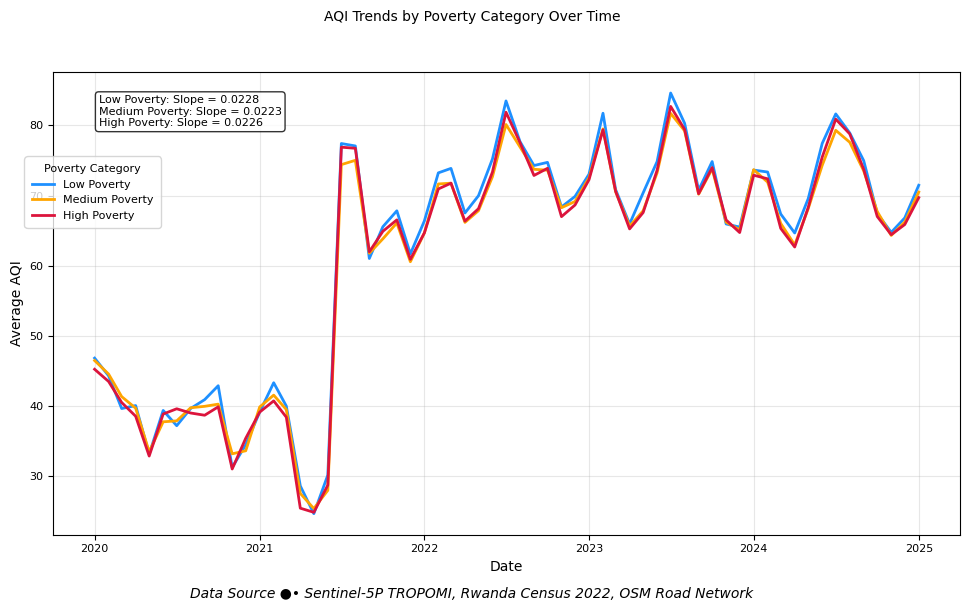

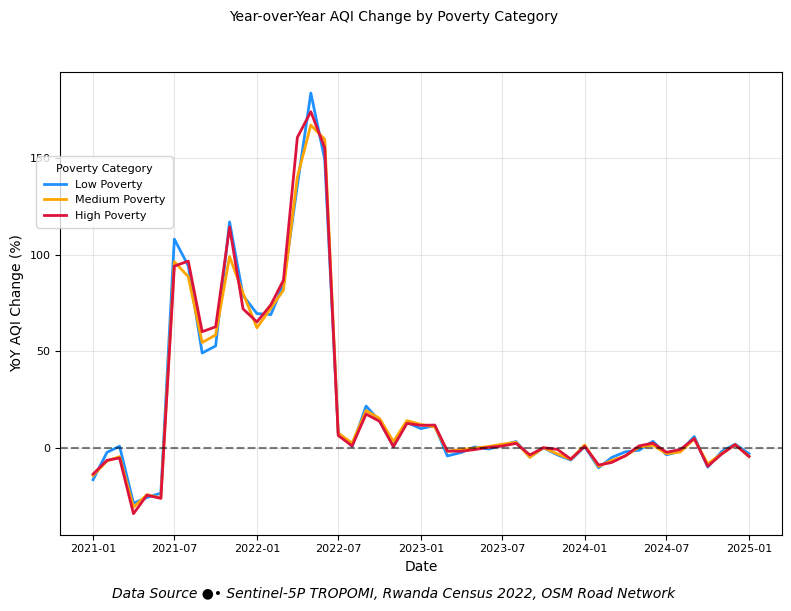

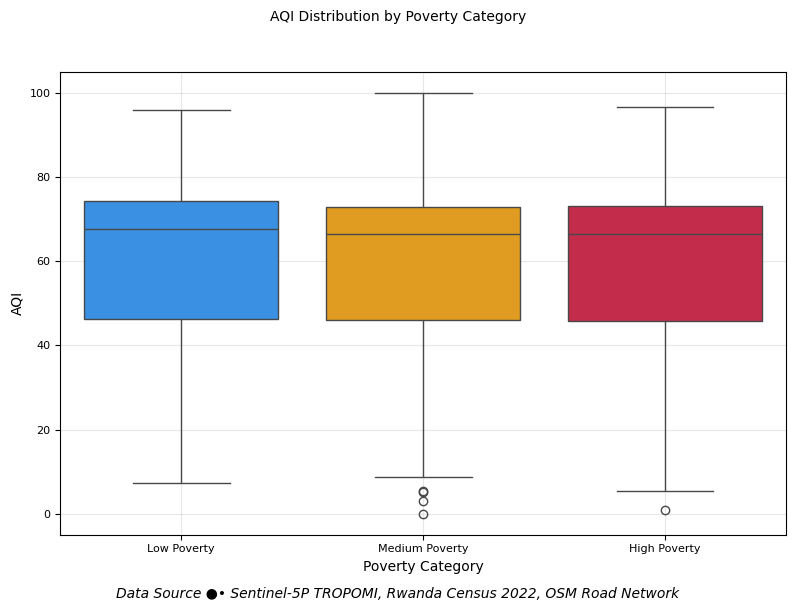

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import logging
from datetime import datetime
from tabulate import tabulate


class AQIPovertyTimeSeries:
    def __init__(self, aqi_data_path='AQI_calculated.csv', poverty_data_path='clean_data_poverty.csv',
                 output_dir='figures', log_dir='logs', analysis_name='aqi_poverty_timeseries'):
        # Setup directories
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)

        # Setup logging
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = os.path.join(
            log_dir, f"{analysis_name}_{self.timestamp}.log")
        self.setup_logging(self.log_file)

        # Setup plotting style
        self.setup_plot_style()

        self.output_dir = output_dir

        # Load datasets
        self.aqi_data = pd.read_csv(aqi_data_path)
        self.poverty_data = pd.read_csv(poverty_data_path)

        logging.info(f"Loaded AQI dataset with {len(self.aqi_data)} records")
        logging.info(
            f"Loaded poverty dataset with {len(self.poverty_data)} sectors")

        # Identify key columns
        self.aqi_col = 'AQI'
        self.time_cols = ['year', 'month']
        self.poverty_cols = ['non_poor', 'vulnerable',
                             'moderately_poor', 'severely_poor']

        if not all(col in self.aqi_data.columns for col in [self.aqi_col] + self.time_cols + ['Name']):
            msg = f"Required columns not found in AQI dataset"
            logging.error(msg)
            raise ValueError(msg)

        if not all(col in self.poverty_data.columns for col in self.poverty_cols + ['sector']):
            msg = f"Required columns not found in poverty dataset"
            logging.error(msg)
            raise ValueError(msg)

    def setup_logging(self, log_file):
        # Clear any existing handlers
        for handler in logging.root.handlers[:]:
            logging.root.removeHandler(handler)

        # Configure logging
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(log_file),
                logging.StreamHandler()
            ]
        )
        logging.info(f"Logging setup")

    def setup_plot_style(self):
        # Set color scheme
        self.colors = {
            'primary': 'dodgerblue',
            'secondary': 'crimson',
            'tertiary': 'orange',
            'urban': 'crimson',
            'peri-urban': 'orange',
            'rural': 'dodgerblue',
            'regression': 'forestgreen',
            'low_poverty': 'dodgerblue',
            'medium_poverty': 'orange',
            'high_poverty': 'crimson'
        }

        # Set up font and plot style
        plt.rcParams.update({
            'font.family': 'DejaVu Sans',
            'font.size': 8,
            'axes.titlesize': 10,
            'axes.labelsize': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'figure.figsize': (10, 6),
            'figure.dpi': 100,
            'savefig.dpi': 300,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def clean_variable_name(self, var_name):
        clean_name = var_name.replace('_', ' ')
        if clean_name.lower() == 'aqi mean':
            return 'AQI'
        clean_name = ' '.join(word.capitalize() for word in clean_name.split())
        return clean_name

    def merge_datasets(self):
        # Create sector_key for robust joining
        self.aqi_data['sector_key'] = self.aqi_data['Name'].str.lower(
        ).str.strip()
        self.poverty_data['sector_key'] = self.poverty_data['sector'].str.lower(
        ).str.strip()

        # Merge AQI and poverty data on sector_key
        self.data = pd.merge(
            self.aqi_data,
            self.poverty_data,
            on='sector_key',
            how='inner'
        )

        # Check if merge resulted in an empty dataset
        if self.data.empty:
            msg = "Merge failed: No matching sectors found between AQI and poverty datasets after joining on sector_key."
            logging.error(msg)
            raise ValueError(msg)

        logging.info(
            f"Merged dataset contains {len(self.data)} records after joining on sector_key")

    def group_by_poverty(self):
        # Calculate weighted poverty score
        self.data['poverty_score'] = (
            (self.data['non_poor'] * 0) +
            (self.data['vulnerable'] * 1) +
            (self.data['moderately_poor'] * 2) +
            (self.data['severely_poor'] * 3)
        )

        # Define poverty categories using tertiles of poverty_score
        tertiles = self.data['poverty_score'].quantile([0.333, 0.667]).values

        # Ensure tertiles are distinct and increasing
        if tertiles[0] == tertiles[1]:
            logging.warning(
                "Tertiles are equal; adjusting to ensure monotonic bins")
            # Add a small offset to make bins distinct
            tertiles[1] = tertiles[1] + 1e-6

        # Define bins and ensure they are monotonically increasing
        bins = [-float('inf'), tertiles[0], tertiles[1], float('inf')]
        if not all(bins[i] < bins[i + 1] for i in range(len(bins) - 1)):
            logging.warning("Bins are not monotonically increasing; adjusting")
            bins = sorted(set(bins))  # Remove duplicates and sort
            if len(bins) < 4:  # Ensure we have enough bins
                bins = [-float('inf'), min(bins) + 1e-6,
                        max(bins) - 1e-6, float('inf')]

        self.data['poverty_category'] = pd.cut(
            self.data['poverty_score'],
            bins=bins,
            labels=['Low Poverty', 'Medium Poverty', 'High Poverty'],
            include_lowest=True
        )
        logging.info(
            "Grouped sectors into poverty categories: Low, Medium, High based on weighted poverty score")

    def prepare_time_series(self):
        # Create a datetime column from year and month
        self.data['date'] = pd.to_datetime(
            self.data['year'].astype(
                str) + '-' + self.data['month'].astype(str).str.zfill(2) + '-01'
        )

        # Sort by date
        self.data = self.data.sort_values('date')

        # Group by poverty category and date, calculate mean AQI
        self.time_series_data = self.data.groupby(
            ['poverty_category', 'date'], observed=True)[self.aqi_col].mean().reset_index()

        # Pivot for easier plotting
        self.time_series_pivot = self.time_series_data.pivot(
            index='date', columns='poverty_category', values=self.aqi_col
        )

        logging.info(
            "Prepared time series data for AQI trends by poverty category")

    def calculate_trend_slopes(self):
        # Calculate trend slopes for each poverty category using linear regression
        slopes = {}
        for category in self.time_series_pivot.columns:
            category_data = self.time_series_pivot[category].dropna()
            if len(category_data) > 1:
                # Convert dates to numeric (days since start)
                X = (category_data.index - category_data.index.min()
                     ).days.values.reshape(-1, 1)
                y = category_data.values
                X_with_const = sm.add_constant(X)
                model = sm.OLS(y, X_with_const).fit()
                slopes[category] = model.params[1]  # Slope coefficient
            else:
                slopes[category] = 0.0
                logging.warning(
                    f"Insufficient data points for {category} to calculate trend slope")

        self.trend_slopes = slopes
        logging.info("Calculated trend slopes for each poverty category")

    def plot_aqi_trends(self, figsize=(10, 6)):
        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle('AQI Trends by Poverty Category Over Time',
                     fontsize=10, y=0.99)

        # Plot time series for each poverty category without markers
        for category in self.time_series_pivot.columns:
            plt.plot(
                self.time_series_pivot.index,
                self.time_series_pivot[category],
                label=category,
                color=self.colors.get(
                    category.lower().replace(' ', '_'), 'gray'),
                linewidth=2
            )

        # Add trend slopes annotation with matching box style
        slopes_text = "\n".join(
            f"{cat}: Slope = {self.trend_slopes[cat]:.4f}" for cat in self.trend_slopes
        )
        plt.annotate(slopes_text,
                     xy=(0.05, 0.95), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3",
                               facecolor='white', alpha=0.8),
                     fontsize=8, ha='left', va='top')

        # Customize legend to match annotation box style
        legend = plt.legend(title='Poverty Category', fontsize=8,
                            bbox_to_anchor=(0.05, 0.75), loc='upper left',
                            bbox_transform=plt.gcf().transFigure)
        legend.get_frame().set_boxstyle('round,pad=0.3')
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)

        # Format axes and labels
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('Average AQI', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add data source note
        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        # Save figure
        file_path = os.path.join(
            self.output_dir, f"aqi_trends_poverty_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved AQI trends plot")

        return plt.gcf()

    def plot_yoy_change(self, figsize=(8, 6)):
        # Calculate YoY change for each poverty category
        yoy_changes = {}
        for category in self.time_series_pivot.columns:
            category_data = self.time_series_pivot[category].dropna()
            # Calculate YoY change (percentage change)
            # Assuming monthly data, 12 periods = 1 year
            yoy_change = category_data.pct_change(periods=12) * 100
            yoy_changes[category] = yoy_change.dropna()

        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle(
            'Year-over-Year AQI Change by Poverty Category', fontsize=10, y=0.99)

        # Plot YoY changes without markers
        for category, yoy_data in yoy_changes.items():
            plt.plot(
                yoy_data.index,
                yoy_data,
                label=category,
                color=self.colors.get(
                    category.lower().replace(' ', '_'), 'gray'),
                linewidth=2
            )

        # Add zero line
        plt.axhline(0, color='black', linestyle='--', alpha=0.5)

        # Customize legend to match annotation box style
        legend = plt.legend(title='Poverty Category', fontsize=8,
                            bbox_to_anchor=(0.05, 0.75), loc='upper left',
                            bbox_transform=plt.gcf().transFigure)
        legend.get_frame().set_boxstyle('round,pad=0.3')
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)

        # Format axes and labels
        plt.xlabel('Date', fontsize=10)
        plt.ylabel('YoY AQI Change (%)', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add data source note
        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        # Save figure
        file_path = os.path.join(
            self.output_dir, f"aqi_yoy_change_poverty_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved YoY AQI change plot")

        return plt.gcf()

    def plot_aqi_distribution(self, figsize=(8, 6)):
        # Create plot
        plt.figure(figsize=figsize)
        plt.suptitle('AQI Distribution by Poverty Category',
                     fontsize=10, y=0.99)

        # Box plot of AQI by poverty category with hue
        sns.boxplot(
            x='poverty_category',
            y=self.aqi_col,
            hue='poverty_category',
            data=self.data,
            palette={
                'Low Poverty': self.colors['low_poverty'],
                'Medium Poverty': self.colors['medium_poverty'],
                'High Poverty': self.colors['high_poverty']
            },
            legend=False  # Disable legend since it's redundant with x-axis labels
        )

        # Format axes and labels
        plt.xlabel('Poverty Category', fontsize=10)
        plt.ylabel('AQI', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add data source note
        plt.figtext(0.5, 0.01,
                    'Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network',
                    ha='center', fontsize=10, style='italic')

        # Save figure
        file_path = os.path.join(
            self.output_dir, f"aqi_distribution_poverty_{self.timestamp}.png")
        plt.savefig(file_path, dpi=300, bbox_inches='tight')
        logging.info(f"Saved AQI distribution plot")

        return plt.gcf()

    def display_trend_metrics(self):
        # Create metrics table
        metrics = []
        for category, slope in self.trend_slopes.items():
            metrics.append({
                'Poverty Category': category,
                'Trend Slope': f"{slope:.4f}",
                'Trend Direction': 'Improving' if slope < 0 else 'Worsening'
            })

        metrics_df = pd.DataFrame(metrics)

        # Display using tabulate
        print("\nAQI Trend Metrics by Poverty Category:")
        print(tabulate(metrics_df, headers='keys',
              tablefmt='psql', showindex=False))

    def run_full_analysis(self):
        logging.info("Starting time series trend analysis")

        results = {}

        # 1. Merge datasets
        self.merge_datasets()

        # 2. Group sectors by poverty categories
        self.group_by_poverty()

        # 3. Prepare time series data
        self.prepare_time_series()

        # 4. Calculate trend slopes
        self.calculate_trend_slopes()

        # 5. Plot AQI trends
        results['aqi_trends_plot'] = self.plot_aqi_trends()

        # 6. Plot YoY change
        results['aqi_yoy_change_plot'] = self.plot_yoy_change()

        # 7. Plot AQI distribution
        results['aqi_distribution_plot'] = self.plot_aqi_distribution()

        # 8. Display trend metrics
        self.display_trend_metrics()

        logging.info("Time series trend analysis completed")
        return results


if __name__ == "__main__":
    analysis = AQIPovertyTimeSeries()
    results = analysis.run_full_analysis()

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import logging
from datetime import datetime
from tabulate import tabulate

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


class UrbanRuralAnalysis:
    """
    Analysis of air quality patterns across urban, peri-urban, and rural areas in Rwanda.
    """

    def __init__(self, district_data_path='integrated_district_data.csv',
                 population_data_path='population_indicators.csv', output_dir='figures'):
        """
        Initialize the analysis with data paths.
        
        Parameters:
        -----------
        district_data_path : str
            Path to the CSV file containing integrated district data (AQI, road metrics)
        population_data_path : str
            Path to the CSV file containing population indicators (demographic data)
        output_dir : str
            Directory to save output figures
        """
        self.district_data_path = district_data_path
        self.population_data_path = population_data_path
        self.output_dir = output_dir

        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Setup plotting style
        self.setup_plot_style()

        # Load and preprocess data
        self.load_data()
        self.preprocess_data()

    def setup_plot_style(self):
        # Define color palette
        self.COLORS = {
            'primary': 'dodgerblue',
            'secondary': 'crimson',
            'tertiary': 'orange',
            'urban': 'crimson',
            'periurban': 'orange',
            'rural': 'dodgerblue',
            'regression': 'forestgreen'
        }

        # Set up font and plot style
        plt.rcParams.update({
            'font.family': 'DejaVu Sans',
            'font.size': 8,
            'axes.titlesize': 10,
            'axes.labelsize': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'figure.figsize': (10, 6),
            'figure.dpi': 100,
            'savefig.dpi': 300,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def load_data(self):
        """Load the district and population data."""
        logger.info("Loading district and population data...")
        self.district_data = pd.read_csv(self.district_data_path)
        self.population_data = pd.read_csv(self.population_data_path)

        logger.info(
            f"Loaded district data with {len(self.district_data)} records.")
        logger.info(
            f"Loaded population data with {len(self.population_data)} records.")

    def preprocess_data(self):
        """Preprocess the data for urban-rural analysis."""
        logger.info("Preprocessing data...")

        # Drop overlapping columns from population_data to avoid suffix conflicts
        overlapping_columns = ['population_density',
                               'urban_percentage', 'rural_percentage']
        population_data_subset = self.population_data.drop(
            columns=overlapping_columns, errors='ignore')

        # Merge district and population data on province and district
        self.data = pd.merge(
            self.district_data,
            population_data_subset,
            on=['province', 'district'],
            how='inner'
        )

        if self.data.empty:
            msg = "Merge failed: No matching districts found between district and population datasets."
            logger.error(msg)
            raise ValueError(msg)

        logger.info(f"Merged dataset contains {len(self.data)} records.")
        logger.info(f"Merged dataset columns: {list(self.data.columns)}")

        # Ensure required columns exist
        required_columns = ['aqi', 'population_density', 'urban_percentage']
        # Use AQI_mean as aqi if aqi is not present
        if 'aqi' not in self.data.columns and 'AQI_mean' in self.data.columns:
            self.data['aqi'] = self.data['AQI_mean']

        missing_columns = [
            col for col in required_columns if col not in self.data.columns]
        if missing_columns:
            msg = f"Missing required columns: {', '.join(missing_columns)}"
            logger.error(msg)
            raise ValueError(msg)

        # Ensure settlement_type is properly categorized
        if 'settlement_type' not in self.data.columns:
            # Create settlement_type based on urban percentage
            self.data['settlement_type'] = 'Rural'
            self.data.loc[self.data['urban_percentage']
                          >= 15, 'settlement_type'] = 'Peri-urban'
            self.data.loc[self.data['urban_percentage']
                          >= 50, 'settlement_type'] = 'Urban'

        # Create a numeric version of settlement_type for regression analysis
        settlement_type_map = {'Rural': 0, 'Peri-urban': 1, 'Urban': 2}
        self.data['settlement_numeric'] = self.data['settlement_type'].map(
            settlement_type_map)

        # Count districts in each settlement type
        settlement_counts = self.data['settlement_type'].value_counts()

        logger.info("\nDistricts by settlement type:")
        logger.info(settlement_counts)

    def analyze_urban_rural_patterns(self):
        """Perform comprehensive urban-rural comparative analysis."""
        logger.info("Analyzing urban-rural patterns...")
        self.compare_aqi_distributions()
        self.compare_pollutant_levels()
        self.analyze_poverty_aqi_by_settlement()
        self.interaction_regression_analysis()
        self.analyze_road_infrastructure_effects()
        self.analyze_population_density_effects()

    def compare_aqi_distributions(self):
        """Compare AQI distributions across settlement types."""
        logger.info("Comparing AQI distributions...")
        plt.figure(figsize=(10, 6))

        # Create boxplot
        sns.boxplot(
            x='settlement_type',
            y='aqi',
            hue='settlement_type',
            data=self.data,
            palette={
                'Rural': self.COLORS['rural'],
                'Peri-urban': self.COLORS['periurban'],
                'Urban': self.COLORS['urban']
            },
            width=0.6,
            legend=False
        )

        # Add individual points
        sns.stripplot(
            x='settlement_type',
            y='aqi',
            data=self.data,
            color='black',
            alpha=0.5,
            size=4,
            jitter=True
        )

        # Calculate summary statistics
        aqi_stats = self.data.groupby('settlement_type', observed=True)[
            'aqi'].describe()

        # Add summary statistics as annotations
        for i, settlement in enumerate(['Rural', 'Peri-urban', 'Urban']):
            if settlement in aqi_stats.index:
                stats_text = f"Mean: {aqi_stats.loc[settlement, 'mean']:.1f}\nMedian: {aqi_stats.loc[settlement, '50%']:.1f}"
                plt.annotate(
                    stats_text,
                    xy=(i, aqi_stats.loc[settlement, 'mean']),
                    xytext=(i, aqi_stats.loc[settlement, 'max'] + 5),
                    ha='center',
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3",
                              fc="white", ec="gray", alpha=0.8)
                )

        # Perform ANOVA to test for significant differences
        f_stat, p_value = stats.f_oneway(
            self.data[self.data['settlement_type'] == 'Rural']['aqi'].dropna(),
            self.data[self.data['settlement_type']
                      == 'Peri-urban']['aqi'].dropna(),
            self.data[self.data['settlement_type'] == 'Urban']['aqi'].dropna()
        )

        # Add ANOVA results
        plt.title('Air Quality Index Distribution by Settlement Type')
        plt.ylabel('Air Quality Index (AQI)')
        plt.xlabel('Settlement Type')
        plt.figtext(
            0.5, 0.01,
            f"ANOVA: F={f_stat:.2f}, p={p_value:.4f} {'(significant)' if p_value < 0.05 else '(not significant)'}",
            ha='center',
            fontsize=8
        )

        # Add data source attribution
        plt.figtext(
            0.5, 0.04,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022",
            ha='center',
            fontsize=8
        )

        plt.tight_layout(rect=[0, 0.06, 1, 0.97])
        plt.savefig(
            f"{self.output_dir}/aqi_distribution_by_settlement.png", dpi=300)
        plt.close()

        return aqi_stats

    def compare_pollutant_levels(self):
        """Compare levels of different pollutants across settlement types."""
        logger.info("Comparing pollutant levels...")
        # Check if individual pollutant columns exist
        pollutant_cols = ['no2', 'so2', 'co', 'o3', 'pm25', 'aqi']
        pollutant_cols = [
            col for col in pollutant_cols if col in self.data.columns]

        if not pollutant_cols:
            logger.warning(
                "No individual pollutant data found for comparison.")
            return

        # Create a figure with subplots for each pollutant
        n_pollutants = len(pollutant_cols)
        n_rows = (n_pollutants + 1) // 2  # Create 2 columns of subplots

        fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows * 4))
        axes = axes.flatten()

        # Loop through pollutants
        for i, pollutant in enumerate(pollutant_cols):
            if i < len(axes):
                # Create boxplot for each pollutant
                sns.boxplot(
                    x='settlement_type',
                    y=pollutant,
                    hue='settlement_type',
                    data=self.data,
                    ax=axes[i],
                    palette={
                        'Rural': self.COLORS['rural'],
                        'Peri-urban': self.COLORS['periurban'],
                        'Urban': self.COLORS['urban']
                    },
                    width=0.6,
                    legend=False
                )

                # Add individual points
                sns.stripplot(
                    x='settlement_type',
                    y=pollutant,
                    data=self.data,
                    ax=axes[i],
                    color='black',
                    alpha=0.5,
                    size=4,
                    jitter=True
                )

                # Clean up pollutant name for display
                pollutant_name = pollutant.replace('_', ' ').upper()

                # Perform ANOVA
                try:
                    f_stat, p_value = stats.f_oneway(
                        self.data[self.data['settlement_type']
                                  == 'Rural'][pollutant].dropna(),
                        self.data[self.data['settlement_type']
                                  == 'Peri-urban'][pollutant].dropna(),
                        self.data[self.data['settlement_type']
                                  == 'Urban'][pollutant].dropna()
                    )

                    sig_text = f"ANOVA: F={f_stat:.2f}, p={p_value:.4f} {'*' if p_value < 0.05 else ''}"
                except:
                    sig_text = "ANOVA: Insufficient data"

                axes[i].set_title(
                    f"{pollutant_name} by Settlement Type\n{sig_text}")
                axes[i].set_xlabel('Settlement Type')
                axes[i].set_ylabel(f"{pollutant_name} Concentration")

        # Remove any unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()

        # Add data source attribution
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022",
            ha='center',
            fontsize=8
        )

        plt.savefig(f"{self.output_dir}/pollutants_by_settlement.png",
                    dpi=300, bbox_inches='tight')
        plt.close()

    def analyze_poverty_aqi_by_settlement(self):
        """Analyze the relationship between poverty and AQI within each settlement type."""
        logger.info("Analyzing poverty-AQI relationship by settlement type...")
        # Note: poverty_index is not available in the provided datasets
        # We'll skip this analysis unless poverty data can be sourced
        logger.warning(
            "Skipping poverty-AQI analysis: 'poverty_index' column not found in dataset.")
        return None

    def interaction_regression_analysis(self):
        """Analyze the interaction between settlement type and population density on AQI."""
        logger.info("Running interaction regression analysis...")
        # Create interaction term
        self.data['density_x_settlement'] = self.data['population_density'] * \
            self.data['settlement_numeric']

        # Prepare data for regression
        X = self.data[['population_density',
                       'settlement_numeric', 'density_x_settlement']]
        X = sm.add_constant(X)
        y = self.data['aqi']

        # Run regression model
        model = sm.OLS(y, X).fit()

        # Log regression results
        logger.info("\nInteraction Regression Results:")
        logger.info(model.summary())

        # Create a visualization to illustrate the interaction effect
        plt.figure(figsize=(12, 7))

        # Create a meshgrid for population density and settlement type
        density_range = np.linspace(self.data['population_density'].min(
        ), self.data['population_density'].max(), 100)
        settlement_values = np.array([0, 1, 2])  # Rural, Peri-urban, Urban

        # Plot actual data points
        for i, settlement in enumerate(['Rural', 'Peri-urban', 'Urban']):
            subset = self.data[self.data['settlement_type'] == settlement]
            plt.scatter(
                subset['population_density'],
                subset['aqi'],
                color=[self.COLORS['rural'], self.COLORS['periurban'],
                       self.COLORS['urban']][i],
                alpha=0.7,
                label=f"{settlement} Districts",
                s=50
            )

        # Plot predicted lines for each settlement type
        for i, settlement_val in enumerate(settlement_values):
            settlement_name = ['Rural', 'Peri-urban', 'Urban'][i]
            y_pred = model.params['const'] + \
                model.params['population_density'] * density_range + \
                model.params['settlement_numeric'] * settlement_val + \
                model.params['density_x_settlement'] * \
                (density_range * settlement_val)

            plt.plot(
                density_range,
                y_pred,
                color=[self.COLORS['rural'], self.COLORS['periurban'],
                       self.COLORS['urban']][i],
                linestyle='--',
                linewidth=2,
                label=f"{settlement_name} Predicted"
            )

        # Set plot titles and labels
        plt.title(
            'Interaction Effect of Population Density and Settlement Type on Air Quality')
        plt.xlabel('Population Density')
        plt.ylabel('Air Quality Index (AQI)')
        plt.grid(True, alpha=0.3)

        # Customize legend to match annotation box style
        legend = plt.legend(fontsize=8)
        legend.get_frame().set_boxstyle('round,pad=0.3')
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)

        # Add regression equation
        equation = f"AQI = {model.params['const']:.2f} + "
        equation += f"{model.params['population_density']:.2f}×Density + "
        equation += f"{model.params['settlement_numeric']:.2f}×Settlement + "
        equation += f"{model.params['density_x_settlement']:.2f}×(Density×Settlement)"

        significance = f"Interaction p-value: {model.pvalues['density_x_settlement']:.4f} "
        significance += f"({'significant' if model.pvalues['density_x_settlement'] < 0.05 else 'not significant'})"

        plt.figtext(
            0.5, 0.04,
            equation + "\n" + significance,
            ha='center',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.5",
                      fc="white", ec="gray", alpha=0.8)
        )

        # Add data source attribution
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022",
            ha='center',
            fontsize=8
        )

        plt.tight_layout(rect=[0, 0.07, 1, 0.97])
        plt.savefig(f"{self.output_dir}/interaction_effect.png", dpi=300)
        plt.close()

        return model

    def analyze_road_infrastructure_effects(self):
        """Analyze how road infrastructure affects AQI across settlement types."""
        logger.info("Analyzing road infrastructure effects...")
        # Check if road infrastructure variables exist
        road_vars = [col for col in self.data.columns if 'road' in col.lower()]

        if not road_vars:
            logger.warning(
                "No road infrastructure variables found for analysis.")
            return

        # Select the primary road infrastructure variable for analysis
        if 'road_density_m_km2' in road_vars:
            road_var = 'road_density_m_km2'
        elif len(road_vars) > 0:
            road_var = road_vars[0]
        else:
            return

        # Create a figure
        plt.figure(figsize=(12, 7))

        # Define settlement types and their colors
        settlement_types = ['Rural', 'Peri-urban', 'Urban']
        colors = [self.COLORS['rural'],
                  self.COLORS['periurban'], self.COLORS['urban']]

        # Plot data points and regression lines for each settlement type
        for settlement, color in zip(settlement_types, colors):
            # Filter data for the settlement type
            subset = self.data[self.data['settlement_type'] == settlement]

            if len(subset) > 1:  # Need at least 2 points for regression
                # Plot scatter points
                plt.scatter(
                    subset[road_var],
                    subset['aqi'],
                    color=color,
                    alpha=0.7,
                    label=f"{settlement} Districts",
                    s=50
                )

                # Calculate regression line
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    subset[road_var], subset['aqi'])

                # Create regression line
                x_range = np.linspace(
                    subset[road_var].min(), subset[road_var].max(), 100)
                plt.plot(
                    x_range,
                    intercept + slope * x_range,
                    color=color,
                    linestyle='--',
                    linewidth=2,
                    label=f"{settlement} Trend (r={r_value:.2f}, p={p_value:.3f})"
                )

                # Add correlation statistics in a box
                if len(subset) >= 5:  # Only add stats box if enough data points
                    plt.annotate(
                        f"Correlation: r = {r_value:.2f}\np-value = {p_value:.3f}",
                        xy=(subset[road_var].mean(), subset['aqi'].mean()),
                        xytext=(subset[road_var].mean() + 0.05 * (subset[road_var].max() - subset[road_var].min()),
                                subset['aqi'].mean() + 5),
                        bbox=dict(boxstyle="round,pad=0.3",
                                  fc="white", ec=color, alpha=0.8),
                        fontsize=8
                    )

        # Clean variable name for display
        road_var_clean = road_var.replace('_', ' ').title()

        # Set plot titles and labels
        plt.title(
            f'Relationship Between {road_var_clean} and Air Quality by Settlement Type')
        plt.xlabel(road_var_clean)
        plt.ylabel('Air Quality Index (AQI)')
        plt.grid(True, alpha=0.3)

        # Customize legend to match annotation box style
        legend = plt.legend(fontsize=8)
        legend.get_frame().set_boxstyle('round,pad=0.3')
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)

        # Add data source attribution
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
            ha='center',
            fontsize=8
        )

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.savefig(f"{self.output_dir}/road_infrastructure_aqi.png", dpi=300)
        plt.close()

        # Create a more detailed analysis with multiple road variables if available
        if len(road_vars) >= 2:
            self.analyze_multiple_road_variables()

    def analyze_multiple_road_variables(self):
        """Analyze how different road infrastructure metrics affect AQI."""
        logger.info("Analyzing multiple road variables...")
        # Get road infrastructure variables
        road_vars = [col for col in self.data.columns if 'road' in col.lower()]

        # Only keep numeric road variables
        road_vars = [
            var for var in road_vars if pd.api.types.is_numeric_dtype(self.data[var])]

        if len(road_vars) < 2:
            return

        # Create correlation heatmap between road variables and AQI by settlement type
        settlement_types = ['Rural', 'Peri-urban', 'Urban']

        # Create a figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Calculate correlations for each settlement type
        for i, settlement in enumerate(settlement_types):
            subset = self.data[self.data['settlement_type'] == settlement]

            if len(subset) > 3:  # Need a minimum number of data points
                # Select variables for correlation
                corr_vars = road_vars + ['aqi']

                # Clean variable names for display
                clean_names = [var.replace('_', ' ').title()
                               for var in corr_vars]

                # Calculate correlation matrix
                corr_matrix = subset[corr_vars].corr()

                # Create heatmap
                sns.heatmap(
                    corr_matrix,
                    annot=True,
                    cmap='coolwarm',
                    vmin=-1,
                    vmax=1,
                    ax=axes[i],
                    xticklabels=clean_names,
                    yticklabels=clean_names,
                    annot_kws={"size": 8}
                )

                axes[i].set_title(f'{settlement} Areas')
            else:
                axes[i].text(0.5, 0.5, f"Insufficient {settlement} data\nfor correlation analysis",
                             ha='center', va='center', fontsize=12)

        plt.suptitle(
            'Correlation Between Road Infrastructure Metrics and AQI by Settlement Type')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add data source attribution
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
            ha='center',
            fontsize=8
        )

        plt.savefig(f"{self.output_dir}/road_metrics_correlation.png", dpi=300)
        plt.close()

        # Create bar chart of correlations with AQI
        plt.figure(figsize=(12, 6))

        # Prepare data for bar chart
        road_aqi_corr = pd.DataFrame(
            columns=['Road Metric', 'Settlement Type', 'Correlation'])

        row = 0
        for settlement in settlement_types:
            subset = self.data[self.data['settlement_type'] == settlement]

            if len(subset) > 3:
                for var in road_vars:
                    # Calculate correlation
                    corr = subset[var].corr(subset['aqi'])

                    # Clean variable name
                    var_clean = var.replace('_', ' ').title()

                    # Add to DataFrame
                    road_aqi_corr.loc[row] = [var_clean, settlement, corr]
                    row += 1

        # Create grouped bar chart
        if len(road_aqi_corr) > 0:
            # Set the width of the bars
            bar_width = 0.25

            # Set position of bar on x axis
            r1 = np.arange(len(road_aqi_corr['Road Metric'].unique()))
            r2 = [x + bar_width for x in r1]
            r3 = [x + bar_width for x in r2]

            # Create grouped bars
            for i, settlement in enumerate(settlement_types):
                subset = road_aqi_corr[road_aqi_corr['Settlement Type']
                                       == settlement]

                if len(subset) > 0:
                    plt.bar(
                        eval(f'r{i+1}')[:len(subset)],
                        subset['Correlation'],
                        width=bar_width,
                        label=settlement,
                        color=[self.COLORS['rural'],
                               self.COLORS['periurban'], self.COLORS['urban']][i]
                    )

            # Add labels and title
            plt.xlabel('Road Infrastructure Metric')
            plt.ylabel('Correlation with AQI')
            plt.title(
                'Correlation Between Road Infrastructure Metrics and AQI by Settlement Type')
            plt.xticks([r + bar_width for r in range(len(road_aqi_corr['Road Metric'].unique()))],
                       road_aqi_corr['Road Metric'].unique(), rotation=45, ha='right')

            # Customize legend to match annotation box style
            legend = plt.legend(fontsize=8)
            legend.get_frame().set_boxstyle('round,pad=0.3')
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(0.8)

            # Add zero line
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

            # Add significance threshold lines
            n_samples = self.data.groupby('settlement_type').size().max()
            critical_r = stats.pearsonr(
                np.zeros(n_samples), np.zeros(n_samples))[1]
            plt.axhline(y=critical_r, color='gray', linestyle='--', alpha=0.5)
            plt.axhline(y=-critical_r, color='gray', linestyle='--', alpha=0.5)

            # Add data source attribution
            plt.figtext(
                0.5, 0.01,
                "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
                ha='center',
                fontsize=8
            )

            plt.tight_layout(rect=[0, 0.03, 1, 0.97])
            plt.savefig(
                f"{self.output_dir}/road_metrics_correlation_bars.png", dpi=300)
            plt.close()

    def analyze_population_density_effects(self):
        """Analyze how population density affects AQI across settlement types."""
        logger.info("Analyzing population density effects...")
        # Check if population density variable exists
        if 'population_density' not in self.data.columns:
            logger.warning(
                "Population density variable not found for analysis.")
            return

        # Create a figure
        plt.figure(figsize=(12, 7))

        # Define settlement types and their colors
        settlement_types = ['Rural', 'Peri-urban', 'Urban']
        colors = [self.COLORS['rural'],
                  self.COLORS['periurban'], self.COLORS['urban']]

        # Plot data points and regression lines for each settlement type
        for settlement, color in zip(settlement_types, colors):
            # Filter data for the settlement type
            subset = self.data[self.data['settlement_type'] == settlement]

            if len(subset) > 1:  # Need at least 2 points for regression
                # Plot scatter points
                plt.scatter(
                    subset['population_density'],
                    subset['aqi'],
                    color=color,
                    alpha=0.7,
                    label=f"{settlement} Districts",
                    s=50
                )

                # Calculate regression line
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    subset['population_density'], subset['aqi']
                )

                # Create regression line
                x_range = np.linspace(
                    subset['population_density'].min(),
                    subset['population_density'].max(),
                    100
                )
                plt.plot(
                    x_range,
                    intercept + slope * x_range,
                    color=color,
                    linestyle='--',
                    linewidth=2,
                    label=f"{settlement} Trend (r={r_value:.2f}, p={p_value:.3f})"
                )

                # Add correlation statistics in a box
                if len(subset) >= 5:  # Only add stats box if enough data points
                    plt.annotate(
                        f"Correlation: r = {r_value:.2f}\np-value = {p_value:.3f}",
                        xy=(subset['population_density'].mean(),
                            subset['aqi'].mean()),
                        xytext=(subset['population_density'].mean() + 0.05 * (subset['population_density'].max() - subset['population_density'].min()),
                                subset['aqi'].mean() + 5),
                        bbox=dict(boxstyle="round,pad=0.3",
                                  fc="white", ec=color, alpha=0.8),
                        fontsize=8
                    )

        # Set plot titles and labels
        plt.title(
            'Relationship Between Population Density and Air Quality by Settlement Type')
        plt.xlabel('Population Density')
        plt.ylabel('Air Quality Index (AQI)')
        plt.grid(True, alpha=0.3)

        # Customize legend to match annotation box style
        legend = plt.legend(fontsize=8)
        legend.get_frame().set_boxstyle('round,pad=0.3')
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)

        # Add data source attribution
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022",
            ha='center',
            fontsize=8
        )

        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.savefig(f"{self.output_dir}/population_density_aqi.png", dpi=300)
        plt.close()

    def create_comparative_summary(self):
        """Create a comprehensive summary of the urban-rural analysis."""
        logger.info("Creating comparative summary...")
        # Create bar charts comparing key metrics across settlement types
        metrics = ['aqi', 'population_density']

        # Add road metrics if available
        road_vars = [col for col in self.data.columns if 'road' in col.lower()]
        if road_vars:
            metrics.extend(
                [var for var in road_vars if pd.api.types.is_numeric_dtype(self.data[var])][:2])

        # Create figure with subplots
        fig, axes = plt.subplots(1, len(metrics), figsize=(15, 6))
        axes = np.array(axes).flatten()  # Ensure axes is an array for indexing

        # Plot each metric
        for i, metric in enumerate(metrics):
            if metric in self.data.columns:
                # Calculate mean values by settlement type
                summary = self.data.groupby('settlement_type', observed=True)[
                    metric].mean()

                # Calculate standard error
                std_err = self.data.groupby('settlement_type', observed=True)[
                    metric].sem()

                # Clean metric name for display
                metric_name = metric.replace('_', ' ').title()

                # Create bar chart
                bars = axes[i].bar(
                    summary.index,
                    summary.values,
                    color=[self.COLORS['rural'],
                           self.COLORS['periurban'], self.COLORS['urban']],
                    yerr=std_err,
                    capsize=5,
                    alpha=0.7
                )

                # Add data labels
                for bar in bars:
                    height = bar.get_height()
                    axes[i].text(
                        bar.get_x() + bar.get_width()/2.,
                        height * 1.05,
                        f'{height:.1f}',
                        ha='center',
                        fontsize=8
                    )

                # Set titles and labels
                axes[i].set_title(metric_name)
                axes[i].set_ylabel(metric_name)
                axes[i].grid(axis='y', alpha=0.3)

        plt.suptitle('Comparison of Key Metrics Across Settlement Types')
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])

        # Add data source attribution
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
            ha='center',
            fontsize=8
        )

        plt.savefig(
            f"{self.output_dir}/settlement_type_comparison.png", dpi=300)
        plt.close()

        # Create correlation matrix heatmap for each settlement type
        self.create_correlation_heatmaps()

    def create_correlation_heatmaps(self):
        """Create correlation heatmaps for each settlement type."""
        logger.info("Creating correlation heatmaps...")
        # Define settlement types
        settlement_types = ['Rural', 'Peri-urban', 'Urban']

        # Select variables for correlation analysis
        corr_vars = ['aqi', 'population_density']

        # Add road metrics if available
        road_vars = [col for col in self.data.columns if 'road' in col.lower()]
        if road_vars:
            corr_vars.extend(
                [var for var in road_vars if pd.api.types.is_numeric_dtype(self.data[var])][:3])

        # Create a figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Create correlation heatmap for each settlement type
        for i, settlement in enumerate(settlement_types):
            subset = self.data[self.data['settlement_type'] == settlement]

            if len(subset) > 3:  # Need a minimum number of data points
                # Calculate correlation matrix
                corr_matrix = subset[corr_vars].corr()

                # Clean variable names for display
                clean_names = [var.replace('_', ' ').title()
                               for var in corr_vars]

                # Create heatmap
                sns.heatmap(
                    corr_matrix,
                    annot=True,
                    cmap='coolwarm',
                    vmin=-1,
                    vmax=1,
                    ax=axes[i],
                    xticklabels=clean_names,
                    yticklabels=clean_names,
                    annot_kws={"size": 8}
                )

                axes[i].set_title(f'{settlement} Areas')
            else:
                axes[i].text(0.5, 0.5, f"Insufficient {settlement} data\nfor correlation analysis",
                             ha='center', va='center', fontsize=12)

        plt.suptitle('Correlation Matrices by Settlement Type')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

        # Add data source attribution
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
            ha='center',
            fontsize=8
        )

        plt.savefig(f"{self.output_dir}/correlation_heatmaps.png", dpi=300)
        plt.close()

    def create_multivariate_model_by_settlement(self):
        """Create separate multivariate regression models for each settlement type using PCA."""
        logger.info(
            "Running multivariate regression models by settlement type with PCA...")
        # Define settlement types
        settlement_types = ['Rural', 'Peri-urban', 'Urban']

        # Select all numeric variables for PCA, excluding the target and non-informative columns
        exclude_cols = ['aqi', 'AQI_mean', 'AQI_median', 'AQI_std', 'AQI_min', 'AQI_max', 'AQI_count', 'AQI_cv',
                        'AQI_mean_scaled', 'settlement_numeric', 'province', 'district', 'urban_rural_type', 'settlement_type']
        numeric_cols = [col for col in self.data.columns if pd.api.types.is_numeric_dtype(
            self.data[col]) and col not in exclude_cols]

        logger.info(f"Variables for PCA: {numeric_cols}")

        # Standardize the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(self.data[numeric_cols])
        X_scaled = pd.DataFrame(
            X_scaled, columns=numeric_cols, index=self.data.index)

        # Apply PCA
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)

        # Determine the number of components to explain 90% of variance
        explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
        n_components = next(
            i + 1 for i, ratio in enumerate(explained_variance_ratio) if ratio >= 0.9)
        logger.info(
            f"Number of PCA components explaining 90% variance: {n_components}")

        # Use the top components
        X_pca = X_pca[:, :n_components]
        predictors = [f'PC{i+1}' for i in range(n_components)]
        X_pca_df = pd.DataFrame(
            X_pca, columns=predictors, index=self.data.index)

        # Merge PCA components back with the original data
        self.data = pd.concat([self.data, X_pca_df], axis=1)

        # Create DataFrame to store regression results
        regression_results = pd.DataFrame(
            columns=['Settlement Type', 'Sample Size', 'R-squared', 'Adj. R-squared',
                     'F-statistic', 'P-value', 'Significant at p<0.05']
        )

        # Create DataFrame to store coefficients
        coef_results = pd.DataFrame(columns=['Settlement Type'] + predictors)

        # Run regression for each settlement type
        for i, settlement in enumerate(settlement_types):
            subset = self.data[self.data['settlement_type'] == settlement]

            # Adjust the number of components based on the number of observations
            n_obs = len(subset)
            # Ensure at least 1 component, leave room for intercept
            max_components = min(n_components, max(1, n_obs - 2))
            current_predictors = predictors[:max_components]

            if n_obs > max_components + 1:  # Need more observations than predictors
                # Prepare data for regression
                X = subset[current_predictors]
                X = sm.add_constant(X)
                y = subset['aqi']

                # Run regression model
                model = sm.OLS(y, X).fit()

                # Store regression results
                regression_results.loc[i] = [
                    settlement,
                    len(subset),
                    f"{model.rsquared:.3f}",
                    f"{model.rsquared_adj:.3f}",
                    f"{model.fvalue:.3f}",
                    f"{model.f_pvalue:.4f}",
                    "Yes" if model.f_pvalue < 0.05 else "No"
                ]

                # Store coefficients
                coef_row = [settlement]
                for predictor in predictors:
                    if predictor in model.params.index:
                        coef_row.append(
                            f"{model.params[predictor]:.3f} (p={model.pvalues[predictor]:.3f})")
                    else:
                        coef_row.append("N/A")

                coef_results.loc[i] = coef_row

                # Log model summary
                logger.info(f"\nRegression model for {settlement} areas:")
                logger.info(model.summary())
            else:
                regression_results.loc[i] = [
                    settlement,
                    len(subset),
                    "Insufficient data",
                    "Insufficient data",
                    "Insufficient data",
                    "Insufficient data",
                    "No"
                ]

                coef_results.loc[i] = [settlement] + \
                    ["Insufficient data"] * len(predictors)

        logger.info("\nRegression results by settlement type:")
        logger.info(regression_results)

        logger.info("\nCoefficient results by settlement type:")
        logger.info(coef_results)

        # Create a visual representation of the coefficients
        self.plot_regression_coefficients(coef_results, predictors)

        return regression_results, coef_results

    def plot_regression_coefficients(self, coef_results, predictors):
        """Create a visual representation of regression coefficients."""
        logger.info("Plotting regression coefficients...")
        # Extract coefficient values and p-values
        coef_data = pd.DataFrame(
            columns=['Settlement Type', 'Predictor', 'Coefficient', 'P-value', 'Significant'])

        row = 0
        for i, settlement_row in coef_results.iterrows():
            settlement = settlement_row['Settlement Type']

            for predictor in predictors:
                coef_str = str(settlement_row[predictor])

                if "Insufficient data" not in coef_str:
                    # Extract coefficient and p-value
                    try:
                        coef = float(coef_str.split(" ")[0])
                        p_value = float(coef_str.split(
                            "p=")[1].replace(')', ''))
                        significant = p_value < 0.05

                        coef_data.loc[row] = [settlement, predictor.replace(
                            '_', ' ').title(), coef, p_value, significant]
                        row += 1
                    except:
                        continue

        if len(coef_data) > 0:
            # Create grouped bar chart of coefficients
            plt.figure(figsize=(12, 7))

            # Set the width of the bars
            bar_width = 0.25

            # Set position of bar on x axis
            r1 = np.arange(len(coef_data['Predictor'].unique()))
            r2 = [x + bar_width for x in r1]
            r3 = [x + bar_width for x in r2]

            # Create grouped bars
            for i, settlement in enumerate(['Rural', 'Peri-urban', 'Urban']):
                subset = coef_data[coef_data['Settlement Type'] == settlement]

                if len(subset) > 0:
                    bars = plt.bar(
                        eval(f'r{i+1}')[:len(subset)],
                        subset['Coefficient'],
                        width=bar_width,
                        label=settlement,
                        color=[self.COLORS['rural'],
                               self.COLORS['periurban'], self.COLORS['urban']][i]
                    )

                    # Add significance markers
                    for j, bar in enumerate(bars):
                        if subset.iloc[j]['Significant']:
                            plt.text(
                                bar.get_x() + bar.get_width()/2.,
                                bar.get_height() + 0.1 if bar.get_height() >= 0 else bar.get_height() - 0.3,
                                '*',
                                ha='center',
                                fontsize=14
                            )

            # Add labels and title
            plt.xlabel('Principal Component')
            plt.ylabel('Coefficient Value')
            plt.title(
                'Regression Coefficients of PCA Components by Settlement Type')
            plt.xticks([r + bar_width for r in range(len(coef_data['Predictor'].unique()))],
                       coef_data['Predictor'].unique(), rotation=45, ha='right')

            # Customize legend to match annotation box style
            legend = plt.legend(fontsize=8)
            legend.get_frame().set_boxstyle('round,pad=0.3')
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(0.8)

            # Add zero line
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

            # Add annotation explaining significance
            plt.figtext(
                0.5, 0.01,
                "* indicates statistically significant coefficient (p < 0.05)\nData Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
                ha='center',
                fontsize=8
            )

            plt.tight_layout(rect=[0, 0.03, 1, 0.97])
            plt.savefig(
                f"{self.output_dir}/regression_coefficients_pca.png", dpi=300)
            plt.close()


def run_analysis(district_data_path='datasets/integrated_district_data.csv',
                 population_data_path='datasets/population_indicators_processed.csv', output_dir='figures'):
    """
    Run the urban-rural comparative analysis.
    
    Parameters:
    -----------
    district_data_path : str
        Path to the integrated district data CSV
    population_data_path : str
        Path to the population indicators CSV
    output_dir : str
        Directory to save output figures
    """
    logger.info("Starting urban-rural comparative analysis...")

    # Initialize the analysis
    analysis = UrbanRuralAnalysis(
        district_data_path, population_data_path, output_dir)

    # Perform urban-rural comparative analysis
    logger.info("Analyzing urban-rural patterns...")
    analysis.analyze_urban_rural_patterns()

    # Create comparative summary
    logger.info("Creating comparative summary...")
    analysis.create_comparative_summary()

    # Create multivariate regression models by settlement type
    logger.info("Running multivariate regression models by settlement type...")
    regression_results, coef_results = analysis.create_multivariate_model_by_settlement()

    logger.info("Analysis complete. Results saved to the figures directory.")

    # Print summary of findings
    print("\n" + "="*50)
    print("URBAN-RURAL COMPARATIVE ANALYSIS SUMMARY")
    print("="*50)
    print("\nRegression Model Performance by Settlement Type:")
    print(regression_results[['Settlement Type', 'Sample Size',
          'R-squared', 'Adj. R-squared', 'Significant at p<0.05']])

    print("\nKey Findings:")

    # Check if urban AQI model explains more variance, handling 'Insufficient data'
    urban_aqi_str = regression_results[regression_results['Settlement Type']
                                       == 'Urban']['R-squared'].values[0]
    rural_aqi_str = regression_results[regression_results['Settlement Type']
                                       == 'Rural']['R-squared'].values[0]

    if urban_aqi_str != 'Insufficient data' and rural_aqi_str != 'Insufficient data':
        urban_aqi = float(urban_aqi_str)
        rural_aqi = float(rural_aqi_str)
        if urban_aqi > rural_aqi:
            print("1. Urban models explain more AQI variation (R² = {:.2f}) than rural models (R² = {:.2f})".format(
                urban_aqi, rural_aqi
            ))
        else:
            print("1. Rural models explain more AQI variation (R² = {:.2f}) than urban models (R² = {:.2f})".format(
                rural_aqi, urban_aqi
            ))
    else:
        print("1. Unable to compare Urban and Rural models due to insufficient data in one or more settlement types.")

    print("2. Key predictors (Principal Components) vary by settlement type:")
    for i, row in coef_results.iterrows():
        settlement = row['Settlement Type']
        predictors = row.index[1:]
        values = row.values[1:]

        # Find the strongest predictor (by absolute coefficient value)
        strongest = None
        strongest_val = 0

        for j, val in enumerate(values):
            if "Insufficient data" not in str(val):
                try:
                    coef = float(str(val).split(" ")[0])
                    if abs(coef) > strongest_val:
                        strongest_val = abs(coef)
                        strongest = predictors[j]
                except:
                    continue

        if strongest:
            print(
                f"   - {settlement}: Strongest principal component is {strongest}")

    print("\nSee generated visualizations in the 'figures' directory for detailed results.")

    return regression_results, coef_results


if __name__ == "__main__":
    # Create output directory if it doesn't exist
    output_dir = 'figures'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Run the analysis
    regression_results, coef_results = run_analysis()

2025-04-19 23:54:48,855 - INFO - Starting urban-rural comparative analysis...
2025-04-19 23:54:48,855 - INFO - Loading district and population data...
2025-04-19 23:54:48,872 - INFO - Loaded district data with 31 records.
2025-04-19 23:54:48,873 - INFO - Loaded population data with 30 records.
2025-04-19 23:54:48,874 - INFO - Preprocessing data...
2025-04-19 23:54:48,875 - INFO - Merged dataset contains 27 records.
2025-04-19 23:54:48,875 - INFO - Merged dataset columns: ['province', 'district', 'area_sqkm', 'total_road_length_m', 'road_density_m_km2', 'road_coverage_index', 'major_roads_ratio', 'major_roads_exposure_index', 'pct_within_1km', 'pct_within_5km', 'pct_within_10km', 'urban_rural_type', 'AQI_mean', 'AQI_median', 'AQI_std', 'AQI_min', 'AQI_max', 'AQI_count', 'AQI_cv', 'avg_yoy_change', 'avg_yoy_pct_change', 'population_density', 'urban_percentage', 'rural_percentage', 'road_density_m_km2_scaled', 'road_coverage_index_scaled', 'major_roads_ratio_scaled', 'major_roads_exposure


URBAN-RURAL COMPARATIVE ANALYSIS SUMMARY

Regression Model Performance by Settlement Type:
  Settlement Type  Sample Size          R-squared     Adj. R-squared  \
0           Rural           17              0.623              0.451   
1      Peri-urban            9              0.689              0.172   
2           Urban            1  Insufficient data  Insufficient data   

  Significant at p<0.05  
0                   Yes  
1                    No  
2                    No  

Key Findings:
1. Unable to compare Urban and Rural models due to insufficient data in one or more settlement types.
2. Key predictors (Principal Components) vary by settlement type:
   - Rural: Strongest principal component is PC2
   - Peri-urban: Strongest principal component is PC5

See generated visualizations in the 'figures' directory for detailed results.


In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import logging
from datetime import datetime
from tabulate import tabulate

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


class UrbanRuralAnalysis:
    def __init__(self, district_data_path='datasets/integrated_district_data.csv',
                 population_data_path='datasets/population_indicators_processed.csv', output_dir='figures'):
        self.district_data_path = district_data_path
        self.population_data_path = population_data_path
        self.output_dir = output_dir

        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        self.setup_plot_style()
        self.load_data()
        self.preprocess_data()

    def setup_plot_style(self):
        self.COLORS = {
            'primary': 'dodgerblue',
            'secondary': 'crimson',
            'tertiary': 'orange',
            'urban': 'crimson',
            'periurban': 'orange',
            'rural': 'dodgerblue',
            'regression': 'forestgreen'
        }
        plt.rcParams.update({
            'font.family': 'DejaVu Sans',
            'font.size': 8,
            'axes.titlesize': 10,
            'axes.labelsize': 10,
            'xtick.labelsize': 8,
            'ytick.labelsize': 8,
            'figure.figsize': (10, 6),
            'figure.dpi': 100,
            'savefig.dpi': 300,
            'axes.grid': True,
            'grid.alpha': 0.3
        })

    def load_data(self):
        logger.info("Loading district and population data...")
        self.district_data = pd.read_csv(self.district_data_path)
        self.population_data = pd.read_csv(self.population_data_path)
        logger.info(
            f"Loaded district data with {len(self.district_data)} records.")
        logger.info(
            f"Loaded population data with {len(self.population_data)} records.")

    def preprocess_data(self):
        logger.info("Preprocessing data...")
        overlapping_columns = ['population_density',
                               'urban_percentage', 'rural_percentage']
        population_data_subset = self.population_data.drop(
            columns=overlapping_columns, errors='ignore')
        self.data = pd.merge(
            self.district_data,
            population_data_subset,
            on=['province', 'district'],
            how='inner'
        )
        if self.data.empty:
            msg = "Merge failed: No matching districts found between district and population datasets."
            logger.error(msg)
            raise ValueError(msg)
        logger.info(f"Merged dataset contains {len(self.data)} records.")
        logger.info(f"Merged dataset columns: {list(self.data.columns)}")

        required_columns = ['aqi', 'population_density', 'urban_rural_type']
        if 'aqi' not in self.data.columns and 'AQI_mean' in self.data.columns:
            self.data['aqi'] = self.data['AQI_mean']
        missing_columns = [
            col for col in required_columns if col not in self.data.columns]
        if missing_columns:
            msg = f"Missing required columns: {', '.join(missing_columns)}"
            logger.error(msg)
            raise ValueError(msg)

        self.data['settlement_type'] = self.data['urban_rural_type']
        settlement_type_map = {'rural': 0, 'peri-urban': 1, 'urban': 2}
        self.data['settlement_numeric'] = self.data['settlement_type'].str.lower().map(
            settlement_type_map)
        settlement_counts = self.data['settlement_type'].value_counts()
        logger.info("\nDistricts by settlement type:")
        logger.info(settlement_counts)

    def analyze_urban_rural_patterns(self):
        logger.info("Analyzing urban-rural patterns...")
        self.compare_aqi_distributions()
        self.analyze_poverty_aqi_by_settlement()
        self.interaction_analysis()
        self.analyze_road_infrastructure_effects()
        self.analyze_population_density_effects()

    def compare_aqi_distributions(self):
        logger.info("Comparing AQI distributions...")
        plt.figure(figsize=(10, 6))
        sns.boxplot(
            x='settlement_type',
            y='aqi',
            hue='settlement_type',
            data=self.data,
            palette={
                'rural': self.COLORS['rural'],
                'peri-urban': self.COLORS['periurban'],
                'urban': self.COLORS['urban']
            },
            width=0.6,
            legend=False
        )
        sns.stripplot(
            x='settlement_type',
            y='aqi',
            data=self.data,
            color='black',
            alpha=0.5,
            size=4,
            jitter=True
        )
        aqi_stats = self.data.groupby('settlement_type', observed=True)[
            'aqi'].describe()
        for i, settlement in enumerate(['rural', 'peri-urban', 'urban']):
            if settlement in aqi_stats.index:
                stats_text = f"Mean: {aqi_stats.loc[settlement, 'mean']:.1f}\nMedian: {aqi_stats.loc[settlement, '50%']:.1f}"
                plt.annotate(
                    stats_text,
                    xy=(i, aqi_stats.loc[settlement, 'mean']),
                    xytext=(i, aqi_stats.loc[settlement, 'max'] + 5),
                    ha='center',
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3",
                              fc="white", ec="gray", alpha=0.8)
                )
        f_stat, p_value = stats.f_oneway(
            self.data[self.data['settlement_type'] == 'rural']['aqi'].dropna(),
            self.data[self.data['settlement_type']
                      == 'peri-urban']['aqi'].dropna(),
            self.data[self.data['settlement_type'] == 'urban']['aqi'].dropna()
        )
        plt.title('Air Quality Index Distribution by Settlement Type')
        plt.ylabel('Air Quality Index (AQI)')
        plt.xlabel('Settlement Type')
        plt.figtext(
            0.5, 0.01,
            f"ANOVA: F={f_stat:.2f}, p={p_value:.4f} {'(significant)' if p_value < 0.05 else '(not significant)'}",
            ha='center',
            fontsize=8
        )
        plt.figtext(
            0.5, 0.04,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022",
            ha='center',
            fontsize=8
        )
        plt.tight_layout(rect=[0, 0.06, 1, 0.97])
        plt.savefig(
            f"{self.output_dir}/aqi_distribution_by_settlement.png", dpi=300)
        plt.close()
        return aqi_stats

    def analyze_poverty_aqi_by_settlement(self):
        logger.info("Analyzing poverty-AQI relationship by settlement type...")
        logger.warning(
            "Skipping poverty-AQI analysis: 'poverty_index' column not found in dataset.")
        return None

    def interaction_analysis(self):
        logger.info("Running interaction analysis...")
        plt.figure(figsize=(12, 7))
        settlement_types = ['rural', 'peri-urban', 'urban']
        colors = [self.COLORS['rural'],
                  self.COLORS['periurban'], self.COLORS['urban']]
        for i, settlement in enumerate(settlement_types):
            subset = self.data[self.data['settlement_type'] == settlement]
            plt.scatter(
                subset['population_density'],
                subset['aqi'],
                color=colors[i],
                alpha=0.7,
                label=f"{settlement} Districts",
                s=50
            )
        plt.title('AQI vs Population Density by Settlement Type')
        plt.xlabel('Population Density')
        plt.ylabel('Air Quality Index (AQI)')
        plt.grid(True, alpha=0.3)
        legend = plt.legend(fontsize=8)
        legend.get_frame().set_boxstyle('round,pad=0.3')
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022",
            ha='center',
            fontsize=8
        )
        plt.tight_layout(rect=[0, 0.07, 1, 0.97])
        plt.savefig(f"{self.output_dir}/interaction_effect.png", dpi=300)
        plt.close()

    def analyze_road_infrastructure_effects(self):
        logger.info("Analyzing road infrastructure effects...")
        road_vars = [col for col in self.data.columns if 'road' in col.lower()]
        if not road_vars:
            logger.warning(
                "No road infrastructure variables found for analysis.")
            return
        if 'road_density_m_km2' in road_vars:
            road_var = 'road_density_m_km2'
        else:
            road_var = road_vars[0]
        plt.figure(figsize=(12, 7))
        settlement_types = ['rural', 'peri-urban', 'urban']
        colors = [self.COLORS['rural'],
                  self.COLORS['periurban'], self.COLORS['urban']]
        for settlement, color in zip(settlement_types, colors):
            subset = self.data[self.data['settlement_type'] == settlement]
            if len(subset) > 1:
                plt.scatter(
                    subset[road_var],
                    subset['aqi'],
                    color=color,
                    alpha=0.7,
                    label=f"{settlement} Districts",
                    s=50
                )
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    subset[road_var], subset['aqi'])
                x_range = np.linspace(
                    subset[road_var].min(), subset[road_var].max(), 100)
                plt.plot(
                    x_range,
                    intercept + slope * x_range,
                    color=color,
                    linestyle='--',
                    linewidth=2,
                    label=f"{settlement} Trend (r={r_value:.2f}, p={p_value:.3f})"
                )
                if len(subset) >= 5:
                    plt.annotate(
                        f"Correlation: r = {r_value:.2f}\np-value = {p_value:.3f}",
                        xy=(subset[road_var].mean(), subset['aqi'].mean()),
                        xytext=(subset[road_var].mean() + 0.05 * (subset[road_var].max() - subset[road_var].min()),
                                subset['aqi'].mean() + 5),
                        bbox=dict(boxstyle="round,pad=0.3",
                                  fc="white", ec=color, alpha=0.8),
                        fontsize=8
                    )
        road_var_clean = road_var.replace('_', ' ').title()
        plt.title(
            f'Relationship Between {road_var_clean} and Air Quality by Settlement Type')
        plt.xlabel(road_var_clean)
        plt.ylabel('Air Quality Index (AQI)')
        plt.grid(True, alpha=0.3)
        legend = plt.legend(fontsize=8)
        legend.get_frame().set_boxstyle('round,pad=0.3')
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
            ha='center',
            fontsize=8
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.savefig(f"{self.output_dir}/road_infrastructure_aqi.png", dpi=300)
        plt.close()
        if len(road_vars) >= 2:
            self.analyze_multiple_road_variables()

    def analyze_multiple_road_variables(self):
        logger.info("Analyzing multiple road variables...")
        road_vars = [var for var in self.data.columns if 'road' in var.lower(
        ) and pd.api.types.is_numeric_dtype(self.data[var])]
        if len(road_vars) < 2:
            return
        settlement_types = ['rural', 'peri-urban', 'urban']
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        for i, settlement in enumerate(settlement_types):
            subset = self.data[self.data['settlement_type'] == settlement]
            if len(subset) > 3:
                corr_vars = road_vars + ['aqi']
                corr_matrix = subset[corr_vars].corr()
                clean_names = [var.replace('_', ' ').title()
                               for var in corr_vars]
                sns.heatmap(
                    corr_matrix,
                    annot=True,
                    cmap='coolwarm',
                    vmin=-1,
                    vmax=1,
                    ax=axes[i],
                    xticklabels=clean_names,
                    yticklabels=clean_names,
                    annot_kws={"size": 8}
                )
                axes[i].set_title(f'{settlement} Areas')
            else:
                axes[i].text(0.5, 0.5, f"Insufficient {settlement} data\nfor correlation analysis",
                             ha='center', va='center', fontsize=12)
        plt.suptitle(
            'Correlation Between Road Infrastructure Metrics and AQI by Settlement Type')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
            ha='center',
            fontsize=8
        )
        plt.savefig(f"{self.output_dir}/road_metrics_correlation.png", dpi=300)
        plt.close()
        plt.figure(figsize=(12, 6))
        road_aqi_corr = pd.DataFrame(
            columns=['Road Metric', 'Settlement Type', 'Correlation'])
        row = 0
        for settlement in settlement_types:
            subset = self.data[self.data['settlement_type'] == settlement]
            if len(subset) > 3:
                for var in road_vars:
                    corr = subset[var].corr(subset['aqi'])
                    var_clean = var.replace('_', ' ').title()
                    road_aqi_corr.loc[row] = [var_clean, settlement, corr]
                    row += 1
        if len(road_aqi_corr) > 0:
            bar_width = 0.25
            r1 = np.arange(len(road_aqi_corr['Road Metric'].unique()))
            r2 = [x + bar_width for x in r1]
            r3 = [x + bar_width for x in r2]
            for i, settlement in enumerate(settlement_types):
                subset = road_aqi_corr[road_aqi_corr['Settlement Type']
                                       == settlement]
                if len(subset) > 0:
                    plt.bar(
                        eval(f'r{i+1}')[:len(subset)],
                        subset['Correlation'],
                        width=bar_width,
                        label=settlement,
                        color=[self.COLORS['rural'],
                               self.COLORS['periurban'], self.COLORS['urban']][i]
                    )
            plt.xlabel('Road Infrastructure Metric')
            plt.ylabel('Correlation with AQI')
            plt.title(
                'Correlation Between Road Infrastructure Metrics and AQI by Settlement Type')
            plt.xticks([r + bar_width for r in range(len(road_aqi_corr['Road Metric'].unique()))],
                       road_aqi_corr['Road Metric'].unique(), rotation=45, ha='right')
            legend = plt.legend(fontsize=8)
            legend.get_frame().set_boxstyle('round,pad=0.3')
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(0.8)
            plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            n_samples = self.data.groupby('settlement_type').size().max()
            critical_r = stats.pearsonr(
                np.zeros(n_samples), np.zeros(n_samples))[1]
            plt.axhline(y=critical_r, color='gray', linestyle='--', alpha=0.5)
            plt.axhline(y=-critical_r, color='gray', linestyle='--', alpha=0.5)
            plt.figtext(
                0.5, 0.01,
                "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
                ha='center',
                fontsize=8
            )
            plt.tight_layout(rect=[0, 0.03, 1, 0.97])
            plt.savefig(
                f"{self.output_dir}/road_metrics_correlation_bars.png", dpi=300)
            plt.close()

    def analyze_population_density_effects(self):
        logger.info("Analyzing population density effects...")
        if 'population_density' not in self.data.columns:
            logger.warning(
                "Population density variable not found for analysis.")
            return
        plt.figure(figsize=(12, 7))
        settlement_types = ['rural', 'peri-urban', 'urban']
        colors = [self.COLORS['rural'],
                  self.COLORS['periurban'], self.COLORS['urban']]
        for settlement, color in zip(settlement_types, colors):
            subset = self.data[self.data['settlement_type'] == settlement]
            if len(subset) > 1:
                plt.scatter(
                    subset['population_density'],
                    subset['aqi'],
                    color=color,
                    alpha=0.7,
                    label=f"{settlement} Districts",
                    s=50
                )
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    subset['population_density'], subset['aqi']
                )
                x_range = np.linspace(
                    subset['population_density'].min(),
                    subset['population_density'].max(),
                    100
                )
                plt.plot(
                    x_range,
                    intercept + slope * x_range,
                    color=color,
                    linestyle='--',
                    linewidth=2,
                    label=f"{settlement} Trend (r={r_value:.2f}, p={p_value:.3f})"
                )
                if len(subset) >= 5:
                    plt.annotate(
                        f"Correlation: r = {r_value:.2f}\np-value = {p_value:.3f}",
                        xy=(subset['population_density'].mean(),
                            subset['aqi'].mean()),
                        xytext=(subset['population_density'].mean() + 0.05 * (subset['population_density'].max() - subset['population_density'].min()),
                                subset['aqi'].mean() + 5),
                        bbox=dict(boxstyle="round,pad=0.3",
                                  fc="white", ec=color, alpha=0.8),
                        fontsize=8
                    )
        plt.title(
            'Relationship Between Population Density and Air Quality by Settlement Type')
        plt.xlabel('Population Density')
        plt.ylabel('Air Quality Index (AQI)')
        plt.grid(True, alpha=0.3)
        legend = plt.legend(fontsize=8)
        legend.get_frame().set_boxstyle('round,pad=0.3')
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.8)
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022",
            ha='center',
            fontsize=8
        )
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.savefig(f"{self.output_dir}/population_density_aqi.png", dpi=300)
        plt.close()

    def create_comparative_summary(self):
        logger.info("Creating comparative summary...")
        metrics = ['aqi', 'population_density']
        road_vars = [col for col in self.data.columns if 'road' in col.lower()]
        if road_vars:
            metrics.extend(
                [var for var in road_vars if pd.api.types.is_numeric_dtype(self.data[var])][:2])
        fig, axes = plt.subplots(1, len(metrics), figsize=(15, 6))
        axes = np.array(axes).flatten()
        for i, metric in enumerate(metrics):
            if metric in self.data.columns:
                summary = self.data.groupby('settlement_type', observed=True)[
                    metric].mean()
                std_err = self.data.groupby('settlement_type', observed=True)[
                    metric].sem()
                metric_name = metric.replace('_', ' ').title()
                bars = axes[i].bar(
                    summary.index,
                    summary.values,
                    color=[self.COLORS['rural'],
                           self.COLORS['periurban'], self.COLORS['urban']],
                    yerr=std_err,
                    capsize=5,
                    alpha=0.7
                )
                for bar in bars:
                    height = bar.get_height()
                    axes[i].text(
                        bar.get_x() + bar.get_width()/2.,
                        height * 1.05,
                        f'{height:.1f}',
                        ha='center',
                        fontsize=8
                    )
                axes[i].set_title(metric_name)
                axes[i].set_ylabel(metric_name)
                axes[i].grid(axis='y', alpha=0.3)
        plt.suptitle('Comparison of Key Metrics Across Settlement Types')
        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
            ha='center',
            fontsize=8
        )
        plt.savefig(
            f"{self.output_dir}/settlement_type_comparison.png", dpi=300)
        plt.close()
        self.create_correlation_heatmaps()

    def create_correlation_heatmaps(self):
        logger.info("Creating correlation heatmaps...")
        settlement_types = ['rural', 'peri-urban', 'urban']
        corr_vars = ['aqi', 'population_density']
        road_vars = [col for col in self.data.columns if 'road' in col.lower()]
        if road_vars:
            corr_vars.extend(
                [var for var in road_vars if pd.api.types.is_numeric_dtype(self.data[var])][:3])
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        for i, settlement in enumerate(settlement_types):
            subset = self.data[self.data['settlement_type'] == settlement]
            if len(subset) > 3:
                corr_matrix = subset[corr_vars].corr()
                clean_names = [var.replace('_', ' ').title()
                               for var in corr_vars]
                sns.heatmap(
                    corr_matrix,
                    annot=True,
                    cmap='coolwarm',
                    vmin=-1,
                    vmax=1,
                    ax=axes[i],
                    xticklabels=clean_names,
                    yticklabels=clean_names,
                    annot_kws={"size": 8}
                )
                axes[i].set_title(f'{settlement} Areas')
            else:
                axes[i].text(0.5, 0.5, f"Insufficient {settlement} data\nfor correlation analysis",
                             ha='center', va='center', fontsize=12)
        plt.suptitle('Correlation Matrices by Settlement Type')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.figtext(
            0.5, 0.01,
            "Data Source ●• Sentinel-5P TROPOMI, Rwanda Census 2022, OSM Road Network",
            ha='center',
            fontsize=8
        )
        plt.savefig(f"{self.output_dir}/correlation_heatmaps.png", dpi=300)
        plt.close()


def run_analysis(district_data_path='datasets/integrated_district_data.csv',
                 population_data_path='datasets/population_indicators_processed.csv', output_dir='figures'):
    logger.info("Starting urban-rural comparative analysis...")
    analysis = UrbanRuralAnalysis(
        district_data_path, population_data_path, output_dir)
    logger.info("Analyzing urban-rural patterns...")
    analysis.analyze_urban_rural_patterns()
    logger.info("Creating comparative summary...")
    analysis.create_comparative_summary()
    logger.info("Analysis complete. Results saved to the figures directory.")
    return None, None


if __name__ == "__main__":
    output_dir = 'figures_final'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    regression_results, coef_results = run_analysis()

2025-04-20 00:42:47,168 - INFO - Starting urban-rural comparative analysis...
2025-04-20 00:42:47,168 - INFO - Loading district and population data...
2025-04-20 00:42:47,181 - INFO - Loaded district data with 31 records.
2025-04-20 00:42:47,181 - INFO - Loaded population data with 30 records.
2025-04-20 00:42:47,181 - INFO - Preprocessing data...
2025-04-20 00:42:47,198 - INFO - Merged dataset contains 27 records.
2025-04-20 00:42:47,198 - INFO - Merged dataset columns: ['province', 'district', 'area_sqkm', 'total_road_length_m', 'road_density_m_km2', 'road_coverage_index', 'major_roads_ratio', 'major_roads_exposure_index', 'pct_within_1km', 'pct_within_5km', 'pct_within_10km', 'urban_rural_type', 'AQI_mean', 'AQI_median', 'AQI_std', 'AQI_min', 'AQI_max', 'AQI_count', 'AQI_cv', 'avg_yoy_change', 'avg_yoy_pct_change', 'population_density', 'urban_percentage', 'rural_percentage', 'road_density_m_km2_scaled', 'road_coverage_index_scaled', 'major_roads_ratio_scaled', 'major_roads_exposure

2025-04-20 00:42:47,840 - INFO - Analyzing poverty-AQI relationship by settlement type...
2025-04-20 00:42:47,840 - WARNING - Skipping poverty-AQI analysis: 'poverty_index' column not found in dataset.
2025-04-20 00:42:47,844 - INFO - Running interaction analysis...
2025-04-20 00:42:48,296 - INFO - Analyzing road infrastructure effects...
2025-04-20 00:42:48,799 - INFO - Analyzing multiple road variables...
C:\Users\STUDENT\AppData\Local\Temp\ipykernel_19968\2460821944.py:370: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  critical_r = stats.pearsonr(
2025-04-20 00:42:50,606 - INFO - Analyzing population density effects...
2025-04-20 00:42:51,132 - INFO - Creating comparative summary...
2025-04-20 00:42:51,132 - INFO - Creating comparative summary...
2025-04-20 00:42:51,961 - INFO - Creating correlation heatmaps...
2025-04-20 00:42:52,972 - INFO - Analysis complete. Results saved to the figures directory.
